Load Environment and Connection to DataBase

In [14]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load .env file
load_dotenv()

PGHOST     = os.getenv("PGHOST")
PGPORT     = os.getenv("PGPORT", "5432")
PGDATABASE = os.getenv("PGDATABASE")
PGUSER     = os.getenv("PGUSER")
PGPASSWORD = os.getenv("PGPASSWORD")
PGSSL      = os.getenv("PGSSL", "require")

assert PGHOST and PGDATABASE and PGUSER and PGPASSWORD, "❌ Missing DB env vars. Check your .env file!"

# Build SQLAlchemy engine
engine = create_engine(
    f"postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}?sslmode={PGSSL}",
    pool_pre_ping=True
)

# Query directly from staging_measurements
query = """
SELECT time, axis1, axis2, axis3, axis4,
       axis5, axis6, axis7, axis8
FROM staging_measurements
"""

# Load into DataFrame
df_train = pd.read_sql(query, engine)

# Ensure datetime and sort
df_train['time'] = pd.to_datetime(df_train['time'])
df_train.sort_values('time', inplace=True)

# Convert time to numeric (seconds since start)
df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Save to CSV
df_train.to_csv("Data/Training_data.csv", index=False)

print("✅ Data exported from staging_measurements to Training_data.csv")
print(df_train.head())


✅ Data exported from staging_measurements to Training_data.csv
                              time  axis1  axis2  axis3  axis4  axis5  axis6  axis7  axis8  time_numeric
0 2022-10-17 12:18:23.660000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         0.000
1 2022-10-17 12:18:25.472000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         1.812
2 2022-10-17 12:18:27.348000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         3.688
3 2022-10-17 12:18:29.222000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         5.562
4 2022-10-17 12:18:31.117000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         7.457


## Train Linear Regression Models and Analyze Residuals

In [15]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 20)

DATA_DIR = Path("Data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

AXES = ['axis1','axis2','axis3','axis4','axis5','axis6','axis7','axis8']

# --- Load training data ---
train_path = DATA_DIR / "Training_data.csv"
if not train_path.exists():
    train_path = Path("Training_data.csv")  # fallback if file not in Data folder
assert train_path.exists(), "❌ Training_data.csv not found. Please export it first."

df_train = pd.read_csv(train_path)

# Force-convert 'time' to datetime
df_train['time'] = pd.to_datetime(df_train['time'], errors='coerce')

# Sort by time
df_train = df_train.sort_values('time').reset_index(drop=True)

# Ensure time_numeric exists; if not, create it
if 'time_numeric' not in df_train.columns:
    df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Drop rows with missing values
df_train = df_train.dropna(subset=['time_numeric'] + AXES)

# --- Estimate sampling interval ---
time_diffs = df_train['time'].diff().dt.total_seconds()
sample_interval_sec = float(np.nanmedian(time_diffs))
print(f"Estimated sampling interval: {sample_interval_sec:.3f} seconds")

# --- Fit models (Time -> Axis) ---
models = {}
slopes = {}
intercepts = {}
residuals_dict = {}

X = df_train[['time_numeric']].values

for axis in AXES:
    y = df_train[axis].values
    mdl = LinearRegression()
    mdl.fit(X, y)
    models[axis] = mdl
    slopes[axis] = float(mdl.coef_[0])
    intercepts[axis] = float(mdl.intercept_)

    y_pred = mdl.predict(X)
    residuals_dict[axis] = y - y_pred

# --- Summaries ---
model_summary = pd.DataFrame({
    "axis": AXES,
    "slope": [slopes[a] for a in AXES],
    "intercept": [intercepts[a] for a in AXES]
}).sort_values("axis")

residual_stats = pd.DataFrame({
    "axis": AXES,
    "residual_mean": [float(np.mean(residuals_dict[a])) for a in AXES],
    "residual_std":  [float(np.std(residuals_dict[a], ddof=0)) for a in AXES],
}).sort_values("axis")

# Save artifacts
model_summary.to_csv(DATA_DIR / "model_params.csv", index=False)
residual_stats.to_csv(DATA_DIR / "residual_stats.csv", index=False)

print("\n📊 Model parameters (slopes/intercepts):")
print(model_summary)

print("\n📊 Residual stats (mean/std):")
print(residual_stats)

print("\n✅ Ready: models, residuals_dict, model_params.csv, residual_stats.csv")


Estimated sampling interval: 1.891 seconds

📊 Model parameters (slopes/intercepts):
    axis         slope  intercept
0  axis1 -1.176729e-07   0.730542
1  axis2  2.194203e-06   3.523886
2  axis3 -5.777186e-07   2.733898
3  axis4  3.890034e-07   0.604357
4  axis5  8.381178e-08   0.951103
5  axis6  4.744455e-07   0.580077
6  axis7  5.537186e-07   0.847563
7  axis8  8.499989e-08   0.098748

📊 Residual stats (mean/std):
    axis  residual_mean  residual_std
0  axis1  -1.719402e-17      2.162091
1  axis2   2.751043e-16      6.879688
2  axis3  -4.585071e-17      5.111819
3  axis4   9.170142e-17      1.574851
4  axis5  -1.490148e-16      2.100159
5  axis6  -9.743276e-17      1.815442
6  axis7   1.146268e-16      2.166746
7  axis8   1.146268e-17      0.423065

✅ Ready: models, residuals_dict, model_params.csv, residual_stats.csv


## Visualize fits & residuals

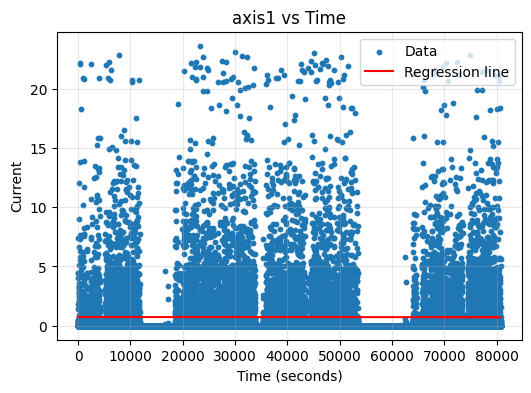

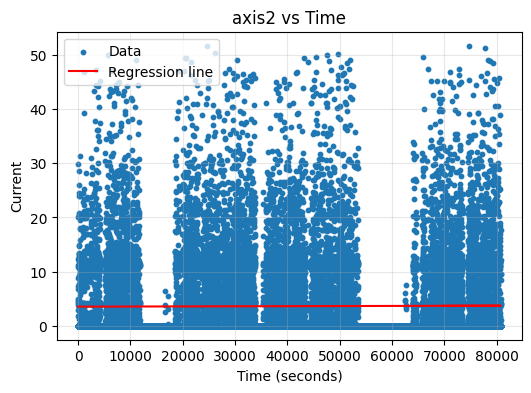

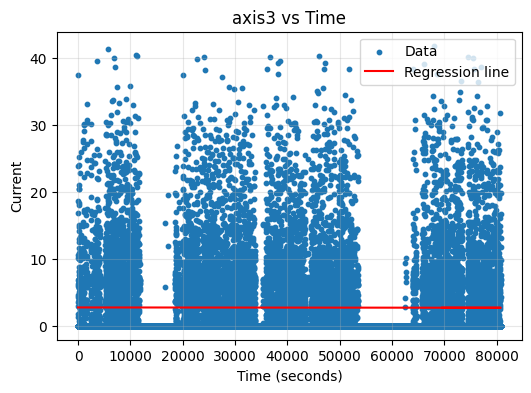

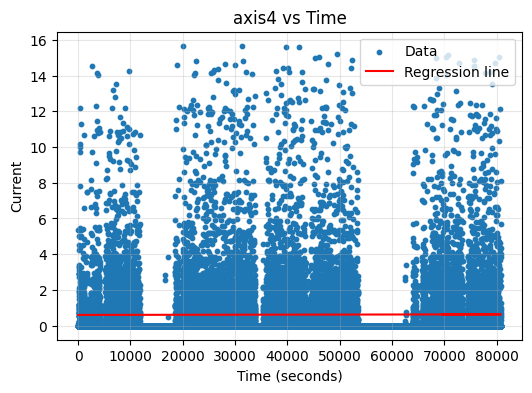

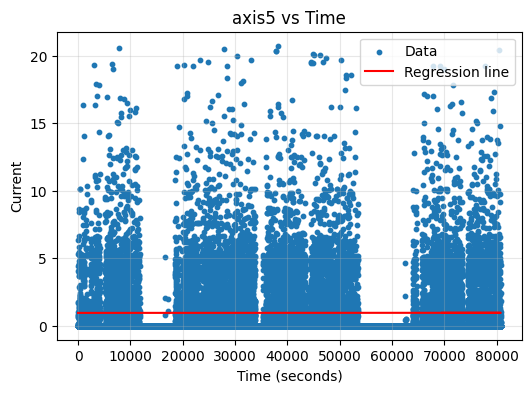

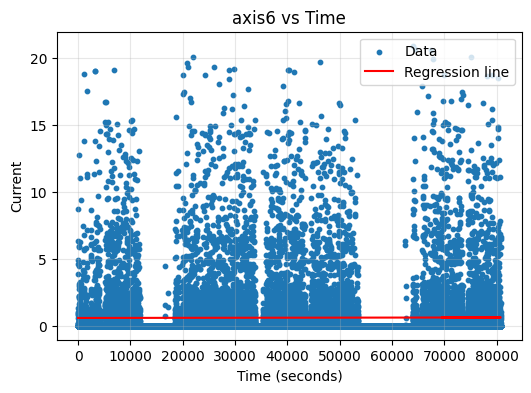

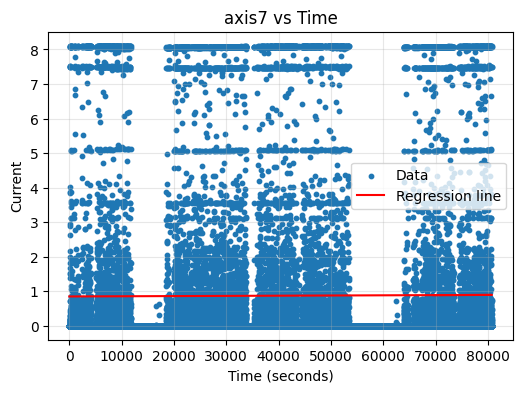

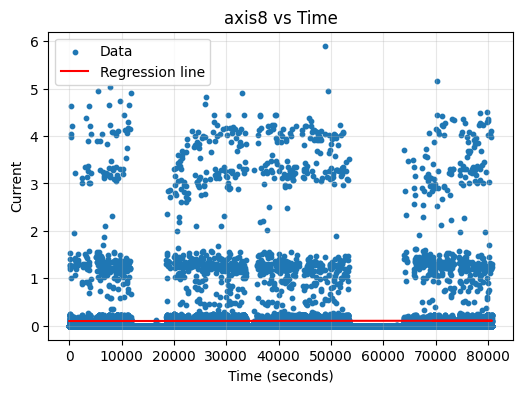

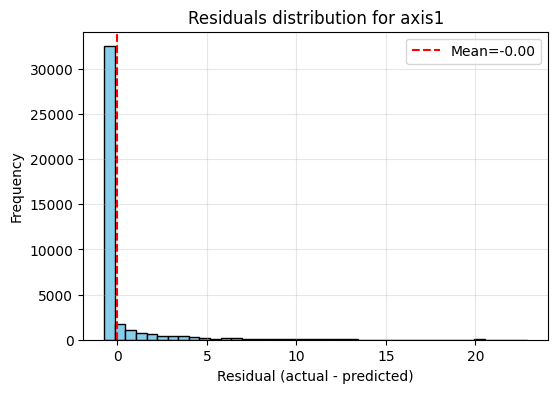

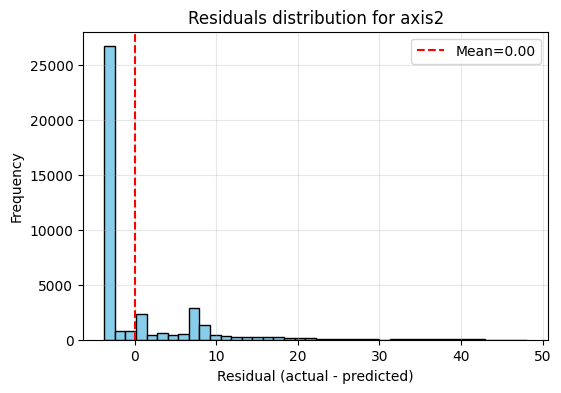

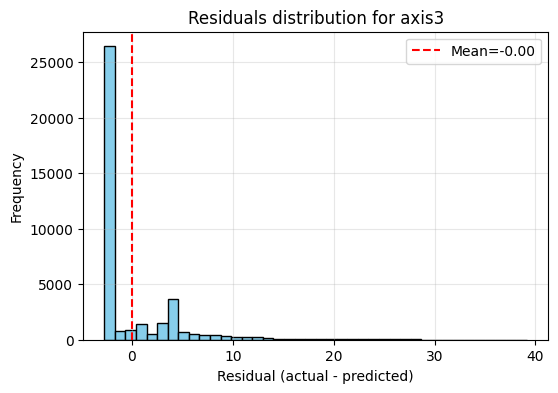

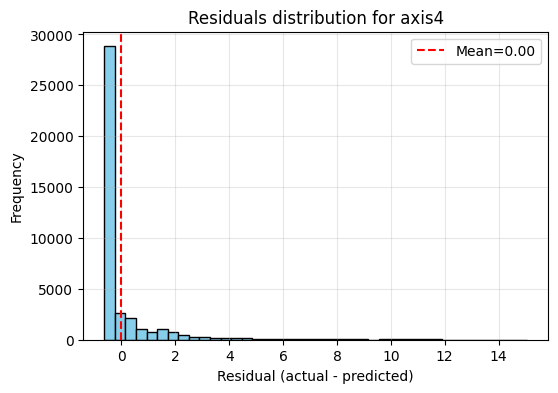

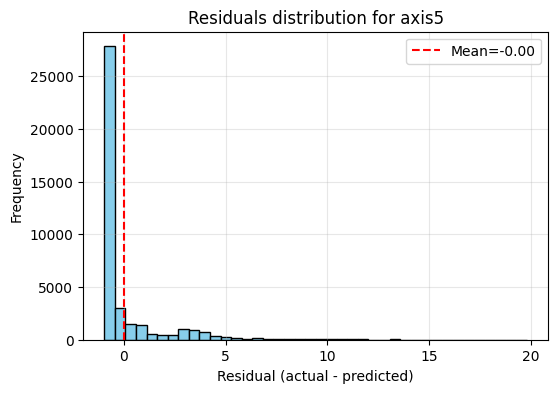

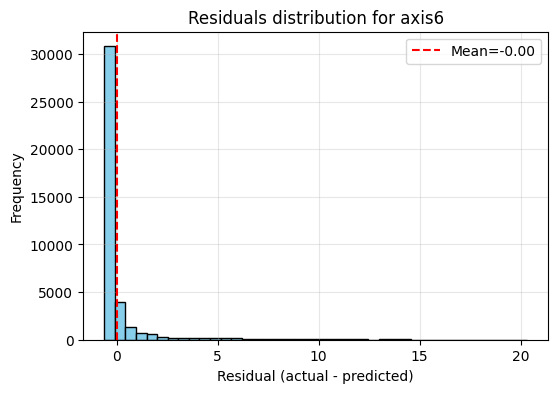

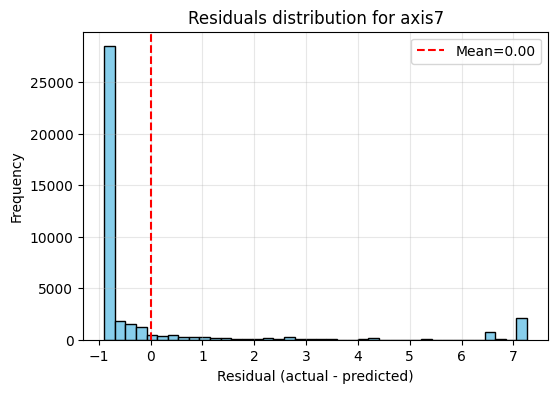

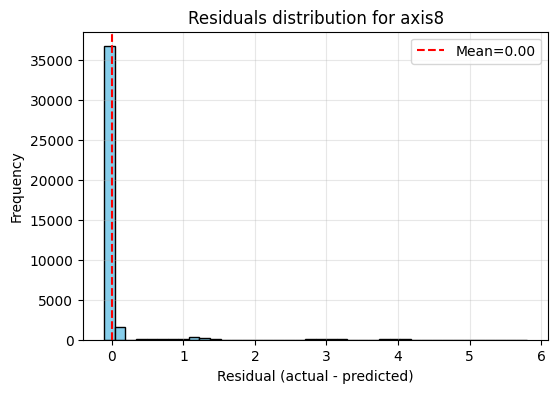

In [16]:
# --- Step 2: Visualization ---

# 1) Plot scatter + regression line for each axis
for axis in AXES:
    y = df_train[axis].values
    X = df_train[['time_numeric']].values
    y_pred = models[axis].predict(X)
    
    plt.figure(figsize=(6,4))
    plt.scatter(df_train['time_numeric'], y, label='Data', s=10)
    plt.plot(df_train['time_numeric'], y_pred, color='red', label='Regression line')
    plt.title(f'{axis} vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Current')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# 2) Plot histograms of residuals
for axis in AXES:
    res = residuals_dict[axis]
    
    plt.figure(figsize=(6,4))
    plt.hist(res, bins=40, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(res), color='red', linestyle='--', label=f"Mean={np.mean(res):.2f}")
    plt.title(f'Residuals distribution for {axis}')
    plt.xlabel('Residual (actual - predicted)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


## Discover thresholds (MinC, MaxC)

In [17]:
# --- Step 3: Threshold Discovery ---

def discover_thresholds(residuals_dict, method="percentile",
                        minc_q=97.5, maxc_q=99.5,
                        k_min=2.5, k_max=3.5):
    rows = []
    minc_by_axis = {}
    maxc_by_axis = {}
    
    for axis, res in residuals_dict.items():
        res = np.asarray(res)
        pos = res[res > 0]   # focus on positive residuals only
        if len(pos) == 0:
            pos = res  # fallback if all values <= 0

        if method == "percentile":
            MinC = float(np.percentile(pos, minc_q))
            MaxC = float(np.percentile(pos, maxc_q))
        elif method == "std":
            mu = float(np.mean(pos))
            sigma = float(np.std(pos, ddof=0))
            MinC = mu + k_min * sigma
            MaxC = mu + k_max * sigma
        else:
            raise ValueError("method must be 'percentile' or 'std'")
        
        minc_by_axis[axis] = MinC
        maxc_by_axis[axis] = MaxC
        rows.append({"axis": axis, "MinC": MinC, "MaxC": MaxC})
    
    return pd.DataFrame(rows), minc_by_axis, maxc_by_axis

# --- Calculate thresholds both ways ---
thr_table_pct, MinC_pct, MaxC_pct = discover_thresholds(
    residuals_dict, method="percentile", minc_q=95, maxc_q=98
)

thr_table_std, MinC_std, MaxC_std = discover_thresholds(
    residuals_dict, method="std", k_min=2.5, k_max=3.5
)

print("📊 Percentile-based thresholds:")
display(thr_table_pct)

print("📊 Std-based thresholds:")
display(thr_table_std)

# Save for later / README
thr_table_pct.to_csv(DATA_DIR / "thresholds_percentile.csv", index=False)
thr_table_std.to_csv(DATA_DIR / "thresholds_std.csv", index=False)


📊 Percentile-based thresholds:


axis       MinC       MaxC
0  axis1  11.343826  15.557040
1  axis2  24.567595  33.815481
2  axis3  19.659364  24.923293
3  axis4   7.206002  10.611322
4  axis5   8.516996  11.642954
5  axis6   9.469247  12.932467
6  axis7   7.232741   7.244916
7  axis8   3.136179   3.918179

📊 Std-based thresholds:


axis       MinC       MaxC
0  axis1  12.922450  16.784425
1  axis2  27.933964  35.763480
2  axis3  20.561974  26.383488
3  axis4   7.920240  10.342461
4  axis5   9.984031  12.809243
5  axis6  10.110378  13.305862
6  axis7  11.445049  14.359989
7  axis8   2.879637   3.839790

## Synthetic Data Generation

In [28]:
from synthetic_data import make_synthetic_test

# --- Step 4A: Generate synthetic test data ---
df_test, sample_interval_sec = make_synthetic_test(
    df_train, models, AXES,
    anomaly_blocks=5,
    block_min_sec=15, block_max_sec=25,
    residuals_dict=residuals_dict,
    force_above=True,   # ensure anomalies exceed MaxC
    MinC=MinC_pct, 
    MaxC=MaxC_pct
)

# Save raw synthetic for reproducibility
synthetic_path = DATA_DIR / "Synthetic_test.csv"
df_test.to_csv(synthetic_path, index=False)
print(f" Raw synthetic test data saved to {synthetic_path}")
print(df_test.head())


# --- Step 4B: Normalize synthetic test data relative to training stats ---

norm_df = df_test.copy()
for axis in AXES:
    min_val, max_val = df_train[axis].min(), df_train[axis].max()
    if max_val > min_val:  # avoid divide by zero
        norm_df[axis] = (norm_df[axis] - min_val) / (max_val - min_val)

# Save normalized version (optional, but good for README evidence)
norm_path = DATA_DIR / "Synthetic_test_normalized.csv"
norm_df.to_csv(norm_path, index=False)
print(f"✅ Normalized synthetic test data saved to {norm_path}")
print(norm_df.head())

# --- Step 4C: Simulate CSV → DB → Streaming ---

# Push normalized synthetic data into DB
norm_df.to_sql("synthetic_stream", engine, if_exists="replace", index=False)
print("✅ Normalized synthetic test data loaded into DB (table: synthetic_stream)")

# Query back in chunks (simulate streaming)
for chunk in pd.read_sql("SELECT * FROM synthetic_stream ORDER BY time", engine, chunksize=50):
    print("Streaming batch (first 2 rows):")
    display(chunk.head(2))
    # Here you can pass `chunk` to detect_events_stream(chunk, ...)


 Raw synthetic test data saved to Data\Synthetic_test.csv
                              time  time_numeric     axis1     axis2      axis3     axis4     axis5     axis6  \
0 2022-10-18 10:45:00.519000+00:00         0.000  1.389368  3.497449   1.816929 -3.685892  5.250972 -3.365271   
1 2022-10-18 10:45:02.410000+00:00         1.891 -1.517998 -0.230891   1.959436 -1.891581  4.069671  1.457945   
2 2022-10-18 10:45:04.301000+00:00         3.782  2.353085  1.560868   4.080064 -2.076979  1.791396  0.673123   
3 2022-10-18 10:45:06.192000+00:00         5.673  2.764128  4.538042  -2.189341 -1.262888 -0.177773  1.842635   
4 2022-10-18 10:45:08.083000+00:00         7.564 -3.487774 -1.876997  11.438700  0.083660 -1.399045 -0.237926   

      axis7     axis8  
0  3.238792  0.549319  
1  4.393976  0.537043  
2 -2.353552  0.688603  
3  4.965829 -1.090496  
4  0.592390  0.611913  
✅ Normalized synthetic test data saved to Data\Synthetic_test_normalized.csv
                              time  time_n

time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:45:00.519000+00:00         0.000  0.058848  0.067632  0.043409 -0.235275  0.253050 -0.160776   
1 2022-10-18 10:45:02.410000+00:00         1.891 -0.064297 -0.004465  0.046814 -0.120742  0.196122  0.069653   

      axis7     axis8  
0  0.399433  0.093016  
1  0.541899  0.090937

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:46:35.069000+00:00        94.550  0.057419 -0.143735  0.123664  0.067802 -0.035240  0.072955   
1 2022-10-18 10:46:36.960000+00:00        96.441  0.088755 -0.045481  0.338446  0.085167  0.168012  0.019039   

      axis7     axis8  
0  0.255041  0.103083  
1  0.275306  0.076245

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:48:09.619000+00:00       189.100 -0.003689  0.054598 -0.055217 -0.034662  0.153063  0.028494   
1 2022-10-18 10:48:11.510000+00:00       190.991  0.149923  0.080996 -0.042729 -0.142719 -0.022233  0.067276   

      axis7     axis8  
0 -0.047427  0.071058  
1 -0.298823 -0.043933

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:49:44.169000+00:00       283.650  0.016414 -0.136861  0.118101  0.181528 -0.106412 -0.088042   
1 2022-10-18 10:49:46.060000+00:00       285.541 -0.063901 -0.136477  0.073344  0.071919  0.116520  0.145127   

      axis7     axis8  
0  0.280453  0.027033  
1  0.039976 -0.103583

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:51:18.719000+00:00       378.200  0.061855  0.242074  0.196743  0.083287 -0.196670 -0.011294   
1 2022-10-18 10:51:20.610000+00:00       380.091  0.159835  0.156397 -0.042497 -0.061840  0.111924 -0.074323   

      axis7     axis8  
0  0.112916  0.067649  
1  0.253674  0.048509

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:52:53.269000+00:00       472.750 -0.002783  0.118637  0.037429  0.156537  0.041323  0.082324   
1 2022-10-18 10:52:55.160000+00:00       474.641  0.062220  0.032298  0.224399  0.278818 -0.024421  0.065144   

      axis7     axis8  
0 -0.000640  0.094490  
1 -0.238274  0.080452

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:54:27.819000+00:00       567.300  0.189127 -0.026935  0.300632  0.065152  0.050541  0.014413   
1 2022-10-18 10:54:29.710000+00:00       569.191 -0.109528 -0.064086 -0.106791  0.089669  0.054220  0.023550   

      axis7     axis8  
0  0.194151 -0.033231  
1  0.130000 -0.103252

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:56:02.369000+00:00       661.850  0.064673  0.222530  0.185634 -0.014193  0.115574  0.034215   
1 2022-10-18 10:56:04.260000+00:00       663.741  0.108468  0.015915  0.104211  0.006346  0.120941 -0.003216   

      axis7     axis8  
0  0.603373  0.048269  
1  0.637832  0.069217

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:57:36.919000+00:00       756.400  0.014491  0.053365  0.030275 -0.034453  0.064234 -0.068053   
1 2022-10-18 10:57:38.810000+00:00       758.291  0.048960  0.152584 -0.020455  0.023549 -0.082663  0.056594   

      axis7     axis8  
0 -0.036806 -0.045185  
1  0.135981  0.106100

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:59:11.469000+00:00       850.950  0.018929  0.094628 -0.065631 -0.038260  0.094559 -0.075002   
1 2022-10-18 10:59:13.360000+00:00       852.841  0.062879 -0.177077 -0.017203 -0.023826  0.229434 -0.134186   

      axis7     axis8  
0 -0.053561  0.103630  
1 -0.155582 -0.012338

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:00:46.019000+00:00       945.500  0.155838 -0.033929  0.216648  0.021874  0.067701  0.011157   
1 2022-10-18 11:00:47.910000+00:00       947.391  0.112917  0.225485  0.029349  0.152042 -0.024670 -0.056289   

      axis7     axis8  
0 -0.236522 -0.054073  
1 -0.021533 -0.089346

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:02:20.569000+00:00      1040.050  0.066199  0.188280  0.186795  0.034794  0.000224  0.088613   
1 2022-10-18 11:02:22.460000+00:00      1041.941  0.081904  0.273344  0.072813 -0.027116 -0.167048  0.113071   

      axis7     axis8  
0  0.421196 -0.023080  
1  0.463871  0.090706

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:03:55.119000+00:00      1134.600  0.078138  0.035578  0.270616  0.115013  0.027796  0.160228   
1 2022-10-18 11:03:57.010000+00:00      1136.491 -0.021953  0.142651  0.015527  0.024708 -0.129159  0.103065   

      axis7     axis8  
0  0.208556 -0.051499  
1  0.205674 -0.027572

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:05:29.669000+00:00      1229.150  0.200157  0.142963  0.124635  0.005678  0.083086 -0.137070   
1 2022-10-18 11:05:31.560000+00:00      1231.041  0.014986 -0.240977  0.293305  0.213829  0.091240 -0.071678   

      axis7     axis8  
0  0.499212  0.024209  
1 -0.039660  0.081163

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:07:04.219000+00:00      1323.700  0.132859  0.273338 -0.029973  0.060097  0.141892  0.115096   
1 2022-10-18 11:07:06.110000+00:00      1325.591  0.008494  0.071503  0.160626  0.012331 -0.063893  0.243087   

      axis7     axis8  
0  0.492177  0.022190  
1  0.380687  0.001662

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:08:38.769000+00:00      1418.250  0.031985 -0.095795  0.005067  0.027071  0.025270 -0.084503   
1 2022-10-18 11:08:40.660000+00:00      1420.141  0.003530  0.097050  0.069064  0.008102 -0.067748 -0.065993   

      axis7     axis8  
0  0.359604 -0.063708  
1 -0.040739  0.015887

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:10:13.319000+00:00      1512.800 -0.046452  0.100461  0.178690  0.145564  0.204562 -0.134425   
1 2022-10-18 11:10:15.210000+00:00      1514.691 -0.068307  0.189239 -0.035549  0.019427 -0.012416  0.207906   

      axis7     axis8  
0  0.312013  0.026390  
1  0.443026  0.006231

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:11:47.869000+00:00      1607.350 -0.002201  0.138538 -0.181602 -0.046296  0.185947  0.020142   
1 2022-10-18 11:11:49.760000+00:00      1609.241 -0.013915  0.030974  0.246344 -0.080014  0.170283 -0.037440   

      axis7     axis8  
0  0.221143 -0.026874  
1 -0.013621  0.033648

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:13:22.419000+00:00      1701.900  0.066622 -0.198714  0.046703  0.045163  0.017247 -0.041981   
1 2022-10-18 11:13:24.310000+00:00      1703.791  0.040326  0.004998  0.218849  0.155553  0.090958 -0.174847   

      axis7     axis8  
0  0.026607  0.142606  
1 -0.028867 -0.080910

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:14:56.969000+00:00      1796.450 -0.126897  0.064979  0.253334 -0.000486  0.010047  0.062684   
1 2022-10-18 11:14:58.860000+00:00      1798.341  0.072306 -0.256072 -0.046126  0.161505  0.158056  0.032560   

      axis7     axis8  
0  0.262009  0.112873  
1  0.242737  0.034379

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:16:31.519000+00:00      1891.000  0.025505  0.139762  0.052047  0.261995  0.038541  0.054356   
1 2022-10-18 11:16:33.410000+00:00      1892.891 -0.035853  0.140328  0.197681 -0.058820  0.184632  0.039307   

      axis7     axis8  
0  0.055510 -0.045946  
1 -0.227348  0.011647

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:18:06.069000+00:00      1985.550 -0.082784 -0.110719 -0.024930 -0.060801  0.142907 -0.113204   
1 2022-10-18 11:18:07.960000+00:00      1987.441  0.012245  0.150498  0.219285 -0.017642  0.097533 -0.017682   

      axis7     axis8  
0  0.166857  0.043456  
1  0.496173  0.029705

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:19:40.619000+00:00      2080.100  0.134425  0.047355 -0.046589  0.089710 -0.017478 -0.060589   
1 2022-10-18 11:19:42.510000+00:00      2081.991  0.087171  0.160482  0.073044  0.044837 -0.044554  0.051641   

      axis7     axis8  
0  0.046602 -0.051113  
1  0.003580  0.083448

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:21:15.169000+00:00      2174.650  0.047788  0.389276 -0.012310 -0.025964  0.197678  0.061803   
1 2022-10-18 11:21:17.060000+00:00      2176.541  0.119090 -0.059575  0.099347  0.037645  0.038517  0.026222   

      axis7     axis8  
0  0.379376 -0.044753  
1  0.210282  0.061121

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:22:49.719000+00:00      2269.200 -0.090184  0.125698  0.081577  0.057796  0.027400 -0.017719   
1 2022-10-18 11:22:51.610000+00:00      2271.091 -0.013593  0.040302  0.177786  0.071138  0.108997 -0.127532   

      axis7     axis8  
0  0.235459  0.130624  
1  0.247920 -0.063173

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:24:24.269000+00:00      2363.750  0.119514  0.037622  0.090702  0.223357 -0.099075 -0.045532   
1 2022-10-18 11:24:26.160000+00:00      2365.641  0.169836 -0.068580  0.033888  0.133697  0.010068  0.097217   

      axis7     axis8  
0  0.409629  0.065944  
1 -0.097149  0.053272

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:25:58.819000+00:00      2458.300  0.035828  0.213739  0.343140  0.137128 -0.208976  0.122007   
1 2022-10-18 11:26:00.710000+00:00      2460.191 -0.159955 -0.014630 -0.081538  0.217039 -0.120315  0.053507   

      axis7     axis8  
0  0.398133  0.072508  
1  0.119611 -0.004857

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:27:33.369000+00:00      2552.850  0.007772 -0.042512 -0.006692 -0.079351  0.069753  0.080404   
1 2022-10-18 11:27:35.260000+00:00      2554.741  0.082422 -0.013746  0.012931 -0.131472 -0.094253 -0.015185   

      axis7     axis8  
0  0.199779 -0.045221  
1  0.370519  0.026827

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:29:07.919000+00:00      2647.400  0.139224  0.259255  0.122171  0.006692  0.204351 -0.004838   
1 2022-10-18 11:29:09.810000+00:00      2649.291  0.001260  0.178787 -0.044424  0.022535  0.063481  0.260555   

      axis7     axis8  
0  0.413618  0.033029  
1  0.209658  0.031982

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:30:42.469000+00:00      2741.950  0.001117  0.201840  0.023068  0.090049  0.075824  0.032712   
1 2022-10-18 11:30:44.360000+00:00      2743.841  0.077625 -0.352721  0.007200  0.120485  0.106302  0.010635   

      axis7     axis8  
0  0.114252  0.037735  
1  0.343725  0.066927

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:32:17.019000+00:00      2836.500 -0.020931  0.047469  0.163894 -0.046214  0.071209  0.175306   
1 2022-10-18 11:32:18.910000+00:00      2838.391 -0.026271  0.047945  0.143534 -0.085549  0.082802 -0.085601   

      axis7     axis8  
0  0.090382  0.012544  
1  0.517868 -0.010072

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:33:51.569000+00:00      2931.050 -0.112580  0.127277  0.177721 -0.046082  0.173457  0.147570   
1 2022-10-18 11:33:53.460000+00:00      2932.941 -0.035405  0.118389  0.245250 -0.048270  0.052921 -0.119481   

      axis7     axis8  
0  0.243427  0.015786  
1  0.078239  0.063071

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:35:26.119000+00:00      3025.600  0.025897 -0.101847  0.028165  0.174497  0.043718 -0.122378   
1 2022-10-18 11:35:28.010000+00:00      3027.491  0.134657  0.157489 -0.057338  0.088516  0.084181  0.115424   

      axis7     axis8  
0  0.152370 -0.054232  
1 -0.045175  0.002644

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:37:00.669000+00:00      3120.150 -0.015466  0.211821 -0.056291 -0.055560  0.075313 -0.022397   
1 2022-10-18 11:37:02.560000+00:00      3122.041  0.147495  0.006675  0.361436  0.016905  0.165480 -0.068222   

      axis7     axis8  
0 -0.119787 -0.061100  
1  0.239361 -0.020785

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:38:35.219000+00:00      3214.700 -0.072369  0.133956  0.181428  0.072858 -0.019968  0.063227   
1 2022-10-18 11:38:37.110000+00:00      3216.591 -0.014258  0.067667  0.167884 -0.041347 -0.051277 -0.030397   

      axis7     axis8  
0  0.365863  0.006471  
1  0.031816  0.025995

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:40:09.769000+00:00      3309.250 -0.040002 -0.174461  0.039173 -0.110735  0.032066 -0.034407   
1 2022-10-18 11:40:11.660000+00:00      3311.141 -0.025755  0.205523  0.129188  0.160436 -0.037102  0.118757   

      axis7     axis8  
0 -0.251090  0.091375  
1  0.066166  0.009469

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5    axis6     axis7  \
0 2022-10-18 11:41:44.319000+00:00      3403.800  0.027290  0.232663 -0.096170  0.065909  0.055001 -0.04671  0.002436   
1 2022-10-18 11:41:46.210000+00:00      3405.691  0.071445 -0.095444  0.123932 -0.051732  0.088679 -0.04824  0.128341   

      axis8  
0 -0.025163  
1  0.080201

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:43:18.869000+00:00      3498.350 -0.027826  0.235533 -0.017417  0.137838  0.074461  0.145252   
1 2022-10-18 11:43:20.760000+00:00      3500.241  0.052106  0.258868 -0.050536  0.084526  0.112306  0.035326   

      axis7     axis8  
0 -0.364932  0.002279  
1  0.379792 -0.048700

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:44:53.419000+00:00      3592.900 -0.019862  0.088383  0.068557  0.083995  0.014532  0.104966   
1 2022-10-18 11:44:55.310000+00:00      3594.791  0.129033 -0.036466  0.181743  0.258544  0.128362  0.080852   

      axis7     axis8  
0  0.691093 -0.069420  
1 -0.168756  0.048066

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:46:27.969000+00:00      3687.450  0.036091  0.122854  0.172250 -0.067765  0.027817 -0.009217   
1 2022-10-18 11:46:29.860000+00:00      3689.341  0.053395  0.002098  0.066169 -0.069144  0.214156  0.009219   

      axis7     axis8  
0 -0.188491 -0.093162  
1  0.404919  0.083618

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:48:02.519000+00:00      3782.000 -0.010465 -0.053272 -0.015880  0.117628  0.099633 -0.035121   
1 2022-10-18 11:48:04.410000+00:00      3783.891 -0.030056  0.126415 -0.139074 -0.071402  0.105873  0.023992   

      axis7     axis8  
0  0.157268  0.111094  
1  0.045868 -0.039322

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:49:37.069000+00:00      3876.550  0.101152  0.071763 -0.127685  0.070597  0.062800 -0.023460   
1 2022-10-18 11:49:38.960000+00:00      3878.441 -0.081232  0.074541  0.316703  0.087422 -0.172462  0.031785   

      axis7     axis8  
0  0.368894  0.050862  
1  0.254203 -0.025938

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:51:11.619000+00:00      3971.100  0.054427  0.133972 -0.019356 -0.021419  0.172627 -0.006045   
1 2022-10-18 11:51:13.510000+00:00      3972.991 -0.126086 -0.005708 -0.059947  0.125878  0.055747  0.024831   

      axis7     axis8  
0  0.526561 -0.000758  
1 -0.122159  0.081564

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:52:46.169000+00:00      4065.650  0.025107  0.147315  0.211895 -0.012424 -0.040965  0.115750   
1 2022-10-18 11:52:48.060000+00:00      4067.541  0.097911  0.229900  0.125661  0.142534  0.077766  0.026203   

      axis7     axis8  
0  0.004929  0.071164  
1 -0.025867  0.215222

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:54:20.719000+00:00      4160.200 -0.018487  0.002492  0.248182  0.305067  0.134942 -0.013501   
1 2022-10-18 11:54:22.610000+00:00      4162.091  0.014726 -0.131180  0.176021  0.141316  0.022997 -0.094903   

      axis7     axis8  
0  0.203072  0.027452  
1 -0.341837  0.140180

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:55:55.269000+00:00      4254.750 -0.064006  0.060891  0.121045  0.111515  0.137030  0.010724   
1 2022-10-18 11:55:57.160000+00:00      4256.641  0.023182 -0.030918  0.172788  0.016612  0.196389  0.053432   

      axis7     axis8  
0  0.294746 -0.005148  
1  0.129950  0.062469

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:57:29.819000+00:00      4349.300 -0.013972  0.140148 -0.008344  0.031996  0.112559  0.023671   
1 2022-10-18 11:57:31.710000+00:00      4351.191 -0.050585  0.165740  0.105329  0.084632 -0.035444 -0.098768   

      axis7     axis8  
0  0.435120  0.107084  
1 -0.359262  0.092599

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 11:59:04.369000+00:00      4443.850  0.090588  0.027251 -0.114424  0.060185  0.035615  0.000673   
1 2022-10-18 11:59:06.260000+00:00      4445.741  0.087846 -0.020086  0.190485  0.233608  0.175520  0.041293   

      axis7     axis8  
0 -0.029977  0.010371  
1 -0.109001  0.034999

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:00:38.919000+00:00      4538.400 -0.009930  0.307785 -0.026361  0.138571  0.144805  0.097265   
1 2022-10-18 12:00:40.810000+00:00      4540.291  0.120684  0.034034  0.504563  0.028526  0.050450  0.058529   

      axis7     axis8  
0  0.016458  0.037554  
1  0.290375  0.026737

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:02:13.469000+00:00      4632.950 -0.018082 -0.235593  0.396891  0.101994  0.001004  0.046495   
1 2022-10-18 12:02:15.360000+00:00      4634.841 -0.006001  0.144479  0.096414  0.108520  0.075947 -0.007102   

      axis7     axis8  
0  0.277683  0.116788  
1  0.072988  0.018717

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:03:48.019000+00:00      4727.500  0.081569 -0.113583 -0.050972  0.019806 -0.003153  0.010281   
1 2022-10-18 12:03:49.910000+00:00      4729.391  0.053714 -0.025329  0.079075  0.005736  0.016601  0.145189   

      axis7     axis8  
0  0.181897  0.042870  
1  0.481732 -0.052905

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:05:22.569000+00:00      4822.050 -0.122851  0.245229  0.076077 -0.114235  0.076543  0.012813   
1 2022-10-18 12:05:24.460000+00:00      4823.941  0.021007  0.278885  0.118076 -0.036925  0.005167 -0.029764   

      axis7     axis8  
0  0.192655  0.063886  
1 -0.111328 -0.072901

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:06:57.119000+00:00      4916.600 -0.018880  0.090311  0.106441 -0.029426  0.042387  0.126431   
1 2022-10-18 12:06:59.010000+00:00      4918.491  0.160164 -0.019009 -0.013115 -0.058422  0.219897  0.264012   

      axis7     axis8  
0  0.400889  0.007048  
1  0.147900 -0.045920

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:08:31.669000+00:00      5011.150 -0.065915  0.174504  0.358370  0.133710  0.079939 -0.115241   
1 2022-10-18 12:08:33.560000+00:00      5013.041 -0.142880 -0.016046  0.036653 -0.039785  0.004120  0.009401   

      axis7     axis8  
0 -0.462531  0.035775  
1  0.380024  0.039625

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:10:06.219000+00:00      5105.700  0.109419  0.181670  0.106297  0.027478 -0.130433  0.017923   
1 2022-10-18 12:10:08.110000+00:00      5107.591 -0.070921  0.144339 -0.059665  0.074100 -0.086398  0.047110   

      axis7     axis8  
0  0.413730 -0.069879  
1 -0.331665  0.116144

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:11:40.769000+00:00      5200.250  0.066769 -0.083489 -0.013883 -0.092118  0.085040  0.113146   
1 2022-10-18 12:11:42.660000+00:00      5202.141 -0.005131  0.113782  0.194165  0.166172  0.180705  0.034963   

      axis7     axis8  
0  0.055800  0.055829  
1  0.033104  0.092004

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:13:15.319000+00:00      5294.800  0.007142 -0.078408  0.158076  0.112237  0.211363 -0.025120   
1 2022-10-18 12:13:17.210000+00:00      5296.691  0.119729  0.148332  0.170827 -0.077024 -0.044527  0.152428   

      axis7     axis8  
0  0.067245  0.093379  
1  0.571745  0.149725

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:14:49.869000+00:00      5389.350  0.016710 -0.282535 -0.022259 -0.093027  0.025313  0.042953   
1 2022-10-18 12:14:51.760000+00:00      5391.241  0.161957  0.025455  0.075249 -0.000990  0.053741 -0.067922   

      axis7     axis8  
0  0.594513  0.095965  
1 -0.071911 -0.014364

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:16:24.419000+00:00      5483.900 -0.020409  0.042371  0.305356 -0.078656 -0.034250 -0.086899   
1 2022-10-18 12:16:26.310000+00:00      5485.791 -0.097889  0.093500 -0.026626  0.082386 -0.072236  0.004780   

      axis7     axis8  
0  0.068704 -0.018569  
1  0.051956  0.030422

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:17:58.969000+00:00      5578.450 -0.076201  0.142507  0.117620 -0.027172 -0.103584  0.013063   
1 2022-10-18 12:18:00.860000+00:00      5580.341  0.100044  0.012946  0.092663 -0.036524  0.022586  0.120159   

      axis7     axis8  
0  0.129623  0.027676  
1  0.102490 -0.133694

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:19:33.519000+00:00      5673.000  0.145298 -0.021093 -0.021613  0.008199  0.058890  0.038333   
1 2022-10-18 12:19:35.410000+00:00      5674.891  0.093892  0.197761 -0.146219  0.065977  0.112282  0.205831   

      axis7     axis8  
0  0.840770  0.009675  
1  0.086856  0.002319

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:21:08.069000+00:00      5767.550  0.122113  0.065659 -0.168072  0.063316 -0.116762  0.006305   
1 2022-10-18 12:21:09.960000+00:00      5769.441 -0.054641 -0.152528  0.139167 -0.023127 -0.021206 -0.034683   

      axis7     axis8  
0  0.692662  0.087796  
1  0.195098 -0.053310

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:22:42.619000+00:00      5862.100 -0.062131  0.220965  0.214629  0.213000  0.269674  0.166459   
1 2022-10-18 12:22:44.510000+00:00      5863.991 -0.016912 -0.004849  0.028143  0.137857 -0.004123  0.031109   

      axis7     axis8  
0  0.311169 -0.056997  
1 -0.017469  0.015379

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:24:17.169000+00:00      5956.650  0.055684 -0.140698  0.065140 -0.111585  0.020066  0.027787   
1 2022-10-18 12:24:19.060000+00:00      5958.541 -0.052331  0.273223  0.020112  0.030360  0.075605  0.097851   

      axis7     axis8  
0 -0.116957 -0.103616  
1  0.212558  0.022322

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:25:51.719000+00:00      6051.200 -0.021623  0.014008 -0.032370  0.064957 -0.062903 -0.143926   
1 2022-10-18 12:25:53.610000+00:00      6053.091  0.137463  0.170350  0.083426  0.083280 -0.088056 -0.027811   

      axis7     axis8  
0  0.008638  0.042419  
1  0.032512  0.049744

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:27:26.269000+00:00      6145.750  0.136170  0.082560 -0.132963  0.111305  0.090831 -0.007831   
1 2022-10-18 12:27:28.160000+00:00      6147.641  0.026816  0.109699 -0.029927  0.226486 -0.098057  0.061088   

      axis7     axis8  
0  0.701571 -0.088854  
1 -0.007096  0.003428

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:29:00.819000+00:00      6240.300  0.081303  0.047433 -0.111299  0.078437 -0.071582  0.035085   
1 2022-10-18 12:29:02.710000+00:00      6242.191  0.219727  0.032928 -0.027857  0.116348  0.083314 -0.199157   

      axis7     axis8  
0 -0.085614  0.127328  
1  0.149971  0.007709

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:30:35.369000+00:00      6334.850  0.036859 -0.021976 -0.056231 -0.115963  0.059027  0.067602   
1 2022-10-18 12:30:37.260000+00:00      6336.741  0.069404  0.000701  0.065944 -0.010075  0.066758  0.071729   

      axis7     axis8  
0  0.205631  0.119669  
1  0.206832  0.071980

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:32:09.919000+00:00      6429.400  0.067449  0.154996  0.068798 -0.025608 -0.045303 -0.213592   
1 2022-10-18 12:32:11.810000+00:00      6431.291  0.106457 -0.068208  0.217029  0.057277  0.070026 -0.027717   

      axis7     axis8  
0 -0.313763  0.057261  
1  0.009069 -0.082423

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:33:44.469000+00:00      6523.950 -0.113903  0.002285  0.152982  0.064572  0.121496  0.032298   
1 2022-10-18 12:33:46.360000+00:00      6525.841  0.095399  0.128983  0.043453 -0.021461  0.108277  0.153151   

      axis7     axis8  
0 -0.124249  0.030903  
1  0.185087 -0.018843

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:35:19.019000+00:00      6618.500  0.008608 -0.020054  0.071888 -0.194802 -0.089909  0.013355   
1 2022-10-18 12:35:20.910000+00:00      6620.391  0.151988 -0.026800  0.006578  0.052434  0.108981 -0.048706   

      axis7     axis8  
0  0.212259 -0.054358  
1 -0.011152 -0.026483

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:36:53.569000+00:00      6713.050 -0.037103  0.122118 -0.064671 -0.067941  0.147727 -0.131681   
1 2022-10-18 12:36:55.460000+00:00      6714.941 -0.077581 -0.382658  0.083293  0.070415 -0.077316 -0.040076   

      axis7     axis8  
0  0.128387  0.008087  
1  0.065674 -0.073670

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:38:28.119000+00:00      6807.600  0.119579  0.017192  0.208964 -0.127458  0.030669 -0.051611   
1 2022-10-18 12:38:30.010000+00:00      6809.491  0.252327  0.317081  0.130001 -0.086647 -0.103003 -0.033176   

      axis7     axis8  
0 -0.195400  0.000331  
1 -0.073917  0.082066

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:40:02.669000+00:00      6902.150  0.161822 -0.115927  0.101470  0.008376 -0.145333 -0.034931   
1 2022-10-18 12:40:04.560000+00:00      6904.041  0.054416 -0.019660  0.136062  0.079049 -0.069138  0.180794   

      axis7     axis8  
0 -0.097316  0.087809  
1  0.326042  0.055248

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:41:37.219000+00:00      6996.700  0.026286  0.075843  0.033690  0.043637  0.059884  0.050781   
1 2022-10-18 12:41:39.110000+00:00      6998.591 -0.050736  0.290031  0.187764 -0.007613  0.044097 -0.110690   

      axis7     axis8  
0  0.103979 -0.142118  
1  0.557037  0.019537

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:43:11.769000+00:00      7091.250  0.005080  0.217467 -0.074138  0.005232  0.089847  0.141232   
1 2022-10-18 12:43:13.660000+00:00      7093.141 -0.026953  0.165844  0.224598  0.144861  0.134712  0.144170   

      axis7     axis8  
0  0.159272  0.063667  
1  0.083011  0.036490

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:44:46.319000+00:00      7185.800  0.001684  0.302461  0.014361  0.219645  0.112404 -0.048249   
1 2022-10-18 12:44:48.210000+00:00      7187.691 -0.037662  0.079117  0.063408  0.039432 -0.007260  0.091743   

      axis7     axis8  
0 -0.137686  0.001583  
1 -0.233000 -0.031284

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:46:20.869000+00:00      7280.350  0.085039  0.152234  0.140222  0.057418  0.152937  0.147631   
1 2022-10-18 12:46:22.760000+00:00      7282.241 -0.037045  0.253607  0.058960  0.130066 -0.048552 -0.032411   

      axis7     axis8  
0  0.519724  0.045386  
1  0.411506 -0.079043

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:47:55.419000+00:00      7374.900  0.089728  0.059551  0.206313  0.086839  0.016928  0.055631   
1 2022-10-18 12:47:57.310000+00:00      7376.791  0.091579  0.061970  0.174686  0.043831  0.044630  0.181296   

      axis7     axis8  
0 -0.173416 -0.093426  
1  0.305603 -0.095233

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:49:29.969000+00:00      7469.450 -0.035671  0.136822  0.059108  0.234392  0.026234  0.044955   
1 2022-10-18 12:49:31.860000+00:00      7471.341  0.249215  0.186161 -0.052851 -0.030055 -0.145880  0.239682   

      axis7     axis8  
0 -0.024640 -0.101195  
1  0.204507 -0.063521

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:51:04.519000+00:00      7564.000  0.054093  0.151396 -0.153631  0.040945 -0.032071  0.033775   
1 2022-10-18 12:51:06.410000+00:00      7565.891  0.112888  0.195394 -0.163538  0.013278  0.064952 -0.065154   

      axis7     axis8  
0  0.279366 -0.018405  
1 -0.216182  0.063977

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:52:39.069000+00:00      7658.550  0.112355  0.111797  0.199646  0.111871 -0.088084  0.005544   
1 2022-10-18 12:52:40.960000+00:00      7660.441  0.021819 -0.088290  0.028817 -0.083378  0.097355 -0.121951   

      axis7     axis8  
0  0.207784  0.094902  
1  0.304035  0.024516

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:54:13.619000+00:00      7753.100  0.082640  0.127606  0.160351  0.133133  0.086916 -0.012431   
1 2022-10-18 12:54:15.510000+00:00      7754.991  0.046559  0.344256 -0.035305  0.105839  0.204132  0.033845   

      axis7     axis8  
0  0.004422  0.141816  
1  0.155917 -0.042089

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:55:48.169000+00:00      7847.650 -0.005353  0.015988 -0.195002  0.134585 -0.103977 -0.030004   
1 2022-10-18 12:55:50.060000+00:00      7849.541  0.164106  0.382112  0.123353 -0.097910 -0.045319 -0.049199   

      axis7     axis8  
0  0.503488 -0.063168  
1  0.253889  0.100725

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:57:22.719000+00:00      7942.200 -0.043192  0.155946  0.141594  0.167293  0.231395 -0.055200   
1 2022-10-18 12:57:24.610000+00:00      7944.091 -0.151260  0.241522  0.141352  0.108357 -0.191972  0.059955   

      axis7     axis8  
0  0.152945  0.106743  
1  0.032638  0.019951

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 12:58:57.269000+00:00      8036.750  0.006387 -0.035602  0.092983  0.034316 -0.048631  0.112656   
1 2022-10-18 12:58:59.160000+00:00      8038.641 -0.008789  0.132320  0.038146  0.115948  0.060022 -0.199674   

      axis7     axis8  
0  0.041638  0.035344  
1 -0.004380  0.041984

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:00:31.819000+00:00      8131.300 -0.009700  0.212360  0.072362 -0.006365  0.069237  0.041898   
1 2022-10-18 13:00:33.710000+00:00      8133.191  0.131285  0.012404  0.115894  0.099597  0.004605  0.050594   

      axis7     axis8  
0 -0.112357 -0.066320  
1  0.000482  0.068742

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:02:06.369000+00:00      8225.850  0.012620  0.192839  0.080309  0.007458 -0.030934  0.003680   
1 2022-10-18 13:02:08.260000+00:00      8227.741 -0.074221  0.107431  0.037045 -0.154115  0.055497  0.065112   

      axis7     axis8  
0 -0.035644 -0.103715  
1 -0.261020  0.090046

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:03:40.919000+00:00      8320.400  0.026461  0.128844  0.085485 -0.022209 -0.099796  0.071382   
1 2022-10-18 13:03:42.810000+00:00      8322.291 -0.011736 -0.125024  0.062096  0.325319  0.125442 -0.042878   

      axis7     axis8  
0 -0.048534 -0.022422  
1  0.141545  0.071883

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:05:15.469000+00:00      8414.950 -0.039490 -0.003154  0.022334  0.180267 -0.001136  0.147910   
1 2022-10-18 13:05:17.360000+00:00      8416.841  0.008292 -0.026241  0.084724  0.098618  0.072521  0.089703   

      axis7     axis8  
0 -0.082877  0.044599  
1  0.065834  0.023499

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:06:50.019000+00:00      8509.500 -0.105373  0.026582  0.250124  0.021165  0.138506  0.115346   
1 2022-10-18 13:06:51.910000+00:00      8511.391  0.130318  0.088083  0.028591  0.110410  0.128065 -0.038363   

      axis7     axis8  
0  0.122262 -0.115038  
1  0.295104 -0.074751

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:08:24.569000+00:00      8604.050  0.122016 -0.018211  0.079466 -0.093231  0.105790 -0.100025   
1 2022-10-18 13:08:26.460000+00:00      8605.941 -0.031148 -0.128018  0.076130 -0.037910  0.143304  0.036342   

      axis7     axis8  
0  0.264507  0.053505  
1 -0.382624 -0.013244

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:09:59.119000+00:00      8698.600  0.098906  0.154820  0.016196  0.217296  0.150534 -0.048876   
1 2022-10-18 13:10:01.010000+00:00      8700.491  0.034942 -0.047745 -0.059733  0.025952  0.113585 -0.053224   

      axis7     axis8  
0  0.162854  0.129859  
1 -0.047715 -0.035065

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:11:33.669000+00:00      8793.150 -0.055608 -0.128717  0.249349  0.272046 -0.027214  0.077316   
1 2022-10-18 13:11:35.560000+00:00      8795.041  0.121735  0.050359  0.055903  0.108094 -0.066411  0.104819   

      axis7     axis8  
0  0.264885  0.051510  
1  0.267588  0.040731

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:13:08.219000+00:00      8887.700  0.103506  0.065019 -0.075380 -0.169407  0.070978 -0.023121   
1 2022-10-18 13:13:10.110000+00:00      8889.591 -0.013961 -0.107042  0.251282 -0.041208  0.054152  0.071483   

      axis7     axis8  
0  0.013470 -0.031551  
1  0.478991  0.152213

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:14:42.769000+00:00      8982.250  0.110241  0.054319 -0.062516 -0.035471  0.102648  0.079237   
1 2022-10-18 13:14:44.660000+00:00      8984.141  0.053822  0.311169  0.062588 -0.056802  0.132960 -0.068876   

      axis7     axis8  
0 -0.296544  0.059797  
1 -0.278843 -0.056007

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:16:17.319000+00:00      9076.800  0.033211  0.088074 -0.080448 -0.011844  0.049530  0.031971   
1 2022-10-18 13:16:19.210000+00:00      9078.691  0.080595 -0.004762  0.200602  0.154711  0.075418  0.167314   

      axis7     axis8  
0 -0.037992  0.036675  
1 -0.132231  0.145317

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:17:51.869000+00:00      9171.350  0.001469  0.121069 -0.053762  0.032116  0.096309 -0.118403   
1 2022-10-18 13:17:53.760000+00:00      9173.241  0.012473  0.122133  0.046424 -0.035189 -0.070755 -0.006902   

      axis7     axis8  
0 -0.678929  0.072335  
1  0.175891  0.123818

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:19:26.419000+00:00      9265.900 -0.159791  0.161134  0.129365  0.061496 -0.066923 -0.028627   
1 2022-10-18 13:19:28.310000+00:00      9267.791  0.037361  0.123174  0.159169 -0.161053  0.071555  0.038522   

      axis7     axis8  
0  0.364905 -0.034719  
1  0.381631  0.028852

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 13:21:00.969000+00:00      9360.450  0.134377  0.181107 -0.06900  0.161541  0.134269  0.137486  0.871521   
1 2022-10-18 13:21:02.860000+00:00      9362.341 -0.045097  0.275669 -0.11632  0.003763  0.076985 -0.045563  0.300710   

      axis8  
0  0.019248  
1 -0.081411

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:22:35.519000+00:00      9455.000  0.007273  0.142507  0.366503  0.182439  0.027317 -0.037396   
1 2022-10-18 13:22:37.410000+00:00      9456.891  0.003470  0.135188  0.217928  0.094706  0.234998  0.015450   

      axis7     axis8  
0 -0.678127 -0.029148  
1  0.304370  0.104379

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:24:10.069000+00:00      9549.550  0.069285 -0.002278  0.223105  0.018599 -0.001553  0.081870   
1 2022-10-18 13:24:11.960000+00:00      9551.441  0.044469 -0.165196  0.183055 -0.067912  0.375694  0.030628   

      axis7     axis8  
0  0.246136 -0.069125  
1  0.554411  0.016095

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:25:44.619000+00:00      9644.100 -0.049488  0.010864  0.025494 -0.052401 -0.003607  0.166728   
1 2022-10-18 13:25:46.510000+00:00      9645.991  0.177987  0.246580 -0.013864  0.168186  0.042869  0.011258   

      axis7     axis8  
0  0.229012 -0.016935  
1 -0.312470  0.075206

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:27:19.169000+00:00      9738.650  0.179913  0.097257  0.267152  0.006555  0.124128 -0.046983   
1 2022-10-18 13:27:21.060000+00:00      9740.541  0.023263  0.109854  0.247842 -0.086054 -0.160692 -0.037042   

      axis7     axis8  
0 -0.259917  0.026260  
1  0.227650  0.030076

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5    axis6     axis7  \
0 2022-10-18 13:28:53.719000+00:00      9833.200  0.054003  0.176174  0.159326  0.046730  0.107677  0.06509 -0.008679   
1 2022-10-18 13:28:55.610000+00:00      9835.091 -0.012911  0.042470  0.176985  0.139823  0.188643  0.08320  0.541220   

      axis8  
0 -0.006694  
1  0.129939

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:30:28.269000+00:00      9927.750  0.022005 -0.091139  0.043322  0.066285  0.036653  0.006809   
1 2022-10-18 13:30:30.160000+00:00      9929.641  0.161514  0.117302  0.090259  0.024136 -0.135613  0.106009   

      axis7     axis8  
0 -0.019887 -0.041206  
1  0.410220  0.057087

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:32:02.819000+00:00     10022.300 -0.039291  0.144544  0.053909 -0.047573  0.080097 -0.062979   
1 2022-10-18 13:32:04.710000+00:00     10024.191 -0.043241 -0.359344  0.017057  0.075342 -0.108338  0.091628   

      axis7     axis8  
0 -0.216158 -0.005874  
1  0.020306 -0.091583

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:33:37.369000+00:00     10116.850 -0.020831  0.174940  0.059994  0.022265  0.174032 -0.081068   
1 2022-10-18 13:33:39.260000+00:00     10118.741  0.058015  0.121415  0.138238  0.110587 -0.027380 -0.104953   

      axis7     axis8  
0 -0.101307  0.096158  
1  0.111441 -0.020596

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:35:11.919000+00:00     10211.400  0.002311  0.322221  0.245083 -0.105578  0.045624  0.081958   
1 2022-10-18 13:35:13.810000+00:00     10213.291  0.097881  0.027592  0.073435  0.212115  0.011618 -0.008916   

      axis7     axis8  
0  0.332369  0.055193  
1  0.434479  0.070924

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:36:46.469000+00:00     10305.950  0.012606  0.046172 -0.023088  0.058475 -0.023084  0.099304   
1 2022-10-18 13:36:48.360000+00:00     10307.841 -0.048813 -0.120188  0.221140  0.093490  0.260821 -0.129172   

      axis7     axis8  
0  0.235484  0.041944  
1 -0.507350  0.154589

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:38:21.019000+00:00     10400.500 -0.014259 -0.179267  0.035936  0.021137 -0.190718  0.191636   
1 2022-10-18 13:38:22.910000+00:00     10402.391 -0.172903 -0.104102 -0.054078  0.019760  0.152343 -0.173099   

      axis7     axis8  
0  0.435992 -0.055418  
1  0.138735 -0.025116

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:39:55.569000+00:00     10495.050  0.096701  0.181541  0.359443  0.081507  0.168431  0.123632   
1 2022-10-18 13:39:57.460000+00:00     10496.941  0.016419  0.122372  0.008234  0.128948  0.106595  0.082220   

      axis7     axis8  
0  0.332427  0.014655  
1  0.336046 -0.074671

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:41:30.119000+00:00     10589.600  0.185641  0.087560  0.083624 -0.018320  0.101127 -0.031052   
1 2022-10-18 13:41:32.010000+00:00     10591.491  0.153804  0.034594  0.066885 -0.106501 -0.103296  0.059864   

      axis7     axis8  
0 -0.182568  0.022786  
1  0.892927  0.006896

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:43:04.669000+00:00     10684.150  0.066918  0.188833  0.175301  0.134656 -0.068119 -0.110076   
1 2022-10-18 13:43:06.560000+00:00     10686.041 -0.100090  0.256753  0.030835  0.078600  0.062172  0.028630   

      axis7     axis8  
0  0.227459 -0.095080  
1  0.031335 -0.003071

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:44:39.219000+00:00     10778.700  0.005376 -0.006181  0.168925  0.025230 -0.067950 -0.020644   
1 2022-10-18 13:44:41.110000+00:00     10780.591  0.135709  0.086087 -0.101993 -0.004543  0.246092  0.108852   

      axis7     axis8  
0 -0.104002 -0.001180  
1  0.265996  0.189183

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:46:13.769000+00:00     10873.250  0.066434  0.129328  0.139761  0.036914  0.100434  0.192319   
1 2022-10-18 13:46:15.660000+00:00     10875.141  0.060622 -0.295410  0.050489 -0.028496  0.108487 -0.021118   

      axis7     axis8  
0  0.149863 -0.002421  
1 -0.098074  0.090028

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:47:48.319000+00:00     10967.800 -0.012154  0.162204  0.241601  0.149796  0.004808  0.066856   
1 2022-10-18 13:47:50.210000+00:00     10969.691 -0.096782  0.113275 -0.012172  0.034949 -0.003816  0.003963   

      axis7     axis8  
0  0.317416  0.013454  
1  0.277798  0.006836

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:49:22.869000+00:00     11062.350  0.123300  0.197556  0.055085  0.218745  0.042155  0.035092   
1 2022-10-18 13:49:24.760000+00:00     11064.241  0.129152  0.121091  0.163122  0.103052  0.142147 -0.085212   

      axis7     axis8  
0 -0.117345  0.064858  
1  0.036236 -0.020749

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:50:57.419000+00:00     11156.900  0.035594  0.127527  0.319667  0.126834 -0.037680 -0.023332   
1 2022-10-18 13:50:59.310000+00:00     11158.791  0.000860 -0.069455  0.209561 -0.106878  0.112453  0.017936   

      axis7     axis8  
0 -0.206280 -0.074445  
1  0.127693 -0.065838

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:52:31.969000+00:00     11251.450 -0.177286  0.100356  0.030377  0.039838 -0.008292  0.027159   
1 2022-10-18 13:52:33.860000+00:00     11253.341  0.094568  0.085683  0.105042  0.012161  0.143977 -0.065624   

      axis7     axis8  
0  0.681722 -0.020281  
1  0.142828  0.168984

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:54:06.519000+00:00     11346.000  0.051502  0.154365 -0.007263 -0.012704  0.123430 -0.002583   
1 2022-10-18 13:54:08.410000+00:00     11347.891  0.026001  0.183016  0.022340  0.040244 -0.141395  0.109015   

      axis7     axis8  
0 -0.234002  0.091148  
1  0.230216  0.131135

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:55:41.069000+00:00     11440.550 -0.036195  0.194226  0.153673  0.040524 -0.244390 -0.003349   
1 2022-10-18 13:55:42.960000+00:00     11442.441 -0.005837 -0.198731  0.138279 -0.026495  0.005758  0.026833   

      axis7     axis8  
0 -0.203569  0.008037  
1  0.657227 -0.027965

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 13:57:15.619000+00:00     11535.100  0.001160  0.213155  0.217358  0.132860  0.092496 -0.012139   
1 2022-10-18 13:57:17.510000+00:00     11536.991 -0.033999  0.019634  0.057296  0.054146 -0.020549  0.034508   

      axis7     axis8  
0  0.587267  0.034399  
1 -0.032227 -0.009188

Streaming batch (first 2 rows):


time  time_numeric     axis1    axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 13:58:50.169000+00:00     11629.650 -0.027874  0.01178 -0.037204  0.057074  0.112780 -0.020659 -0.479980   
1 2022-10-18 13:58:52.060000+00:00     11631.541 -0.042509 -0.05177  0.083060  0.002558  0.160996  0.074309 -0.363929   

      axis8  
0 -0.043780  
1  0.164964

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:00:24.719000+00:00     11724.200  0.167376  0.128042 -0.068772  0.077026 -0.049816  0.095462   
1 2022-10-18 14:00:26.610000+00:00     11726.091 -0.045250  0.039210  0.132116  0.032696 -0.113176 -0.029538   

      axis7     axis8  
0 -0.331417  0.046210  
1  0.397065 -0.029988

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:01:59.269000+00:00     11818.750  0.006375  0.189709  0.053894  0.048205  0.026117  0.008494   
1 2022-10-18 14:02:01.160000+00:00     11820.641  0.096669 -0.055978  0.083203  0.087963 -0.084946  0.072629   

      axis7     axis8  
0  0.179570  0.179270  
1 -0.322976  0.094382

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:03:33.819000+00:00     11913.300  0.174711 -0.038850 -0.024546  0.020689  0.130961  0.184420   
1 2022-10-18 14:03:35.710000+00:00     11915.191 -0.034824  0.134053  0.027181  0.118879  0.172246  0.070968   

      axis7     axis8  
0  0.388249  0.018032  
1  0.346062  0.040194

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 14:05:08.369000+00:00     12007.850  0.065959 -0.014664 -0.02052  0.020042 -0.103833 -0.040976 -0.331946   
1 2022-10-18 14:05:10.260000+00:00     12009.741 -0.043922  0.100181 -0.05018  0.105481  0.060965  0.066697  0.027715   

      axis8  
0 -0.029563  
1  0.024568

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:06:42.919000+00:00     12102.400  0.130128  0.098611  0.045119 -0.067012  0.209630  0.077089   
1 2022-10-18 14:06:44.810000+00:00     12104.291 -0.056793 -0.007510  0.208107  0.037106  0.108633  0.082132   

      axis7     axis8  
0 -0.220874  0.004962  
1 -0.250909  0.007197

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:08:17.469000+00:00     12196.950  0.104183  0.214074 -0.015789 -0.025570 -0.041863 -0.068267   
1 2022-10-18 14:08:19.360000+00:00     12198.841  0.059782  0.053988  0.011737  0.030868  0.058720 -0.033008   

      axis7     axis8  
0 -0.012091  0.144176  
1  0.777365 -0.050192

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:09:52.019000+00:00     12291.500  0.145456  0.126402 -0.029372  0.023093 -0.029111  0.115010   
1 2022-10-18 14:09:53.910000+00:00     12293.391  0.163572  0.189590  0.129137  0.062284  0.029011  0.117804   

      axis7     axis8  
0  0.111208 -0.077542  
1  0.046644  0.081230

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:11:26.569000+00:00     12386.050  0.031389  0.099919  0.125482  0.126993  0.087120  0.016697   
1 2022-10-18 14:11:28.460000+00:00     12387.941 -0.068533  0.085758  0.145713  0.165578  0.029235  0.002002   

      axis7     axis8  
0 -0.503812  0.025733  
1  0.102378  0.185961

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6    axis7  \
0 2022-10-18 14:13:01.119000+00:00     12480.600  0.111776  0.177072 -0.186919  0.109210 -0.104970 -0.055114 -0.42010   
1 2022-10-18 14:13:03.010000+00:00     12482.491  0.002887  0.095496  0.012589  0.038054  0.091858 -0.025805 -0.42173   

      axis8  
0 -0.006180  
1  0.057814

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:14:35.669000+00:00     12575.150  0.105920  0.095463  0.128226  0.144665  0.099905 -0.080240   
1 2022-10-18 14:14:37.560000+00:00     12577.041 -0.012566  0.173143  0.173230 -0.029493 -0.125824  0.069261   

      axis7     axis8  
0 -0.045465  0.203005  
1  0.548020  0.011754

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:16:10.219000+00:00     12669.700 -0.041037 -0.016852  0.272801  0.140963  0.027511 -0.008519   
1 2022-10-18 14:16:12.110000+00:00     12671.591  0.189770  0.199790  0.033335  0.098035 -0.060990 -0.012584   

      axis7     axis8  
0 -0.204396  0.261428  
1  0.030734 -0.016785

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:17:44.769000+00:00     12764.250  0.094618  0.144468  0.098378  0.019038  0.044963 -0.005965   
1 2022-10-18 14:17:46.660000+00:00     12766.141  0.017695 -0.115314  0.244634 -0.036186 -0.188284 -0.011739   

      axis7     axis8  
0 -0.155880 -0.009981  
1  0.332727  0.083104

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:19:19.319000+00:00     12858.800 -0.012823  0.176248 -0.063986  0.166486  0.110885  0.129986   
1 2022-10-18 14:19:21.210000+00:00     12860.691  0.127085  0.367982  0.045064  0.115868  0.227285 -0.073043   

      axis7     axis8  
0  0.212004  0.051843  
1  0.562758 -0.040627

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:20:53.869000+00:00     12953.350  0.143543 -0.015436 -0.054947  0.001651  0.147314 -0.050207   
1 2022-10-18 14:20:55.760000+00:00     12955.241  0.203717  0.177948  0.016795  0.187344 -0.016024  0.043199   

      axis7     axis8  
0  0.088179  0.177238  
1 -0.019617  0.063411

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:22:28.419000+00:00     13047.900 -0.066815 -0.054994  0.247008  0.129479  0.153791  0.133343   
1 2022-10-18 14:22:30.310000+00:00     13049.791  0.155180  0.250241 -0.048602 -0.092567  0.031415  0.014910   

      axis7     axis8  
0  0.359986 -0.085773  
1  0.332960  0.061261

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:24:02.969000+00:00     13142.450  0.187467 -0.206092  0.116269 -0.016465  0.208741 -0.006706   
1 2022-10-18 14:24:04.860000+00:00     13144.341  0.200375  0.031123  0.051846  0.122384  0.065061  0.132788   

      axis7     axis8  
0  0.288567  0.101571  
1 -0.033411  0.055568

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:25:37.519000+00:00     13237.000 -0.102893  0.064467 -0.194606 -0.005004 -0.017144 -0.108554   
1 2022-10-18 14:25:39.410000+00:00     13238.891 -0.050683  0.117214  0.031262 -0.096100  0.147594  0.032692   

      axis7   axis8  
0 -0.012451  0.0792  
1 -0.309025 -0.0088

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:27:12.069000+00:00     13331.550  0.078412  0.157331  0.063595 -0.063101 -0.024176  0.059880   
1 2022-10-18 14:27:13.960000+00:00     13333.441  0.192134 -0.032776 -0.100599 -0.078398 -0.005663  0.042878   

      axis7     axis8  
0  0.071361 -0.021661  
1  0.245949  0.007933

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:28:46.619000+00:00     13426.100  0.144356  0.089544 -0.195566 -0.074741  0.203488 -0.113050   
1 2022-10-18 14:28:48.510000+00:00     13427.991 -0.090872  0.026285 -0.148223  0.003855 -0.059286 -0.030203   

      axis7     axis8  
0  0.171322 -0.080827  
1 -0.223978  0.033404

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:30:21.169000+00:00     13520.650 -0.009826  0.149633  0.073752  0.110830 -0.163491  0.025475   
1 2022-10-18 14:30:23.060000+00:00     13522.541  0.086862 -0.050207 -0.131831  0.043264 -0.113471  0.185013   

      axis7     axis8  
0  0.213370  0.100875  
1  0.025431 -0.000811

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:31:55.719000+00:00     13615.200  0.108417  0.125189 -0.000183  0.141164  0.016439 -0.013732   
1 2022-10-18 14:31:57.610000+00:00     13617.091  0.098546 -0.099035  0.292217 -0.030740  0.039929  0.104292   

      axis7     axis8  
0 -0.221390  0.003059  
1  0.353684 -0.053047

Streaming batch (first 2 rows):


time  time_numeric    axis1     axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 14:33:30.269000+00:00     13709.750 -0.05786 -0.104013  0.151072  0.090742  0.109887  0.207098  0.098439   
1 2022-10-18 14:33:32.160000+00:00     13711.641 -0.01255  0.043253 -0.056248 -0.005255 -0.054479  0.021527  0.200917   

      axis8  
0 -0.060341  
1  0.035036

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:35:04.819000+00:00     13804.300  0.045882  0.125811  0.025165 -0.002254  0.271704  0.199835   
1 2022-10-18 14:35:06.710000+00:00     13806.191 -0.023965  0.085911  0.027229 -0.113786 -0.013690  0.225183   

      axis7     axis8  
0 -0.213672  0.024468  
1  0.214359 -0.007618

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:36:39.369000+00:00     13898.850  0.156408  0.117508  0.103349  0.121906 -0.001207  0.076357   
1 2022-10-18 14:36:41.260000+00:00     13900.741  0.021271 -0.011157  0.091304 -0.015485  0.058745  0.087151   

      axis7     axis8  
0 -0.255325  0.138785  
1 -0.099901  0.102203

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:38:13.919000+00:00     13993.400  0.047737 -0.105091  0.123136  0.037387  0.034910 -0.029785   
1 2022-10-18 14:38:15.810000+00:00     13995.291  0.172556  0.236279  0.208060 -0.089295  0.053277  0.085301   

      axis7     axis8  
0 -0.403427 -0.074965  
1  0.132453  0.003317

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:39:48.469000+00:00     14087.950 -0.183121  0.158418 -0.052521 -0.063302 -0.118323  0.092018   
1 2022-10-18 14:39:50.360000+00:00     14089.841 -0.070392  0.287822 -0.103311 -0.114579  0.044073 -0.012226   

      axis7     axis8  
0 -0.221205 -0.015907  
1 -0.068190  0.116477

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:41:23.019000+00:00     14182.500  0.116600 -0.123160  0.235686  0.078000  0.238354  0.091070   
1 2022-10-18 14:41:24.910000+00:00     14184.391 -0.168053  0.394067  0.035496  0.056361  0.159830  0.008175   

      axis7     axis8  
0  0.379841  0.065174  
1  0.484233 -0.016013

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:42:57.569000+00:00     14277.050  0.056119  0.249063 -0.030471  0.207850 -0.062221 -0.033703   
1 2022-10-18 14:42:59.460000+00:00     14278.941  0.093603 -0.154627 -0.102907  0.184476  0.117225  0.012802   

      axis7     axis8  
0 -0.332006 -0.069191  
1  0.245511 -0.009339

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:44:32.119000+00:00     14371.600  0.054150 -0.046525  0.167888  0.013248  0.085158 -0.027148   
1 2022-10-18 14:44:34.010000+00:00     14373.491 -0.104863  0.100463  0.093185  0.042445  0.115031 -0.018564   

      axis7     axis8  
0 -0.249403  0.040958  
1  0.070525  0.025052

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:46:06.669000+00:00     14466.150 -0.244021  0.302560  0.017135  0.078687  0.009917 -0.088452   
1 2022-10-18 14:46:08.560000+00:00     14468.041 -0.109187 -0.069711 -0.126749 -0.158008  0.137165 -0.009784   

      axis7     axis8  
0  0.271100 -0.016156  
1  0.695029 -0.057764

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:47:41.219000+00:00     14560.700 -0.015918  0.216789  0.212459  0.035055 -0.012078  0.064849   
1 2022-10-18 14:47:43.110000+00:00     14562.591  0.010359  0.136802  0.019427 -0.125671 -0.008461  0.093638   

      axis7     axis8  
0  0.197385  0.014072  
1  0.288838 -0.076814

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:49:15.769000+00:00     14655.250 -0.032197 -0.084506  0.062946  0.122305  0.063556  0.108761   
1 2022-10-18 14:49:17.660000+00:00     14657.141  0.047923  0.091766 -0.078353 -0.114694  0.087478 -0.048811   

      axis7     axis8  
0  0.418771  0.076875  
1  0.025395 -0.125069

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:50:50.319000+00:00     14749.800  0.082364 -0.158311  0.051982 -0.004365 -0.092757 -0.154889   
1 2022-10-18 14:50:52.210000+00:00     14751.691  0.119715 -0.137634  0.039036  0.105891  0.012985  0.080742   

      axis7     axis8  
0 -0.241422 -0.092736  
1  0.151774  0.004657

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:52:24.869000+00:00     14844.350  0.088508 -0.049740 -0.080715 -0.033098 -0.085650  0.064726   
1 2022-10-18 14:52:26.760000+00:00     14846.241  0.144901 -0.057611  0.133498 -0.005956  0.045677  0.105507   

      axis7     axis8  
0  0.471016 -0.007982  
1  0.051298 -0.059734

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:53:59.419000+00:00     14938.900 -0.017320  0.007098  0.184481  0.009966  0.168756  0.042622   
1 2022-10-18 14:54:01.310000+00:00     14940.791  0.108342  0.224788  0.186336  0.003666 -0.158475  0.153137   

      axis7     axis8  
0  0.170898  0.102467  
1  0.222555  0.024700

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:55:33.969000+00:00     15033.450 -0.099890  0.024818 -0.122496  0.039845  0.025000  0.134682   
1 2022-10-18 14:55:35.860000+00:00     15035.341  0.181425  0.131304 -0.146430  0.183154 -0.045295 -0.031033   

      axis7     axis8  
0  0.527201 -0.006293  
1  0.393625 -0.006231

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:57:08.519000+00:00     15128.000  0.061418  0.012683 -0.254749  0.028514  0.038605 -0.003969   
1 2022-10-18 14:57:10.410000+00:00     15129.891  0.144089  0.063173  0.300700 -0.034490  0.110373 -0.101613   

      axis7     axis8  
0 -0.306321  0.056538  
1  0.658572 -0.064747

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 14:58:43.069000+00:00     15222.550  0.065146  0.037345  0.086350  0.103975  0.161192  0.068369   
1 2022-10-18 14:58:44.960000+00:00     15224.441  0.111657  0.088494  0.045854  0.103913  0.267156 -0.015025   

      axis7     axis8  
0 -0.365672  0.008977  
1 -0.473402  0.041748

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:00:17.619000+00:00     15317.100  0.145080  0.089584 -0.133093 -0.091891  0.033844  0.178351   
1 2022-10-18 15:00:19.510000+00:00     15318.991  0.016321 -0.062948  0.089879 -0.136886  0.147527 -0.107893   

      axis7     axis8  
0  0.346625  0.023039  
1  0.837652  0.013880

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:01:52.169000+00:00     15411.650  0.066788 -0.118973  0.004359  0.095767 -0.153783  0.031695   
1 2022-10-18 15:01:54.060000+00:00     15413.541  0.014662  0.002358 -0.113781  0.002891  0.124343  0.180541   

      axis7     axis8  
0  0.545093 -0.074719  
1  0.118544  0.002186

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:03:26.719000+00:00     15506.200  0.064574  0.119177  0.200555  0.126211 -0.019007 -0.055628   
1 2022-10-18 15:03:28.610000+00:00     15508.091 -0.125036  0.047654  0.027781 -0.044347  0.165197  0.053339   

      axis7     axis8  
0 -0.481612 -0.119311  
1  0.022428 -0.013896

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:05:01.269000+00:00     15600.750 -0.030442  0.243402 -0.082526  0.378459 -0.198479  0.237187   
1 2022-10-18 15:05:03.160000+00:00     15602.641  0.015590  0.257480  0.035112 -0.020553 -0.075313  0.084534   

      axis7     axis8  
0 -0.271068  0.001997  
1  0.474681 -0.058859

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:06:35.819000+00:00     15695.300  0.132701  0.084125 -0.304988  0.099133  0.227073  0.129853   
1 2022-10-18 15:06:37.710000+00:00     15697.191 -0.023949  0.101001  0.035764  0.080569  0.076185 -0.069950   

      axis7     axis8  
0 -0.289872  0.023245  
1  0.329559  0.041089

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:08:10.369000+00:00     15789.850  0.052692  0.012748  0.043459  0.038630  0.046411  0.044845   
1 2022-10-18 15:08:12.260000+00:00     15791.741  0.000296  0.175605  0.018133 -0.044971  0.062962 -0.032010   

      axis7     axis8  
0 -0.134773  0.200348  
1  0.350248 -0.003316

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:09:44.919000+00:00     15884.400 -0.012941  0.056005 -0.019026 -0.175922  0.099746 -0.081977   
1 2022-10-18 15:09:46.810000+00:00     15886.291  0.137011 -0.055362 -0.003763  0.097262  0.165771 -0.041743   

      axis7     axis8  
0 -0.337548 -0.041147  
1  0.225415  0.073667

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:11:19.469000+00:00     15978.950  0.128454 -0.113776  0.075206  0.023969 -0.146285  0.152768   
1 2022-10-18 15:11:21.360000+00:00     15980.841 -0.015798  0.026093 -0.013914  0.069530 -0.082749 -0.078914   

      axis7     axis8  
0 -0.476378  0.015321  
1  0.513169 -0.018151

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:12:54.019000+00:00     16073.500  0.034082  0.054369  0.254697  0.014016 -0.032940 -0.131745   
1 2022-10-18 15:12:55.910000+00:00     16075.391  0.050068  0.132221 -0.018409 -0.025909  0.095973 -0.013827   

      axis7     axis8  
0 -0.053055  0.021425  
1 -0.061599 -0.031917

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:14:28.569000+00:00     16168.050  0.049806  0.205405  0.036447  0.078352  0.010445 -0.104315   
1 2022-10-18 15:14:30.460000+00:00     16169.941  0.053407 -0.196931 -0.054689 -0.091493  0.034432  0.177327   

      axis7     axis8  
0  0.325925  0.051510  
1  0.274282  0.042162

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:16:03.119000+00:00     16262.600  0.067653  0.357930  0.236877  0.151828  0.080573  0.101581   
1 2022-10-18 15:16:05.010000+00:00     16264.491  0.106517  0.100573  0.129570  0.012332  0.095134  0.088874   

      axis7     axis8  
0  0.022852  0.031256  
1  0.511171 -0.037661

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:17:37.669000+00:00     16357.150  0.021693  0.017890  0.025078 -0.198117 -0.030714  0.003242   
1 2022-10-18 15:17:39.560000+00:00     16359.041  0.165458 -0.190247  0.033351  0.035234 -0.107304 -0.165204   

      axis7     axis8  
0 -0.299352  0.028731  
1 -0.592532  0.004846

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:19:12.219000+00:00     16451.700 -0.096284  0.009816  0.232563 -0.035066  0.158394 -0.017389   
1 2022-10-18 15:19:14.110000+00:00     16453.591 -0.080296  0.124711  0.080344  0.053876 -0.081198 -0.030256   

      axis7     axis8  
0  0.106886  0.104386  
1  0.192522  0.011977

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:20:46.769000+00:00     16546.250 -0.136166 -0.051838  0.017296  0.120119 -0.042013  0.150984   
1 2022-10-18 15:20:48.660000+00:00     16548.141  0.030646 -0.056316 -0.003584  0.166098  0.103586  0.052035   

      axis7     axis8  
0 -0.041195  0.137855  
1  0.201942  0.078167

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:22:21.319000+00:00     16640.800  0.101112 -0.113034  0.362282 -0.006439 -0.016796 -0.004936   
1 2022-10-18 15:22:23.210000+00:00     16642.691  0.105591 -0.042328  0.125346  0.091806  0.184214 -0.055252   

      axis7     axis8  
0  0.076953  0.055060  
1 -0.362702 -0.010354

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:23:55.869000+00:00     16735.350  0.143848 -0.018033 -0.078048  0.209481  0.108344 -0.000800   
1 2022-10-18 15:23:57.760000+00:00     16737.241  0.073255  0.079090 -0.077161  0.021394  0.053087  0.099588   

      axis7     axis8  
0  0.015280  0.095940  
1  0.506041  0.066983

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:25:30.419000+00:00     16829.900  0.224087  0.098636 -0.082214  0.106577  0.146112  0.022616   
1 2022-10-18 15:25:32.310000+00:00     16831.791 -0.108953  0.075355  0.123722  0.243065  0.062341  0.038092   

      axis7     axis8  
0 -0.250275 -0.016614  
1  0.194456  0.112360

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:27:04.969000+00:00     16924.450  0.149754 -0.067510  0.181374  0.104733  0.068550 -0.015555   
1 2022-10-18 15:27:06.860000+00:00     16926.341  0.118244  0.011038  0.014016 -0.081275  0.013946  0.071852   

      axis7     axis8  
0 -0.636063 -0.020512  
1  0.187983 -0.041618

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:28:39.519000+00:00     17019.000  0.040316  0.241919  0.228620  0.180488  0.265743 -0.140085   
1 2022-10-18 15:28:41.410000+00:00     17020.891 -0.071540  0.215264 -0.031361 -0.026068  0.017025  0.040577   

      axis7     axis8  
0  0.348598 -0.039148  
1  0.064125  0.005339

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:30:14.069000+00:00     17113.550 -0.087874  0.036279  0.111385  0.082549 -0.111309 -0.051839   
1 2022-10-18 15:30:15.960000+00:00     17115.441  0.001072 -0.015292  0.199417  0.065589  0.002118 -0.039421   

      axis7     axis8  
0 -0.013476  0.086778  
1  0.338617  0.036696

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:31:48.619000+00:00     17208.100  0.164124  0.200651  0.211118  0.020461  0.105565 -0.039451   
1 2022-10-18 15:31:50.510000+00:00     17209.991  0.072791  0.260500  0.243557  0.195838  0.171819  0.202434   

      axis7     axis8  
0  0.215536 -0.011792  
1  0.090277  0.011289

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4    axis5     axis6     axis7  \
0 2022-10-18 15:33:23.169000+00:00     17302.650  0.039631  0.152576 -0.012794 -0.048390  0.14181  0.057034  0.708838   
1 2022-10-18 15:33:25.060000+00:00     17304.541  0.014360  0.258165  0.208701 -0.015474  0.09392  0.003563  0.083406   

      axis8  
0  0.062081  
1 -0.138861

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:34:57.719000+00:00     17397.200  0.054370  0.283794  0.047208 -0.027965 -0.082729 -0.064322   
1 2022-10-18 15:34:59.610000+00:00     17399.091 -0.057096  0.036642  0.028163  0.084630  0.053581 -0.150502   

      axis7     axis8  
0  0.200741  0.153103  
1  0.101248 -0.067707

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:36:32.269000+00:00     17491.750  0.142569  0.035742  0.244932  0.208771  0.108298 -0.057652   
1 2022-10-18 15:36:34.160000+00:00     17493.641 -0.020916 -0.189122  0.154104 -0.142873  0.149906  0.047692   

      axis7     axis8  
0  0.414601  0.088193  
1  0.359839 -0.083555

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:38:06.819000+00:00     17586.300  0.020427  0.202439  0.293958 -0.111291  0.176789  0.048416   
1 2022-10-18 15:38:08.710000+00:00     17588.191 -0.055507 -0.031049  0.287282 -0.014108  0.027879  0.096262   

      axis7     axis8  
0 -0.392405  0.127145  
1  0.904287  0.015304

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:39:41.369000+00:00     17680.850  0.176449  0.209063 -0.052366  0.067739 -0.076933 -0.029553   
1 2022-10-18 15:39:43.260000+00:00     17682.741  0.068882  0.117963  0.060220 -0.117933  0.082392  0.044273   

      axis7     axis8  
0  0.267285  0.017908  
1  0.383016  0.078560

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:41:15.919000+00:00     17775.400 -0.046732  0.057130  0.017070  0.041307 -0.066785  0.099716   
1 2022-10-18 15:41:17.810000+00:00     17777.291  0.111814  0.132987  0.010684  0.004743  0.147598 -0.004376   

      axis7     axis8  
0  0.410093 -0.066548  
1 -0.350736 -0.062192

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:42:50.469000+00:00     17869.950  0.073007  0.181215  0.238802  0.056522 -0.035806  0.030550   
1 2022-10-18 15:42:52.360000+00:00     17871.841  0.004522  0.185580  0.083911  0.096571  0.142697 -0.108051   

      axis7     axis8  
0  0.459361 -0.058413  
1 -0.044198  0.012416

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:44:25.019000+00:00     17964.500 -0.154202 -0.061913  0.095565 -0.107784  0.040091  0.039590   
1 2022-10-18 15:44:26.910000+00:00     17966.391 -0.038297 -0.137863  0.020914 -0.020740  0.025419 -0.027157   

      axis7    axis8  
0  0.102446  0.00663  
1  0.267098 -0.02237

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:45:59.569000+00:00     18059.050  0.085716 -0.059074  0.128845 -0.039927  0.056808 -0.015300   
1 2022-10-18 15:46:01.460000+00:00     18060.941  0.135533 -0.242860 -0.052672 -0.035620  0.034657 -0.001406   

      axis7     axis8  
0  0.113665  0.003098  
1  0.506723 -0.095579

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:47:34.119000+00:00     18153.600  0.026974  0.148745  0.275002 -0.008393  0.032349  0.067260   
1 2022-10-18 15:47:36.010000+00:00     18155.491  0.091009  0.127883  0.221826  0.129258 -0.112742  0.034237   

      axis7     axis8  
0 -0.113805  0.017890  
1 -0.100272 -0.002927

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:49:08.669000+00:00     18248.150  0.178925 -0.116819 -0.183873  0.002028  0.187746  0.180396   
1 2022-10-18 15:49:10.560000+00:00     18250.041  0.179138 -0.118248  0.180642 -0.019114 -0.051639 -0.039289   

      axis7     axis8  
0  0.212312  0.111491  
1 -0.149448  0.140964

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:50:43.219000+00:00     18342.700 -0.017759  0.185491  0.114348  0.126946  0.181269  0.079078   
1 2022-10-18 15:50:45.110000+00:00     18344.591  0.159713  0.378473  0.047805  0.078463 -0.043875  0.085799   

      axis7     axis8  
0  0.590375  0.083724  
1 -0.382974 -0.020843

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:52:17.769000+00:00     18437.250  0.006955  0.055231  0.010839  0.058626 -0.103412  0.062724   
1 2022-10-18 15:52:19.660000+00:00     18439.141  0.169966 -0.021336  0.034042  0.182708  0.073134 -0.045825   

      axis7     axis8  
0 -0.179696  0.008964  
1  0.065688 -0.040645

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:53:52.319000+00:00     18531.800  0.029867  0.195126 -0.161849  0.109005 -0.029331  0.177533   
1 2022-10-18 15:53:54.210000+00:00     18533.691 -0.091961 -0.057951  0.152339  0.156585  0.088066  0.036776   

      axis7     axis8  
0 -0.176253  0.108146  
1  0.283501  0.058492

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:55:26.869000+00:00     18626.350  0.062784  0.137858  0.187826 -0.015236 -0.012117  0.001389   
1 2022-10-18 15:55:28.760000+00:00     18628.241  0.001955  0.308943  0.052281 -0.029933  0.186968  0.136643   

      axis7     axis8  
0 -0.088893  0.010180  
1 -0.083522  0.017523

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:57:01.419000+00:00     18720.900 -0.090432  0.034487  0.285134  0.060343  0.071216  0.021434   
1 2022-10-18 15:57:03.310000+00:00     18722.791  0.053767 -0.005882  0.014721 -0.002476 -0.068160  0.104945   

      axis7     axis8  
0  0.395788  0.042985  
1  0.218593 -0.061552

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 15:58:35.969000+00:00     18815.450  0.015695  0.164362  0.120058  0.107522  0.137197  0.053047   
1 2022-10-18 15:58:37.860000+00:00     18817.341  0.126364 -0.170077 -0.065840 -0.013028  0.028674  0.041314   

      axis7     axis8  
0  0.300815  0.101387  
1  0.357215  0.065136

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:00:10.519000+00:00     18910.000  0.046992  0.067363 -0.065255  0.109782 -0.052587  0.041450   
1 2022-10-18 16:00:12.410000+00:00     18911.891  0.113189  0.203445  0.016015  0.256531  0.000677 -0.013214   

      axis7     axis8  
0  0.241269  0.131597  
1  0.264626 -0.176740

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:01:45.069000+00:00     19004.550  0.021472  0.054076  0.025157 -0.052009  0.003262  0.142487   
1 2022-10-18 16:01:46.960000+00:00     19006.441  0.013361  0.147694  0.072732 -0.015591  0.168688 -0.185210   

      axis7     axis8  
0 -0.228791  0.025320  
1  0.493324 -0.040316

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:03:19.619000+00:00     19099.100 -0.051877 -0.053276 -0.069772 -0.001864 -0.070305  0.055261   
1 2022-10-18 16:03:21.510000+00:00     19100.991 -0.063139  0.014302  0.174879  0.035786  0.048331 -0.008540   

      axis7     axis8  
0 -0.116164  0.095002  
1  0.036812  0.062434

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:04:54.169000+00:00     19193.650 -0.033759 -0.147529 -0.120978  0.035386  0.238727  0.285568   
1 2022-10-18 16:04:56.060000+00:00     19195.541  0.124264 -0.123362  0.038280  0.087796 -0.074501  0.096730   

      axis7     axis8  
0  0.099736 -0.031181  
1  0.167691  0.149391

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:06:28.719000+00:00     19288.200 -0.073955  0.274397  0.240726  0.112578 -0.071779 -0.086296   
1 2022-10-18 16:06:30.610000+00:00     19290.091  0.125794  0.021132  0.000245 -0.054638 -0.103204 -0.033825   

      axis7     axis8  
0  0.425277  0.105611  
1 -0.117843 -0.088592

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:08:03.269000+00:00     19382.750 -0.035502  0.306303 -0.199890  0.038644  0.086564  0.204665   
1 2022-10-18 16:08:05.160000+00:00     19384.641 -0.001850 -0.036700 -0.044276  0.174420  0.152199 -0.166998   

      axis7     axis8  
0  0.346026 -0.125336  
1 -0.005190  0.088910

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:09:37.819000+00:00     19477.300  0.091489  0.018324 -0.031370  0.136863 -0.019734 -0.027416   
1 2022-10-18 16:09:39.710000+00:00     19479.191  0.146140  0.205677  0.232442  0.103339  0.018561  0.060027   

      axis7     axis8  
0  0.461926  0.061349  
1  0.289544  0.113884

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:11:12.369000+00:00     19571.850 -0.041658  0.204875  0.006368  0.085840  0.110381  0.087272   
1 2022-10-18 16:11:14.260000+00:00     19573.741 -0.136617 -0.235564  0.053882  0.037046  0.024382  0.053865   

      axis7     axis8  
0  0.062829  0.064325  
1  0.119158  0.038115

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6    axis7  \
0 2022-10-18 16:12:46.919000+00:00     19666.400 -0.112969  0.367516  0.061231  0.089476  0.057081  0.129339  0.04186   
1 2022-10-18 16:12:48.810000+00:00     19668.291 -0.066678  0.342750 -0.021007  0.148944 -0.017063  0.084202 -0.05055   

      axis8  
0  0.092085  
1 -0.052093

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:14:21.469000+00:00     19760.950  0.029126  0.134855  0.026647 -0.049530  0.081226  0.051807   
1 2022-10-18 16:14:23.360000+00:00     19762.841 -0.043903 -0.006632  0.021151  0.034924  0.101687  0.128685   

      axis7     axis8  
0 -0.305866  0.077282  
1  0.021471  0.043040

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:15:56.019000+00:00     19855.500  0.076783 -0.151958 -0.041646 -0.141628  0.106229  0.110232   
1 2022-10-18 16:15:57.910000+00:00     19857.391  0.007644  0.487467 -0.008683  0.061855  0.161302 -0.069248   

      axis7     axis8  
0  0.476291  0.084533  
1  0.231569  0.041164

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:17:30.569000+00:00     19950.050 -0.056332 -0.041828  0.066045  0.009195 -0.045707 -0.068249   
1 2022-10-18 16:17:32.460000+00:00     19951.941  0.080779  0.355974 -0.060285  0.059839 -0.053225  0.057711   

      axis7     axis8  
0  0.063426  0.022451  
1  0.086898  0.005591

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:19:05.119000+00:00     20044.600  0.130836  0.143700  0.199047 -0.027800  0.041956 -0.018396   
1 2022-10-18 16:19:07.010000+00:00     20046.491 -0.072834  0.088867 -0.044660  0.228085  0.176194  0.126488   

      axis7     axis8  
0 -0.094180 -0.116176  
1  0.158804 -0.069682

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:20:39.669000+00:00     20139.150 -0.181707  0.087693  0.036566 -0.000127  0.220557 -0.025794   
1 2022-10-18 16:20:41.560000+00:00     20141.041  0.106975  0.227930  0.038133  0.095844  0.185175  0.128264   

      axis7     axis8  
0  0.409268  0.062035  
1 -0.171369  0.032017

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:22:14.219000+00:00     20233.700 -0.027518  0.221348 -0.125844 -0.057106  0.104935 -0.187316   
1 2022-10-18 16:22:16.110000+00:00     20235.591 -0.057000  0.091168  0.119428  0.033054  0.240905  0.034472   

      axis7     axis8  
0 -0.388829 -0.004309  
1 -0.187390  0.067902

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:23:48.769000+00:00     20328.250 -0.000103  0.225780  0.088118  0.150004  0.087322  0.065585   
1 2022-10-18 16:23:50.660000+00:00     20330.141 -0.140512  0.261558  0.085664 -0.001335 -0.168820  0.060741   

      axis7     axis8  
0  0.064319 -0.023572  
1 -0.116138  0.048274

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:25:23.319000+00:00     20422.800  0.033282  0.463233  0.161102  0.048287  0.090157  0.130861   
1 2022-10-18 16:25:25.210000+00:00     20424.691 -0.020037  0.048626  0.032594  0.133505  0.022938  0.013694   

      axis7     axis8  
0  0.120870  0.089110  
1  0.180095  0.079041

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:26:57.869000+00:00     20517.350  0.126211 -0.027034  0.194419  0.260893 -0.056388  0.021637   
1 2022-10-18 16:26:59.760000+00:00     20519.241  0.250364 -0.018885  0.068392 -0.027639 -0.051880 -0.124741   

      axis7     axis8  
0  0.284758  0.025493  
1  0.096434  0.025361

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:28:32.419000+00:00     20611.900  0.012184  0.110255  0.058013  0.122369  0.001774 -0.095418   
1 2022-10-18 16:28:34.310000+00:00     20613.791  0.112166  0.048122  0.091710 -0.037876  0.047614 -0.162094   

      axis7     axis8  
0 -0.062366 -0.093717  
1  0.007232  0.043210

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:30:06.969000+00:00     20706.450  0.108299 -0.114488 -0.108390 -0.069397 -0.001066 -0.021798   
1 2022-10-18 16:30:08.860000+00:00     20708.341  0.009202  0.147995  0.101053  0.092108  0.044509  0.018424   

      axis7     axis8  
0 -0.233078  0.026176  
1 -0.008503  0.004707

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:31:41.519000+00:00     20801.000  0.038553 -0.150555 -0.067355  0.188123  0.002946 -0.073145   
1 2022-10-18 16:31:43.410000+00:00     20802.891 -0.027049 -0.117419  0.162276  0.013486 -0.017374  0.055848   

      axis7     axis8  
0 -0.463108  0.046076  
1  0.359715  0.049654

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:33:16.069000+00:00     20895.550 -0.097617  0.176814 -0.035219 -0.028809  0.092364  0.128454   
1 2022-10-18 16:33:17.960000+00:00     20897.441 -0.020657  0.038661  0.043922  0.043589  0.240538 -0.082071   

      axis7     axis8  
0 -0.024306  0.072183  
1 -0.232146 -0.067601

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:34:50.619000+00:00     20990.100  0.114600 -0.037681 -0.097881 -0.025911 -0.071196 -0.081733   
1 2022-10-18 16:34:52.510000+00:00     20991.991  0.017218  0.160924 -0.016188  0.004686 -0.034777 -0.042459   

      axis7     axis8  
0  1.018379  0.028780  
1 -0.211865 -0.057002

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:36:25.169000+00:00     21084.650 -0.052377 -0.130617 -0.083026  0.055500  0.039293  0.052695   
1 2022-10-18 16:36:27.060000+00:00     21086.541  0.129204  0.028785  0.073207 -0.087498  0.081127 -0.009068   

      axis7     axis8  
0  0.553935  0.014129  
1 -0.253415  0.052514

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:37:59.719000+00:00     21179.200 -0.007812  0.185976  0.127678  0.177798  0.115217  0.027806   
1 2022-10-18 16:38:01.610000+00:00     21181.091 -0.008469  0.043192  0.113642  0.046336  0.029175  0.190158   

      axis7     axis8  
0  0.168149 -0.013768  
1 -0.174907  0.044561

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:39:34.269000+00:00     21273.750 -0.004762 -0.145420  0.116148 -0.051615  0.117433 -0.064006   
1 2022-10-18 16:39:36.160000+00:00     21275.641  0.136362  0.146592  0.227295  0.009637 -0.061329  0.099347   

      axis7     axis8  
0  0.680655  0.026814  
1  0.467234  0.000462

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:41:08.819000+00:00     21368.300  0.103974 -0.026822 -0.122203  0.012885 -0.085465  0.073905   
1 2022-10-18 16:41:10.710000+00:00     21370.191  0.154691 -0.067657  0.200244  0.016798  0.117850  0.000396   

      axis7     axis8  
0  0.736591  0.061479  
1  0.322870 -0.010491

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:42:43.369000+00:00     21462.850  0.004525 -0.021591 -0.180130  0.078013  0.183840 -0.244670   
1 2022-10-18 16:42:45.260000+00:00     21464.741  0.205152  0.090384  0.012704  0.080270 -0.047039  0.106171   

      axis7     axis8  
0  0.291256 -0.015067  
1 -0.377385 -0.006916

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:44:17.919000+00:00     21557.400 -0.063452  0.281320 -0.067882  0.086812  0.199464  0.090285   
1 2022-10-18 16:44:19.810000+00:00     21559.291  0.129595  0.055809  0.084830  0.105373 -0.045803  0.133769   

      axis7     axis8  
0  0.580001  0.044827  
1  0.348518 -0.016765

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:45:52.469000+00:00     21651.950  0.221135  0.073131 -0.046609  0.169730 -0.038682  0.140814   
1 2022-10-18 16:45:54.360000+00:00     21653.841 -0.048222  0.044397  0.183294  0.043097  0.008090 -0.047690   

      axis7     axis8  
0 -0.023892 -0.050593  
1  0.138302 -0.075276

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:47:27.019000+00:00     21746.500  0.037766 -0.026233  0.052298 -0.053905 -0.042787  0.032652   
1 2022-10-18 16:47:28.910000+00:00     21748.391  0.075179  0.263700  0.133351  0.165164 -0.156579 -0.061666   

      axis7     axis8  
0 -0.064381  0.040229  
1  0.305713  0.171570

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:49:01.569000+00:00     21841.050  0.164411  0.076051 -0.036865  0.071160 -0.015077  0.003004   
1 2022-10-18 16:49:03.460000+00:00     21842.941  0.011935  0.121745  0.018378  0.070743  0.101386 -0.029091   

      axis7     axis8  
0  0.236518  0.114182  
1  0.390121  0.008039

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:50:36.119000+00:00     21935.600  0.040070  0.034313  0.123956 -0.060236  0.286573  0.034568   
1 2022-10-18 16:50:38.010000+00:00     21937.491  0.029423 -0.054738  0.139928  0.088780  0.255955 -0.008128   

      axis7     axis8  
0  0.333378  0.073462  
1  0.025855 -0.074000

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:52:10.669000+00:00     22030.150 -0.083282  0.183781 -0.061634  0.111858  0.138551  0.005724   
1 2022-10-18 16:52:12.560000+00:00     22032.041  0.078512 -0.085959  0.087550 -0.161685  0.084309  0.028673   

      axis7     axis8  
0  0.088217 -0.003220  
1 -0.240345  0.026975

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:53:45.219000+00:00     22124.700 -0.023771 -0.046765  0.225764  0.115856  0.033207 -0.106015   
1 2022-10-18 16:53:47.110000+00:00     22126.591  0.179259 -0.201657 -0.036714  0.042784  0.206374 -0.025464   

      axis7     axis8  
0  0.134008 -0.032764  
1  0.232238 -0.140261

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:55:19.769000+00:00     22219.250  0.030181  0.162498  0.091501 -0.065019 -0.076819 -0.011731   
1 2022-10-18 16:55:21.660000+00:00     22221.141  0.043510 -0.142659 -0.183402  0.078803  0.090633 -0.015651   

      axis7     axis8  
0  0.201761  0.000900  
1  0.192457  0.025198

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 16:56:54.319000+00:00     22313.800  0.029033  0.255168  0.005358 -0.005956 -0.048843  0.090804   
1 2022-10-18 16:56:56.210000+00:00     22315.691 -0.068272 -0.090784  0.013086  0.033331 -0.092527  0.149703   

      axis7     axis8  
0  0.093224  0.019018  
1  0.272479  0.048475

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 16:58:28.869000+00:00     22408.350  0.140666  0.056604  0.12238 -0.057450  0.077809  0.163321  0.203661   
1 2022-10-18 16:58:30.760000+00:00     22410.241 -0.031398  0.071318  0.16523  0.041713 -0.067186  0.226265  0.101697   

      axis8  
0 -0.037657  
1  0.052578

Streaming batch (first 2 rows):


time  time_numeric    axis1     axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 17:00:03.419000+00:00     22502.900  0.13062  0.294429  0.228392  0.016346  0.121911  0.079643  0.228274   
1 2022-10-18 17:00:05.310000+00:00     22504.791  0.04014  0.015246  0.175381  0.080291 -0.046847  0.101427  0.002109   

      axis8  
0  0.225733  
1 -0.035553

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:01:37.969000+00:00     22597.450 -0.043921 -0.335547  0.204851  0.041595 -0.000473 -0.050975   
1 2022-10-18 17:01:39.860000+00:00     22599.341  0.079685  0.094216 -0.037881  0.089025 -0.028619  0.004593   

      axis7     axis8  
0 -0.133253 -0.027559  
1  0.268000 -0.002701

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:03:12.519000+00:00     22692.000  0.002460  0.077958 -0.010527 -0.024387  0.090008  0.158287   
1 2022-10-18 17:03:14.410000+00:00     22693.891  0.036346  0.168128  0.069691 -0.079375  0.079302  0.009662   

      axis7     axis8  
0  0.152779 -0.003154  
1 -0.012609 -0.000232

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:04:47.069000+00:00     22786.550 -0.086040  0.042732 -0.020437 -0.212913 -0.014122 -0.029218   
1 2022-10-18 17:04:48.960000+00:00     22788.441  0.040681 -0.069707 -0.138507  0.172639 -0.096785  0.035602   

      axis7     axis8  
0  0.162495 -0.003677  
1  0.359540 -0.038009

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:06:21.619000+00:00     22881.100  0.029397  0.006196  0.074799  0.074184  0.000020 -0.047455   
1 2022-10-18 17:06:23.510000+00:00     22882.991  0.027349  0.202995  0.082132  0.050084  0.040618 -0.062850   

      axis7     axis8  
0 -0.031197  0.090583  
1  0.562756 -0.020032

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:07:56.169000+00:00     22975.650 -0.020167  0.062605  0.164656  0.023284  0.060791 -0.146294   
1 2022-10-18 17:07:58.060000+00:00     22977.541 -0.036731  0.143451 -0.135490 -0.029837  0.083091  0.029213   

      axis7     axis8  
0  0.398881  0.075471  
1  0.249827 -0.052626

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:09:30.719000+00:00     23070.200  0.030780 -0.130318  0.192072  0.392272 -0.031464  0.088803   
1 2022-10-18 17:09:32.610000+00:00     23072.091  0.034819  0.320370 -0.052284 -0.017990  0.045561  0.050039   

      axis7     axis8  
0 -0.213199  0.001572  
1  0.084292  0.027008

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:11:05.269000+00:00     23164.750  0.091232  0.289006 -0.063080 -0.070603  0.027095  0.056400   
1 2022-10-18 17:11:07.160000+00:00     23166.641 -0.049209  0.051260  0.250009  0.049176  0.270645 -0.123007   

      axis7     axis8  
0  0.281841  0.150654  
1  0.073174  0.119143

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 17:12:39.819000+00:00     23259.300  0.043021 -0.160806  0.39751  0.071117  0.009215 -0.134722  0.143865   
1 2022-10-18 17:12:41.710000+00:00     23261.191  0.231566  0.216105 -0.02273  0.093832 -0.059565 -0.036807 -0.197439   

      axis8  
0  0.038772  
1  0.004455

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:14:14.369000+00:00     23353.850 -0.077765  0.007185  0.098916  0.278318  0.120263  0.197463   
1 2022-10-18 17:14:16.260000+00:00     23355.741  0.005900 -0.118866  0.372630  0.015080  0.069152 -0.198511   

      axis7     axis8  
0  0.082690 -0.049448  
1  0.168715 -0.121552

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:15:48.919000+00:00     23448.400  0.144357  0.261033 -0.077516  0.029487  0.011197  0.083865   
1 2022-10-18 17:15:50.810000+00:00     23450.291  0.092816  0.027496 -0.061485 -0.062753  0.048752  0.138952   

      axis7     axis8  
0  0.099566 -0.013069  
1 -0.162145 -0.132281

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:17:23.469000+00:00     23542.950 -0.049100  0.193845  0.207714  0.045549 -0.158305  0.027625   
1 2022-10-18 17:17:25.360000+00:00     23544.841 -0.043488 -0.014736  0.139029  0.124973 -0.000337  0.047565   

      axis7     axis8  
0  0.154286 -0.043566  
1  0.247336 -0.068253

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:18:58.019000+00:00     23637.500  0.113162 -0.002810  0.214708  0.054249 -0.048096 -0.019557   
1 2022-10-18 17:18:59.910000+00:00     23639.391  0.036084  0.009285  0.127372 -0.050203  0.154819  0.036307   

      axis7     axis8  
0 -0.080155  0.011682  
1 -0.378658  0.108734

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:20:32.569000+00:00     23732.050 -0.036669  0.151561  0.051121  0.075890  0.124748 -0.002721   
1 2022-10-18 17:20:34.460000+00:00     23733.941 -0.031643  0.111866 -0.013022  0.092264  0.170519  0.063044   

      axis7     axis8  
0 -0.248858  0.177286  
1  0.173701 -0.035276

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:22:07.119000+00:00     23826.600  0.188137 -0.141985  0.146868  0.200894  0.016980 -0.000552   
1 2022-10-18 17:22:09.010000+00:00     23828.491 -0.100997  0.226236  0.190595 -0.062867  0.182254 -0.087626   

      axis7     axis8  
0  0.084598  0.079709  
1 -0.087662 -0.034372

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:23:41.669000+00:00     23921.150  0.026183 -0.031728  0.040796  0.025471  0.081683 -0.090368   
1 2022-10-18 17:23:43.560000+00:00     23923.041 -0.073526 -0.080434 -0.118117 -0.022537  0.132853 -0.017088   

      axis7     axis8  
0 -0.365544 -0.038083  
1 -0.367812  0.075209

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:25:16.219000+00:00     24015.700  0.124561 -0.018031  0.230060 -0.076397  0.126973 -0.018324   
1 2022-10-18 17:25:18.110000+00:00     24017.591  0.095402  0.015682  0.242076  0.053423  0.073076 -0.007215   

      axis7     axis8  
0  0.091449 -0.099486  
1 -0.516860  0.073384

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:26:50.769000+00:00     24110.250 -0.022373  0.351589  0.037650  0.135896 -0.093912  0.116248   
1 2022-10-18 17:26:52.660000+00:00     24112.141  0.095250  0.223294 -0.008434  0.174294  0.066825  0.084160   

      axis7     axis8  
0  0.144283 -0.017989  
1 -0.238541 -0.053595

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:28:25.319000+00:00     24204.800  0.166190 -0.010224 -0.215341 -0.016427  0.124584  0.098246   
1 2022-10-18 17:28:27.210000+00:00     24206.691  0.153553  0.304972 -0.194891  0.133111  0.194265  0.112784   

      axis7     axis8  
0  0.451764  0.021614  
1  0.394786 -0.045469

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:29:59.869000+00:00     24299.350  0.003962  0.209652  0.292658  0.041296  0.045635  0.027523   
1 2022-10-18 17:30:01.760000+00:00     24301.241  0.125553 -0.049511  0.128293  0.299952  0.183894  0.048677   

      axis7     axis8  
0  0.032007  0.045326  
1 -0.110415 -0.003764

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:31:34.419000+00:00     24393.900  0.001740 -0.069235 -0.038775  0.017579  0.273341  0.096602   
1 2022-10-18 17:31:36.310000+00:00     24395.791 -0.009605  0.180343  0.200259  0.024907 -0.056133 -0.042590   

      axis7     axis8  
0  0.344481  0.116570  
1  0.147607  0.010628

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:33:08.969000+00:00     24488.450 -0.010142  0.116584  0.312985  0.059763  0.043044 -0.134265   
1 2022-10-18 17:33:10.860000+00:00     24490.341 -0.007548  0.090091  0.177934 -0.067248 -0.022667  0.043999   

      axis7     axis8  
0 -0.095604  0.120452  
1  0.178828  0.041676

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:34:43.519000+00:00     24583.000  0.103388  0.088439 -0.053069  0.142352  0.069581  0.059987   
1 2022-10-18 17:34:45.410000+00:00     24584.891  0.042273 -0.045677 -0.185628 -0.065478  0.113663 -0.067628   

      axis7     axis8  
0  0.080589  0.000127  
1  0.475070  0.015969

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:36:18.069000+00:00     24677.550 -0.121522  0.101729  0.142223 -0.033073 -0.075250 -0.051620   
1 2022-10-18 17:36:19.960000+00:00     24679.441  0.035641 -0.186717 -0.055356  0.115224  0.227033  0.018279   

      axis7     axis8  
0 -0.232981  0.039039  
1  0.058415 -0.074289

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:37:52.619000+00:00     24772.100  0.046847 -0.123920 -0.028107  0.079787  0.019741  0.028485   
1 2022-10-18 17:37:54.510000+00:00     24773.991 -0.164717  0.082909  0.169990  0.073986  0.076381  0.028731   

      axis7     axis8  
0 -0.118128 -0.020702  
1  1.082585  0.039588

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:39:27.169000+00:00     24866.650  0.013925  0.276549  0.155699  0.062956  0.018329  0.074157   
1 2022-10-18 17:39:29.060000+00:00     24868.541  0.175581  0.148798  0.214800  0.093686 -0.025197  0.080912   

      axis7     axis8  
0 -0.095689 -0.050667  
1  0.089416 -0.079520

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:41:01.719000+00:00     24961.200 -0.110985  0.120126  0.126823 -0.126736  0.135330  0.025603   
1 2022-10-18 17:41:03.610000+00:00     24963.091 -0.052432 -0.012632 -0.051391  0.074300  0.086626 -0.079772   

      axis7     axis8  
0 -0.058912 -0.028542  
1  0.042536 -0.164463

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:42:36.269000+00:00     25055.750  0.114051 -0.029610 -0.017657  0.121296  0.094255  0.013132   
1 2022-10-18 17:42:38.160000+00:00     25057.641 -0.073468 -0.042516  0.116257  0.005907  0.010495 -0.005011   

      axis7     axis8  
0  0.092178  0.001446  
1  0.093185 -0.049985

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:44:10.819000+00:00     25150.300  0.301736  0.029551  0.198607  0.110989  0.114855  0.062790   
1 2022-10-18 17:44:12.710000+00:00     25152.191 -0.036895 -0.182013  0.148526  0.027102  0.072102 -0.049365   

      axis7     axis8  
0  0.431937  0.190815  
1  0.481960  0.028632

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5    axis6     axis7  \
0 2022-10-18 17:45:45.369000+00:00     25244.850  0.118061 -0.067615 -0.029978  0.048107  0.043133  0.08557 -0.216119   
1 2022-10-18 17:45:47.260000+00:00     25246.741 -0.036578  0.318278  0.039608 -0.015903 -0.010551  0.11053  0.134581   

      axis8  
0  0.055490  
1  0.016513

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:47:19.919000+00:00     25339.400 -0.131421  0.040164  0.094327  0.027019  0.203871 -0.092648   
1 2022-10-18 17:47:21.810000+00:00     25341.291 -0.120144  0.069880  0.012925  0.062689  0.035181  0.082129   

      axis7     axis8  
0 -0.313726 -0.134786  
1  0.265980 -0.002588

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:48:54.469000+00:00     25433.950  0.229098  0.028984  0.176689  0.010096  0.101843 -0.001512   
1 2022-10-18 17:48:56.360000+00:00     25435.841 -0.037781 -0.066090  0.094911  0.172464 -0.234449 -0.022844   

      axis7     axis8  
0 -0.081933  0.073244  
1  0.370053 -0.072068

Streaming batch (first 2 rows):


time  time_numeric     axis1    axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 17:50:29.019000+00:00     25528.500 -0.001023  0.08561  0.084869  0.254476 -0.051131  0.079979  0.334915   
1 2022-10-18 17:50:30.910000+00:00     25530.391  0.124499 -0.11418  0.065362  0.151463  0.147413 -0.003814  0.195269   

      axis8  
0  0.032881  
1  0.191166

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:52:03.569000+00:00     25623.050 -0.011695  0.050402  0.059918 -0.020539 -0.060970 -0.000596   
1 2022-10-18 17:52:05.460000+00:00     25624.941  0.230504  0.185959 -0.015508 -0.006228  0.046304  0.012869   

      axis7     axis8  
0 -0.109395 -0.013063  
1  0.578544 -0.138058

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:53:38.119000+00:00     25717.600 -0.038992 -0.100467  0.076785 -0.046172 -0.044361 -0.019023   
1 2022-10-18 17:53:40.010000+00:00     25719.491  0.131623  0.220600  0.363177 -0.000051  0.031589 -0.082677   

      axis7     axis8  
0  0.070682  0.102926  
1  0.083113 -0.019683

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:55:12.669000+00:00     25812.150  0.157200  0.278909 -0.056270  0.127623  0.113391  0.023226   
1 2022-10-18 17:55:14.560000+00:00     25814.041  0.014038  0.117173 -0.056088  0.050734  0.016277 -0.072770   

      axis7     axis8  
0  0.251109 -0.035478  
1  0.328596  0.025704

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:56:47.219000+00:00     25906.700 -0.099695  0.214121  0.126729  0.081153  0.062350  0.102218   
1 2022-10-18 17:56:49.110000+00:00     25908.591 -0.095435  0.157012 -0.084851 -0.098022  0.036428 -0.069379   

      axis7     axis8  
0  0.316426 -0.076854  
1  0.189953 -0.000850

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:58:21.769000+00:00     26001.250  0.057383 -0.041062 -0.092276  0.075653 -0.059363  0.159436   
1 2022-10-18 17:58:23.660000+00:00     26003.141  0.021983 -0.013258 -0.074126 -0.137006 -0.117815  0.138188   

      axis7     axis8  
0  0.606525  0.043782  
1  0.554007 -0.089109

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 17:59:56.319000+00:00     26095.800 -0.170396 -0.075496 -0.061566  0.007369  0.086332 -0.040786   
1 2022-10-18 17:59:58.210000+00:00     26097.691  0.030136  0.042055  0.182671 -0.087895 -0.164866 -0.043581   

      axis7     axis8  
0  0.246277  0.029430  
1  0.105227 -0.018028

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:01:30.869000+00:00     26190.350 -0.072627  0.230104  0.083271  0.059986 -0.005592 -0.110729   
1 2022-10-18 18:01:32.760000+00:00     26192.241  0.072725  0.083574  0.037850  0.158666 -0.043803 -0.035105   

      axis7     axis8  
0  0.053305  0.095135  
1  0.447643  0.082257

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:03:05.419000+00:00     26284.900  0.150813  0.033939  0.092778  0.033970  0.140789  0.114025   
1 2022-10-18 18:03:07.310000+00:00     26286.791  0.145078 -0.113957  0.002975  0.075429  0.079392  0.021981   

      axis7     axis8  
0  0.077810 -0.130620  
1 -0.101447 -0.124817

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:04:39.969000+00:00     26379.450  0.139079 -0.055064 -0.014826  0.059903 -0.092500  0.106969   
1 2022-10-18 18:04:41.860000+00:00     26381.341  0.215156  0.158485  0.047580  0.169321  0.093722 -0.065498   

      axis7     axis8  
0  0.580592 -0.038322  
1 -0.347082  0.042008

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:06:14.519000+00:00     26474.000  0.014176 -0.001179  0.154146  0.228482  0.014698  0.151316   
1 2022-10-18 18:06:16.410000+00:00     26475.891  0.128822  0.120047  0.250937  0.155255  0.102259  0.062946   

      axis7     axis8  
0  0.333108  0.033087  
1 -0.391783 -0.023124

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:07:49.069000+00:00     26568.550  0.038045  0.031306  0.044871  0.132060  0.168842  0.128951   
1 2022-10-18 18:07:50.960000+00:00     26570.441 -0.016571  0.244315  0.122905  0.051823 -0.035004  0.142180   

      axis7     axis8  
0 -0.148448  0.154046  
1  0.754664  0.075737

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:09:23.619000+00:00     26663.100 -0.070259  0.022038  0.255829  0.083043 -0.151975  0.122851   
1 2022-10-18 18:09:25.510000+00:00     26664.991  0.066569 -0.063308  0.049810 -0.145385 -0.101960  0.072548   

      axis7     axis8  
0 -0.116661  0.115576  
1  0.265396  0.006659

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:10:58.169000+00:00     26757.650  0.056657  0.114725  0.013495  0.027562  0.155785  0.043625   
1 2022-10-18 18:11:00.060000+00:00     26759.541 -0.264525 -0.136039 -0.152047 -0.002948  0.051668 -0.118101   

      axis7     axis8  
0  0.455736  0.119713  
1  0.081817  0.096562

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:12:32.719000+00:00     26852.200 -0.040512  0.230116 -0.137996 -0.088329 -0.003068 -0.048785   
1 2022-10-18 18:12:34.610000+00:00     26854.091 -0.031254  0.075824 -0.002449  0.024292  0.002195 -0.020017   

      axis7     axis8  
0  0.313993 -0.038769  
1  0.030006  0.025725

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:14:07.269000+00:00     26946.750  0.195123  0.020657  0.070530 -0.009507  0.086107 -0.088945   
1 2022-10-18 18:14:09.160000+00:00     26948.641  0.164587  0.031071 -0.003917  0.177393  0.260758 -0.021103   

      axis7     axis8  
0 -0.619383  0.022203  
1 -0.042676  0.073090

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:15:41.819000+00:00     27041.300 -0.051304  0.137498 -0.005513  0.194553 -0.178309  0.049066   
1 2022-10-18 18:15:43.710000+00:00     27043.191  0.208442  0.021170  0.137252  0.144061 -0.046953 -0.118199   

      axis7     axis8  
0  1.025998 -0.120645  
1  0.259405  0.018670

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:17:16.369000+00:00     27135.850 -0.018534  0.201352 -0.134090  0.035386 -0.001787  0.032539   
1 2022-10-18 18:17:18.260000+00:00     27137.741  0.023840  0.021401  0.033032  0.158571  0.180852  0.077224   

      axis7     axis8  
0  0.090651 -0.020471  
1  0.538769  0.003983

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:18:50.919000+00:00     27230.400  0.165248  0.154528  0.025125 -0.000453  0.252526 -0.037492   
1 2022-10-18 18:18:52.810000+00:00     27232.291  0.025329  0.125481  0.064605  0.080332  0.047903 -0.042833   

      axis7     axis8  
0 -0.104720  0.103459  
1  0.024895 -0.130929

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:20:25.469000+00:00     27324.950  0.043132  0.098624 -0.167507  0.009619  0.047121 -0.028344   
1 2022-10-18 18:20:27.360000+00:00     27326.841 -0.028369 -0.133622  0.206467  0.245331  0.059607  0.215348   

      axis7     axis8  
0  0.370745 -0.102803  
1  0.226348 -0.069644

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6    axis7  \
0 2022-10-18 18:22:00.019000+00:00     27419.500 -0.053755 -0.137166  0.096458  0.183353  0.216810 -0.009808 -0.09250   
1 2022-10-18 18:22:01.910000+00:00     27421.391 -0.084911  0.014907 -0.021898  0.065057 -0.057605  0.122504  0.00434   

      axis8  
0 -0.061824  
1 -0.046701

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:23:34.569000+00:00     27514.050 -0.004221  0.093922  0.127394  0.080301  0.086192  0.225736   
1 2022-10-18 18:23:36.460000+00:00     27515.941  0.062150  0.350571 -0.043110  0.013144  0.160747  0.084213   

      axis7     axis8  
0  0.253178  0.034703  
1 -0.003714  0.061250

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:25:09.119000+00:00     27608.600  0.029934 -0.274128 -0.106344  0.009075  0.095681 -0.159839   
1 2022-10-18 18:25:11.010000+00:00     27610.491  0.091803  0.400779  0.120446  0.080751 -0.088571  0.086197   

      axis7     axis8  
0 -0.188866  0.123261  
1 -0.071762  0.060534

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:26:43.669000+00:00     27703.150  0.077806 -0.079147  0.142725  0.070985  0.329829  0.002664   
1 2022-10-18 18:26:45.560000+00:00     27705.041 -0.043894  0.048278  0.026125  0.038215  0.156903  0.001920   

      axis7     axis8  
0  0.749917 -0.015115  
1  0.062348  0.048263

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:28:18.219000+00:00     27797.700 -0.084947  0.159882  0.094967  0.031485  0.175589  0.038267   
1 2022-10-18 18:28:20.110000+00:00     27799.591  0.081170  0.159828  0.189190  0.124812 -0.037325 -0.037561   

      axis7     axis8  
0  0.518818 -0.061165  
1  0.088284 -0.057890

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:29:52.769000+00:00     27892.250  0.049859 -0.056441  0.051514 -0.077360  0.111865  0.027839   
1 2022-10-18 18:29:54.660000+00:00     27894.141 -0.027039  0.320087  0.044083 -0.235728  0.095461 -0.026969   

      axis7     axis8  
0 -0.159451 -0.078673  
1 -0.110236 -0.026378

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:31:27.319000+00:00     27986.800  0.069467  0.166245 -0.016437  0.043003  0.099766  0.267732   
1 2022-10-18 18:31:29.210000+00:00     27988.691 -0.102105  0.168641  0.187903  0.063592  0.285728 -0.005585   

      axis7     axis8  
0  0.290583 -0.079510  
1  0.255349  0.141246

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:33:01.869000+00:00     28081.350  0.029467  0.042623  0.210481  0.010441  0.016845  0.016531   
1 2022-10-18 18:33:03.760000+00:00     28083.241  0.104511 -0.024707  0.070295  0.079863  0.165015  0.119630   

      axis7     axis8  
0  0.098766  0.089552  
1 -0.021349  0.267389

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:34:36.419000+00:00     28175.900  0.116153  0.186508  0.011346  0.207158  0.027607 -0.091277   
1 2022-10-18 18:34:38.310000+00:00     28177.791 -0.074603 -0.123154  0.103432 -0.042235  0.152778  0.038037   

      axis7     axis8  
0 -0.374686  0.000261  
1 -0.502057 -0.027457

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:36:10.969000+00:00     28270.450  0.093904 -0.056573 -0.056059  0.015619  0.017174  0.080459   
1 2022-10-18 18:36:12.860000+00:00     28272.341 -0.059817  0.142306  0.191292 -0.092671 -0.069699  0.048802   

      axis7     axis8  
0  0.161857  0.047613  
1  0.275611  0.002253

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:37:45.519000+00:00     28365.000  0.115834 -0.139888  0.059074  0.015868  0.015158  0.022632   
1 2022-10-18 18:37:47.410000+00:00     28366.891  0.118841 -0.169051  0.215375  0.141967  0.045061  0.027349   

      axis7     axis8  
0 -0.049540  0.118736  
1  0.013027 -0.033606

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:39:20.069000+00:00     28459.550  0.024164  0.195067 -0.197504  0.115941  0.149051 -0.113427   
1 2022-10-18 18:39:21.960000+00:00     28461.441 -0.047471  0.091685  0.034230  0.199811 -0.002583 -0.057046   

      axis7     axis8  
0  0.548825  0.065047  
1  0.082664  0.054986

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:40:54.619000+00:00     28554.100  0.081581  0.092797 -0.034732  0.022145  0.165819  0.181326   
1 2022-10-18 18:40:56.510000+00:00     28555.991  0.210777 -0.115928 -0.015106  0.031930 -0.085401  0.120552   

      axis7     axis8  
0  0.718466  0.142788  
1  0.274333  0.094762

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:42:29.169000+00:00     28648.650  0.043788 -0.115530 -0.021146  0.030670  0.199678 -0.000126   
1 2022-10-18 18:42:31.060000+00:00     28650.541  0.063613 -0.370703  0.167756  0.004562  0.125876  0.060857   

      axis7     axis8  
0  0.306802  0.013432  
1  0.218791 -0.040342

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:44:03.719000+00:00     28743.200 -0.066055  0.035957  0.181522 -0.001534  0.084586  0.058896   
1 2022-10-18 18:44:05.610000+00:00     28745.091  0.156313 -0.014758 -0.039944 -0.149099 -0.020007  0.026034   

      axis7     axis8  
0  0.444581  0.030700  
1  0.446790 -0.014036

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:45:38.269000+00:00     28837.750  0.051511  0.030025 -0.065589  0.100044  0.008419  0.142482   
1 2022-10-18 18:45:40.160000+00:00     28839.641  0.053492  0.015328  0.101262 -0.015696  0.248595 -0.070291   

      axis7     axis8  
0  0.191990  0.087437  
1  0.201112  0.089562

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:47:12.819000+00:00     28932.300  0.014673 -0.054527  0.163039  0.131548  0.013464 -0.075531   
1 2022-10-18 18:47:14.710000+00:00     28934.191  0.092166 -0.049573  0.072242  0.305367  0.012454  0.156421   

      axis7     axis8  
0  0.205998  0.005883  
1  0.032694  0.055807

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:48:47.369000+00:00     29026.850  0.076919  0.220811 -0.020514  0.025436  0.111527  0.171775   
1 2022-10-18 18:48:49.260000+00:00     29028.741  0.017473 -0.008598  0.099349  0.078382  0.152675  0.010421   

      axis7     axis8  
0  0.233751  0.124742  
1  0.091263  0.061879

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:50:21.919000+00:00     29121.400  0.156705  0.075239 -0.081374  0.023096  0.185882 -0.050823   
1 2022-10-18 18:50:23.810000+00:00     29123.291 -0.063165 -0.117913  0.207153  0.038563 -0.016610 -0.034800   

      axis7     axis8  
0 -0.155226 -0.071124  
1  0.296654 -0.098469

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:51:56.469000+00:00     29215.950  0.053540  0.053333  0.257721  0.027029 -0.045057 -0.005566   
1 2022-10-18 18:51:58.360000+00:00     29217.841  0.185273  0.100587  0.097739 -0.091236 -0.028300 -0.100774   

      axis7     axis8  
0  0.634630  0.065541  
1  0.203633 -0.031993

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:53:31.019000+00:00     29310.500  0.127541  0.173657  0.137894  0.025744  0.238080 -0.072359   
1 2022-10-18 18:53:32.910000+00:00     29312.391  0.122049  0.172095  0.264677 -0.048278  0.008702 -0.096489   

      axis7     axis8  
0 -0.214577  0.045327  
1  0.470963  0.189602

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:55:05.569000+00:00     29405.050 -0.026693  0.172830 -0.157247  0.081347  0.038539  0.061206   
1 2022-10-18 18:55:07.460000+00:00     29406.941  0.028356  0.249671 -0.003236 -0.005409  0.041777 -0.022633   

      axis7     axis8  
0  0.350892 -0.072399  
1 -0.197949  0.105146

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:56:40.119000+00:00     29499.600  0.103247  0.177609  0.066745  0.050406 -0.029154  0.012245   
1 2022-10-18 18:56:42.010000+00:00     29501.491 -0.020779  0.217423  0.060362 -0.000283 -0.023445 -0.044883   

      axis7     axis8  
0  0.337167  0.036502  
1  0.160305 -0.065703

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 18:58:14.669000+00:00     29594.150 -0.049205 -0.013690  0.25080  0.100363 -0.096601  0.009420  0.129414   
1 2022-10-18 18:58:16.560000+00:00     29596.041 -0.094597  0.081609 -0.02896  0.143610  0.007087 -0.218962 -0.654193   

      axis8  
0 -0.052857  
1  0.139990

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 18:59:49.219000+00:00     29688.700  0.030666  0.097973 -0.119060  0.082573  0.067690  0.079379   
1 2022-10-18 18:59:51.110000+00:00     29690.591 -0.095323 -0.199504 -0.160661 -0.044796  0.092832  0.070779   

      axis7     axis8  
0  0.022287 -0.031246  
1 -0.234982  0.027872

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:01:23.769000+00:00     29783.250  0.106439  0.187365  0.111186 -0.047040 -0.037906  0.064165   
1 2022-10-18 19:01:25.660000+00:00     29785.141 -0.029291  0.034205  0.070172  0.066422  0.004658 -0.118463   

      axis7     axis8  
0 -0.357780 -0.105429  
1  0.459439 -0.064133

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:02:58.319000+00:00     29877.800 -0.024474  0.049329  0.201876  0.211088  0.110462 -0.035411   
1 2022-10-18 19:03:00.210000+00:00     29879.691 -0.139245  0.183147  0.005936 -0.145412  0.014631  0.149208   

      axis7     axis8  
0  0.564937  0.060473  
1 -0.118075 -0.110437

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:04:32.869000+00:00     29972.350  0.039748  0.243289  0.151870 -0.133251  0.077315  0.041862   
1 2022-10-18 19:04:34.760000+00:00     29974.241 -0.081493  0.009462  0.348084  0.106270  0.141046 -0.011837   

      axis7     axis8  
0  0.498272  0.017556  
1  0.235688  0.109197

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:06:07.419000+00:00     30066.900  0.052283  0.201704  0.249086 -0.052432  0.126718  0.043698   
1 2022-10-18 19:06:09.310000+00:00     30068.791  0.019447 -0.110492  0.040290  0.103225  0.032671 -0.059095   

      axis7     axis8  
0  0.246151  0.022075  
1 -0.003074 -0.093281

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:07:41.969000+00:00     30161.450  0.022872 -0.113101  0.038563  0.245765 -0.014351 -0.087950   
1 2022-10-18 19:07:43.860000+00:00     30163.341  0.186396 -0.189357  0.116778 -0.029120  0.059279  0.037317   

      axis7     axis8  
0  0.445436  0.108811  
1  0.097374  0.012312

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:09:16.519000+00:00     30256.000 -0.090319 -0.027698  0.009543  0.004043 -0.051411  0.064993   
1 2022-10-18 19:09:18.410000+00:00     30257.891  0.158007  0.036579 -0.063261  0.125956 -0.080941  0.052896   

      axis7     axis8  
0  0.131606  0.064241  
1  0.090867  0.085907

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:10:51.069000+00:00     30350.550  0.006333  0.123178 -0.056002 -0.037149  0.163291  0.055500   
1 2022-10-18 19:10:52.960000+00:00     30352.441  0.062408  0.020317 -0.109296 -0.087124 -0.056020  0.041563   

      axis7     axis8  
0 -0.019659 -0.025624  
1  0.008641  0.047771

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:12:25.619000+00:00     30445.100  0.033956  0.134474  0.215860  0.208822 -0.002778  0.029776   
1 2022-10-18 19:12:27.510000+00:00     30446.991  0.128108  0.193913  0.227199 -0.028572  0.132818  0.090484   

      axis7     axis8  
0  0.259179  0.036138  
1 -0.281801  0.054234

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:14:00.169000+00:00     30539.650 -0.065788 -0.153157  0.194250 -0.176463 -0.027230  0.038423   
1 2022-10-18 19:14:02.060000+00:00     30541.541 -0.053864  0.158469 -0.165614  0.043535  0.060145  0.022205   

      axis7     axis8  
0  0.152417  0.044154  
1  0.200858  0.077334

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:15:34.719000+00:00     30634.200  0.084659  0.051381  0.124641  0.049172 -0.011618  0.061428   
1 2022-10-18 19:15:36.610000+00:00     30636.091  0.142335 -0.116363  0.286070 -0.031244  0.078931  0.048010   

      axis7     axis8  
0  0.530167  0.084994  
1 -0.091905 -0.008641

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:17:09.269000+00:00     30728.750  0.238689  0.170108  0.050607  0.207414  0.100568 -0.036635   
1 2022-10-18 19:17:11.160000+00:00     30730.641 -0.021157 -0.007602  0.184191  0.148737 -0.030340  0.018875   

      axis7     axis8  
0  0.112242  0.028419  
1 -0.134430  0.056090

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:18:43.819000+00:00     30823.300  0.027374  0.028718  0.152136 -0.057697 -0.086780  0.049947   
1 2022-10-18 19:18:45.710000+00:00     30825.191  0.121424  0.187266 -0.051179  0.049138  0.007289  0.025030   

      axis7     axis8  
0  0.322500 -0.013590  
1 -0.220316  0.036378

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:20:18.369000+00:00     30917.850 -0.075331  0.102963  0.132309  0.006688  0.056239  0.034381   
1 2022-10-18 19:20:20.260000+00:00     30919.741  0.006010  0.171838  0.292112  0.033533 -0.102872  0.054596   

      axis7     axis8  
0  0.200056  0.026779  
1  0.133827  0.091433

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:21:52.919000+00:00     31012.400  0.104402  0.179594 -0.137101  0.231497  0.196946 -0.034014   
1 2022-10-18 19:21:54.810000+00:00     31014.291 -0.106824 -0.080638 -0.041515  0.063032  0.006357 -0.094443   

      axis7     axis8  
0  0.665599 -0.075587  
1  0.056460  0.015096

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:23:27.469000+00:00     31106.950  0.065914 -0.145191 -0.084895 -0.037007  0.123826  0.098908   
1 2022-10-18 19:23:29.360000+00:00     31108.841  0.015362  0.224719  0.216111  0.066905  0.032998  0.185276   

      axis7     axis8  
0  0.137365  0.093405  
1  0.129496 -0.019287

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:25:02.019000+00:00     31201.500  0.021940  0.235699  0.062673  0.040050 -0.003955 -0.002733   
1 2022-10-18 19:25:03.910000+00:00     31203.391  0.159759 -0.071687  0.139386 -0.094743 -0.120074 -0.010517   

      axis7     axis8  
0  0.345473  0.060119  
1 -0.074866  0.070469

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:26:36.569000+00:00     31296.050  0.032331  0.236252 -0.115882 -0.031266 -0.078003 -0.097267   
1 2022-10-18 19:26:38.460000+00:00     31297.941  0.067429 -0.006165  0.231606  0.225694  0.210839 -0.105482   

      axis7     axis8  
0  0.124196 -0.048321  
1  0.111000 -0.013945

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:28:11.119000+00:00     31390.600  0.083828 -0.045629 -0.225215  0.064742  0.147718  0.028316   
1 2022-10-18 19:28:13.010000+00:00     31392.491 -0.072940 -0.017507 -0.085270  0.075072  0.256597 -0.064524   

      axis7     axis8  
0 -0.581516  0.007566  
1 -0.217917 -0.117801

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:29:45.669000+00:00     31485.150  0.056218  0.160062 -0.005662  0.039157  0.006683  0.125908   
1 2022-10-18 19:29:47.560000+00:00     31487.041  0.128591  0.148587  0.065600  0.163713  0.044909 -0.000256   

      axis7     axis8  
0  0.102940 -0.011569  
1 -0.312393  0.154290

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:31:20.219000+00:00     31579.700 -0.008161 -0.081229 -0.187647 -0.125613 -0.052502 -0.056164   
1 2022-10-18 19:31:22.110000+00:00     31581.591  0.134926 -0.187501  0.055141 -0.145920  0.081146 -0.021781   

      axis7     axis8  
0  0.155546 -0.024972  
1  0.226435 -0.049475

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:32:54.769000+00:00     31674.250 -0.193120  0.104540  0.026390  0.075177  0.118529  0.139004   
1 2022-10-18 19:32:56.660000+00:00     31676.141 -0.006802 -0.023733  0.062331 -0.029109 -0.033967 -0.017454   

      axis7     axis8  
0  0.226827 -0.052136  
1 -0.114138 -0.049939

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:34:29.319000+00:00     31768.800  0.112026  0.279731 -0.138970 -0.041462  0.094019  0.229359   
1 2022-10-18 19:34:31.210000+00:00     31770.691 -0.076606  0.162438  0.100921 -0.064034 -0.021673 -0.116215   

      axis7     axis8  
0  0.147443 -0.052258  
1 -0.250869 -0.102228

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:36:03.869000+00:00     31863.350 -0.106543 -0.158803  0.005313  0.235518 -0.020557  0.033111   
1 2022-10-18 19:36:05.760000+00:00     31865.241  0.175925  0.192004  0.078648  0.008257  0.130829 -0.039500   

      axis7     axis8  
0  0.097137  0.050468  
1  0.020041  0.008331

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:37:38.419000+00:00     31957.900  0.134497  0.001265 -0.203647  0.086025  0.154023  0.002471   
1 2022-10-18 19:37:40.310000+00:00     31959.791  0.024540  0.529845 -0.014103  0.107915  0.174042  0.020261   

      axis7     axis8  
0  0.584184 -0.067183  
1 -0.244879  0.027003

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:39:12.969000+00:00     32052.450  0.005911  0.091513  0.034663  0.020997  0.057501  0.072235   
1 2022-10-18 19:39:14.860000+00:00     32054.341  0.171958  0.096359  0.114950 -0.091158  0.123567  0.039975   

      axis7     axis8  
0 -0.067869 -0.087286  
1  0.115967 -0.089498

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:40:47.519000+00:00     32147.000  0.073858  0.213895 -0.019026  0.078469  0.069807  0.011130   
1 2022-10-18 19:40:49.410000+00:00     32148.891  0.098576  0.021168  0.074257  0.117764  0.177935  0.024189   

      axis7     axis8  
0  0.261995  0.052107  
1  0.322054  0.148026

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:42:22.069000+00:00     32241.550 -0.011752 -0.110261  0.004855  0.079466 -0.037190  0.042291   
1 2022-10-18 19:42:23.960000+00:00     32243.441 -0.041055  0.405389  0.114328 -0.183977  0.030332  0.078617   

      axis7     axis8  
0  0.412898 -0.119181  
1 -0.235946  0.020266

Streaming batch (first 2 rows):


time  time_numeric    axis1     axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 19:43:56.619000+00:00     32336.100  0.04768  0.131276  0.188094  0.014033  0.065257  0.080094 -0.225701   
1 2022-10-18 19:43:58.510000+00:00     32337.991 -0.01101  0.013146  0.111564  0.020415  0.018867  0.161124  0.320985   

      axis8  
0  0.047151  
1  0.039788

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:45:31.169000+00:00     32430.650 -0.016139  0.021322  0.131126  0.105248  0.005093  0.062493   
1 2022-10-18 19:45:33.060000+00:00     32432.541  0.137478  0.150900  0.184791 -0.108376 -0.042558  0.138094   

      axis7     axis8  
0  0.409712 -0.075204  
1 -0.021986 -0.108047

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:47:05.719000+00:00     32525.200 -0.012793  0.074608  0.054456 -0.060713 -0.015779 -0.055124   
1 2022-10-18 19:47:07.610000+00:00     32527.091 -0.006606  0.300239  0.318670  0.079312 -0.128767  0.017072   

      axis7     axis8  
0 -0.046732  0.070420  
1  0.364882  0.102398

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:48:40.269000+00:00     32619.750 -0.002824 -0.007444  0.088700  0.051245  0.055911  0.078604   
1 2022-10-18 19:48:42.160000+00:00     32621.641  0.005222  0.110016  0.074362 -0.019918  0.139519 -0.048048   

      axis7     axis8  
0  0.387899  0.107610  
1 -0.357731  0.034052

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:50:14.819000+00:00     32714.300  0.319961  0.237813  0.020766  0.239333  0.114094  0.071516   
1 2022-10-18 19:50:16.710000+00:00     32716.191  0.134490  0.055349 -0.095983  0.055228  0.063451  0.070567   

      axis7     axis8  
0  0.104464  0.058709  
1  0.254660 -0.018256

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6    axis7  \
0 2022-10-18 19:51:49.369000+00:00     32808.850 -0.008557 -0.207135  0.025454  0.105172  0.031699  0.063049  0.29490   
1 2022-10-18 19:51:51.260000+00:00     32810.741 -0.030729  0.089727  0.173097  0.079060 -0.092194  0.063949  0.11336   

      axis8  
0  0.012386  
1 -0.008333

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:53:23.919000+00:00     32903.400  0.207341  0.058674  0.074514  0.110160  0.174019 -0.033361   
1 2022-10-18 19:53:25.810000+00:00     32905.291  0.132709  0.046136 -0.077714  0.088015 -0.026751  0.151513   

      axis7     axis8  
0  0.405463 -0.073700  
1  0.057648 -0.138135

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:54:58.469000+00:00     32997.950 -0.002281  0.022485  0.060507 -0.094433 -0.217775  0.040393   
1 2022-10-18 19:55:00.360000+00:00     32999.841 -0.015234 -0.065945  0.133298  0.168511 -0.003191 -0.010722   

      axis7     axis8  
0  0.390281 -0.027310  
1  0.414190  0.028563

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3    axis4     axis5     axis6     axis7  \
0 2022-10-18 19:56:33.019000+00:00     33092.500 -0.017319  0.074863  0.172220 -0.00255 -0.013354 -0.061632  0.100796   
1 2022-10-18 19:56:34.910000+00:00     33094.391  0.180961  0.161566  0.012937  0.18465 -0.063413 -0.001103  0.049954   

      axis8  
0  0.050733  
1 -0.081355

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:58:07.569000+00:00     33187.050  0.109242 -0.090961  0.025557  0.032849  0.099680  0.013431   
1 2022-10-18 19:58:09.460000+00:00     33188.941  0.012586  0.062095  0.185080 -0.032770  0.173806  0.041000   

      axis7     axis8  
0 -0.078207  0.063884  
1  0.006084  0.006952

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 19:59:42.119000+00:00     33281.600  0.113730  0.105015 -0.151596 -0.004169 -0.023306  0.125766   
1 2022-10-18 19:59:44.010000+00:00     33283.491  0.093145  0.137584 -0.211600 -0.078349 -0.155581 -0.137362   

      axis7     axis8  
0 -0.413752  0.019666  
1  0.090319  0.171513

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:01:16.669000+00:00     33376.150  0.005756 -0.044357 -0.005819 -0.189951 -0.106231  0.064275   
1 2022-10-18 20:01:18.560000+00:00     33378.041 -0.012084  0.366381  0.165068  0.203211 -0.020859  0.043565   

      axis7     axis8  
0  0.370035  0.025134  
1  0.000491  0.063065

Streaming batch (first 2 rows):


time  time_numeric    axis1     axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 20:02:51.219000+00:00     33470.700 -0.06232 -0.149808  0.246943  0.067376  0.182139 -0.046496 -0.004689   
1 2022-10-18 20:02:53.110000+00:00     33472.591  0.21902  0.106167 -0.181858  0.058317  0.111632  0.052456  0.032825   

      axis8  
0  0.121632  
1 -0.019647

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:04:25.769000+00:00     33565.250 -0.039896  0.188810  0.296246 -0.075680  0.079407 -0.083471   
1 2022-10-18 20:04:27.660000+00:00     33567.141  0.139602  0.046011 -0.150690  0.074856  0.018453 -0.070179   

      axis7     axis8  
0 -0.652423 -0.101426  
1  0.182362 -0.101381

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:06:00.319000+00:00     33659.800  0.073160  0.164947 -0.144893  0.014778 -0.004299  0.036245   
1 2022-10-18 20:06:02.210000+00:00     33661.691  0.049054 -0.103246  0.085750 -0.004734 -0.058994 -0.019246   

      axis7     axis8  
0  0.232637  0.078664  
1 -0.230373  0.089927

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:07:34.869000+00:00     33754.350  0.170754  0.036784 -0.050536  0.021919  0.127319  0.088155   
1 2022-10-18 20:07:36.760000+00:00     33756.241  0.145799  0.114681  0.265758 -0.087456  0.101892  0.081595   

      axis7     axis8  
0 -0.019624  0.058137  
1  0.672425  0.051190

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5    axis6     axis7  \
0 2022-10-18 20:09:09.419000+00:00     33848.900 -0.025870  0.061459 -0.141823  0.065663  0.141837 -0.06130 -0.214473   
1 2022-10-18 20:09:11.310000+00:00     33850.791  0.092726 -0.002281  0.161328 -0.066244  0.025004 -0.06601  0.439738   

      axis8  
0 -0.075029  
1  0.165768

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:10:43.969000+00:00     33943.450  0.202258  0.312052  0.025094 -0.001238  0.062513  0.056770   
1 2022-10-18 20:10:45.860000+00:00     33945.341  0.014888 -0.040455 -0.067697  0.018464  0.077894  0.057997   

      axis7     axis8  
0  0.004423 -0.054120  
1  0.253920  0.103516

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:12:18.519000+00:00     34038.000  0.089041 -0.049553  0.153631  0.107111 -0.012369  0.124767   
1 2022-10-18 20:12:20.410000+00:00     34039.891  0.175429  0.000082 -0.025474  0.136999  0.146893 -0.002874   

      axis7     axis8  
0  0.137294 -0.069806  
1  0.146295 -0.128316

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:13:53.069000+00:00     34132.550  0.051849 -0.101122  0.095640  0.041820  0.105585  0.053706   
1 2022-10-18 20:13:54.960000+00:00     34134.441  0.027708  0.070063  0.195559 -0.092638 -0.016789  0.082173   

      axis7     axis8  
0 -0.147596 -0.053647  
1  0.381038  0.041020

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:15:27.619000+00:00     34227.100  0.200978  0.067311  0.026156  0.053831  0.007816 -0.025233   
1 2022-10-18 20:15:29.510000+00:00     34228.991  0.028334  0.042420  0.060014 -0.201011  0.078270  0.073004   

      axis7     axis8  
0 -0.085083 -0.010045  
1  0.507211  0.059374

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:17:02.169000+00:00     34321.650 -0.038718  0.228801 -0.073261 -0.021799  0.095090  0.011535   
1 2022-10-18 20:17:04.060000+00:00     34323.541  0.051520  0.336051 -0.106723 -0.165008  0.143727  0.121789   

      axis7     axis8  
0  0.028946  0.095425  
1 -0.325885 -0.129267

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:18:36.719000+00:00     34416.200 -0.110600  0.148615  0.022682 -0.005254 -0.087236  0.159785   
1 2022-10-18 20:18:38.610000+00:00     34418.091 -0.012909  0.119029  0.249775  0.084116  0.037801  0.153558   

      axis7     axis8  
0 -0.124225 -0.060099  
1  0.282853  0.010393

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:20:11.269000+00:00     34510.750 -0.021274 -0.044246 -0.108286  0.048448 -0.068190 -0.028599   
1 2022-10-18 20:20:13.160000+00:00     34512.641 -0.025071  0.171726  0.048704  0.140737 -0.063207 -0.069370   

      axis7     axis8  
0  0.467538  0.078689  
1  0.760112 -0.037719

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:21:45.819000+00:00     34605.300  0.053936  0.038778  0.047535 -0.039569  0.019035 -0.016618   
1 2022-10-18 20:21:47.710000+00:00     34607.191  0.020893  0.141183 -0.180047  0.112009  0.013801  0.040837   

      axis7     axis8  
0  0.119902 -0.017618  
1  0.309083  0.021572

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:23:20.369000+00:00     34699.850  0.043417 -0.045597  0.120923 -0.044793  0.023096 -0.107512   
1 2022-10-18 20:23:22.260000+00:00     34701.741 -0.038844  0.145965  0.144224  0.179169  0.006922 -0.013370   

      axis7     axis8  
0  0.078443  0.048161  
1 -0.311892 -0.012630

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:24:54.919000+00:00     34794.400 -0.081073  0.337168  0.006075 -0.018424  0.122663  0.185566   
1 2022-10-18 20:24:56.810000+00:00     34796.291 -0.132427 -0.198749 -0.063508 -0.047616 -0.011171 -0.015302   

      axis7     axis8  
0  0.105611 -0.006196  
1  0.210195 -0.038084

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:26:29.469000+00:00     34888.950  0.010557  0.046828 -0.028637  0.174453  0.134017 -0.103318   
1 2022-10-18 20:26:31.360000+00:00     34890.841  0.127859  0.293490  0.033782  0.048377  0.051267  0.149999   

      axis7     axis8  
0 -0.073839 -0.084245  
1  0.060041  0.094128

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:28:04.019000+00:00     34983.500  0.104084  0.079764  0.190465  0.072402  0.046669 -0.144146   
1 2022-10-18 20:28:05.910000+00:00     34985.391  0.085004 -0.243596  0.136002  0.098156  0.017214  0.112582   

      axis7     axis8  
0 -0.327931  0.030488  
1 -0.119925  0.026781

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:29:38.569000+00:00     35078.050  0.092207  0.139852  0.226871  0.051881  0.048664  0.052783   
1 2022-10-18 20:29:40.460000+00:00     35079.941  0.078168  0.286913  0.075166 -0.007200  0.210850 -0.039446   

      axis7     axis8  
0  0.013908 -0.011319  
1 -0.368832 -0.003775

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:31:13.119000+00:00     35172.600  0.156848  0.258395  0.067370  0.925240 -0.003639  0.135343   
1 2022-10-18 20:31:15.010000+00:00     35174.491  0.137256 -0.007585  0.184408  0.988616  0.346299  0.116298   

      axis7     axis8  
0  0.456470  0.056625  
1  0.215187 -0.087472

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:32:47.669000+00:00     35267.150  0.017849  0.213765  0.041991 -0.185684  0.103401 -0.108985   
1 2022-10-18 20:32:49.560000+00:00     35269.041 -0.225147  0.183909  0.220722  0.022806 -0.048485 -0.056868   

      axis7     axis8  
0 -0.064174  0.126433  
1 -0.036642  0.178896

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:34:22.219000+00:00     35361.700  0.068242  0.055918 -0.136148 -0.006126  0.103196  0.093633   
1 2022-10-18 20:34:24.110000+00:00     35363.591  0.135710  0.046062  0.096336  0.117015  0.105867 -0.119769   

      axis7     axis8  
0 -0.268587 -0.058416  
1  0.196419  0.103708

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:35:56.769000+00:00     35456.250 -0.020462 -0.145925  0.002495  0.057661  0.021987  0.047745   
1 2022-10-18 20:35:58.660000+00:00     35458.141  0.055652  0.176073  0.066421  0.130821  0.002440  0.100792   

      axis7     axis8  
0  0.165030  0.044078  
1  0.145293  0.052028

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:37:31.319000+00:00     35550.800 -0.031394 -0.061977 -0.015751  0.115796  0.061891 -0.030061   
1 2022-10-18 20:37:33.210000+00:00     35552.691 -0.030390  0.082226 -0.101403  0.267303  0.130295 -0.010258   

      axis7     axis8  
0 -0.145967 -0.015622  
1  0.427190  0.067275

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:39:05.869000+00:00     35645.350  0.107484  0.371117 -0.041983  0.002555 -0.004195  0.063875   
1 2022-10-18 20:39:07.760000+00:00     35647.241  0.023670  0.168900  0.127439  0.005451 -0.010034 -0.016267   

      axis7     axis8  
0 -0.279290 -0.004179  
1 -0.021792 -0.003747

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:40:40.419000+00:00     35739.900  0.298888  0.132915  0.179697  0.036077 -0.081136 -0.122756   
1 2022-10-18 20:40:42.310000+00:00     35741.791  0.123215 -0.112188  0.070787  0.038261  0.022063 -0.199173   

      axis7     axis8  
0  0.426600 -0.079014  
1  0.311229 -0.016310

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:42:14.969000+00:00     35834.450  0.089028  0.005383 -0.024432 -0.000255  0.035657 -0.097559   
1 2022-10-18 20:42:16.860000+00:00     35836.341 -0.138279 -0.017184  0.183899  0.002024  0.021074  0.037767   

      axis7     axis8  
0  0.776689 -0.066083  
1  0.279460  0.058385

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:43:49.519000+00:00     35929.000  0.180758  0.029511  0.037484  0.070855  0.229478 -0.113226   
1 2022-10-18 20:43:51.410000+00:00     35930.891 -0.048214 -0.035454  0.180276  0.179903  0.109987 -0.075709   

      axis7     axis8  
0  0.566913  0.029444  
1  0.155625 -0.044726

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 20:45:24.069000+00:00     36023.550  0.065566  0.152397 -0.00043  0.045701  0.116308  0.091278 -0.284467   
1 2022-10-18 20:45:25.960000+00:00     36025.441 -0.009487  0.007056  0.01229  0.121484  0.126058 -0.070779  0.249085   

      axis8  
0  0.070513  
1  0.056978

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:46:58.619000+00:00     36118.100  0.226269  0.081511  0.087596  0.133217  0.146472 -0.059878   
1 2022-10-18 20:47:00.510000+00:00     36119.991  0.211340  0.197852  0.299245  0.035600  0.195681 -0.087615   

      axis7     axis8  
0 -0.437893  0.024195  
1  0.133854 -0.067377

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:48:33.169000+00:00     36212.650  0.123873  0.135198  0.219581  0.145157  0.095133  0.092561   
1 2022-10-18 20:48:35.060000+00:00     36214.541  0.043421 -0.036808 -0.117976 -0.049171  0.131755  0.040354   

      axis7     axis8  
0  0.511973  0.058435  
1 -0.239371  0.067066

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:50:07.719000+00:00     36307.200  0.054071  0.535117 -0.169380  0.128199  0.024712 -0.115657   
1 2022-10-18 20:50:09.610000+00:00     36309.091 -0.027572  0.081871 -0.077754 -0.079297 -0.017837  0.154812   

      axis7     axis8  
0  0.180192 -0.062123  
1 -0.069768 -0.037191

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:51:42.269000+00:00     36401.750 -0.145682  0.288169 -0.185780  0.238406  0.148525 -0.003411   
1 2022-10-18 20:51:44.160000+00:00     36403.641  0.238102  0.071453  0.161002  0.096602  0.097410  0.013898   

      axis7     axis8  
0  0.288540 -0.031332  
1 -0.306145 -0.191978

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:53:16.819000+00:00     36496.300  0.025634  0.016367  0.166552  0.050624  0.022224  0.013084   
1 2022-10-18 20:53:18.710000+00:00     36498.191  0.071958  0.041639 -0.179626  0.000224  0.040477  0.037936   

      axis7     axis8  
0  0.062176 -0.035316  
1  0.616616  0.009679

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:54:51.369000+00:00     36590.850 -0.005459  0.069881  0.119326  0.007782 -0.014090  0.149570   
1 2022-10-18 20:54:53.260000+00:00     36592.741 -0.057504  0.083953  0.179121  0.151359  0.146949  0.021003   

      axis7     axis8  
0  0.105820  0.011892  
1  0.048425  0.106345

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:56:25.919000+00:00     36685.400 -0.001439  0.108817  0.097246  0.168352  0.130946  0.135728   
1 2022-10-18 20:56:27.810000+00:00     36687.291  0.046617  0.071911  0.401261  0.061922  0.077913 -0.038475   

      axis7     axis8  
0  0.090191 -0.094379  
1 -0.271562 -0.066715

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:58:00.469000+00:00     36779.950 -0.094247  0.088606  0.132503  0.050679  0.065653  0.021378   
1 2022-10-18 20:58:02.360000+00:00     36781.841  0.116038  0.015739  0.201887  0.236343  0.074341  0.051569   

      axis7     axis8  
0  0.079139  0.065673  
1  0.485749 -0.165488

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 20:59:35.019000+00:00     36874.500 -0.064903  0.207521  0.225522  0.050506  0.191707  0.056983   
1 2022-10-18 20:59:36.910000+00:00     36876.391 -0.032414  0.032492 -0.031629 -0.010598  0.183600 -0.194719   

      axis7     axis8  
0  0.654874  0.063893  
1 -0.018645  0.011931

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:01:09.569000+00:00     36969.050 -0.007805 -0.045544  0.273881  0.044169 -0.107691  0.204460   
1 2022-10-18 21:01:11.460000+00:00     36970.941 -0.038716  0.189436  0.026132  0.133712  0.095874  0.020919   

      axis7     axis8  
0 -0.049724  0.011883  
1  0.093187 -0.116911

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:02:44.119000+00:00     37063.600  0.175671  0.052675  0.156037  0.036937 -0.008517 -0.043745   
1 2022-10-18 21:02:46.010000+00:00     37065.491  0.038292  0.132238  0.095586  0.210406  0.061535  0.000007   

      axis7    axis8  
0  0.035523 -0.10231  
1  0.310027  0.24272

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:04:18.669000+00:00     37158.150  0.051292  0.217414  0.128468 -0.007214  0.104919 -0.092176   
1 2022-10-18 21:04:20.560000+00:00     37160.041  0.154276  0.224429  0.164545 -0.006046  0.125957  0.103271   

      axis7     axis8  
0 -0.025380  0.029403  
1  0.143835 -0.116507

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:05:53.219000+00:00     37252.700  0.012211  0.263628  0.161330  0.148316  0.030309 -0.125798   
1 2022-10-18 21:05:55.110000+00:00     37254.591  0.094739  0.118498 -0.108169  0.023703 -0.147119  0.040442   

      axis7     axis8  
0  0.125534 -0.057742  
1  0.181082 -0.126186

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:07:27.769000+00:00     37347.250  0.120655  0.194439  0.113424  0.001318  0.161895  0.045126   
1 2022-10-18 21:07:29.660000+00:00     37349.141 -0.114595  0.305780 -0.085297  0.029235 -0.058727  0.114876   

      axis7     axis8  
0  0.642993  0.025860  
1 -0.093210 -0.025986

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:09:02.319000+00:00     37441.800  0.084475  0.137816  0.221001 -0.012666  0.115686 -0.047436   
1 2022-10-18 21:09:04.210000+00:00     37443.691  0.049145  0.140467  0.147330  0.046307 -0.011815  0.086196   

      axis7     axis8  
0 -0.107214 -0.079558  
1 -0.217544 -0.026787

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:10:36.869000+00:00     37536.350  0.033387  0.154966  0.019266  0.058184  0.147212 -0.011686   
1 2022-10-18 21:10:38.760000+00:00     37538.241  0.026592 -0.125973  0.083824 -0.060257 -0.009302 -0.074442   

      axis7     axis8  
0  0.293939  0.028770  
1 -0.245939 -0.054713

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:12:11.419000+00:00     37630.900 -0.060056 -0.003901  0.098219  0.086573  0.078325  0.121670   
1 2022-10-18 21:12:13.310000+00:00     37632.791  0.111457  0.218109  0.008622  0.054551 -0.071703 -0.024873   

      axis7     axis8  
0  0.009017 -0.008786  
1  0.097841  0.102095

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:13:45.969000+00:00     37725.450  0.023656 -0.228324 -0.080058  0.131952 -0.057520  0.052961   
1 2022-10-18 21:13:47.860000+00:00     37727.341 -0.002244 -0.112524  0.038009 -0.135024  0.104995 -0.005253   

      axis7     axis8  
0  0.530183  0.034995  
1  0.062406 -0.012422

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:15:20.519000+00:00     37820.000 -0.121100  0.247529 -0.074378  0.015270  0.216761  0.057956   
1 2022-10-18 21:15:22.410000+00:00     37821.891  0.112369  0.079180 -0.016324  0.096972 -0.014568  0.004676   

      axis7     axis8  
0  0.707541  0.163354  
1  0.057436  0.023630

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:16:55.069000+00:00     37914.550  0.034754  0.247188  0.227968  0.183339  0.003106  0.143265   
1 2022-10-18 21:16:56.960000+00:00     37916.441  0.006705  0.116209  0.225011  0.027640  0.205190  0.074736   

      axis7     axis8  
0 -0.153152 -0.002844  
1 -0.198528  0.078552

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:18:29.619000+00:00     38009.100 -0.021447  0.022267  0.080237 -0.016414  0.205736  0.043675   
1 2022-10-18 21:18:31.510000+00:00     38010.991  0.298418 -0.040619  0.013770  0.137780  0.027505 -0.018347   

      axis7     axis8  
0  0.257821  0.057699  
1 -0.055634 -0.036271

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:20:04.169000+00:00     38103.650 -0.015087  0.067594  0.128760 -0.126544  0.081360  0.027098   
1 2022-10-18 21:20:06.060000+00:00     38105.541  0.060971  0.146555 -0.058435  0.041346  0.201941  0.089650   

      axis7     axis8  
0  0.263667  0.034017  
1  0.204659 -0.061017

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:21:38.719000+00:00     38198.200  0.146001  0.012381  0.102142 -0.060714 -0.063808  0.019613   
1 2022-10-18 21:21:40.610000+00:00     38200.091  0.054541  0.192663  0.048019  0.277230  0.099322 -0.104889   

      axis7     axis8  
0  0.256187  0.006089  
1 -0.010813  0.059349

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:23:13.269000+00:00     38292.750 -0.102859  0.108972 -0.169465 -0.016756 -0.006227 -0.039061   
1 2022-10-18 21:23:15.160000+00:00     38294.641  0.005298  0.152025  0.103983  0.171542  0.180933 -0.046839   

      axis7     axis8  
0 -0.158246 -0.099214  
1 -0.177521 -0.011792

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:24:47.819000+00:00     38387.300 -0.086796  0.126977  0.050941  0.006121  0.159212  0.057550   
1 2022-10-18 21:24:49.710000+00:00     38389.191 -0.005855 -0.103748  0.039384 -0.089653 -0.064940  0.039988   

      axis7     axis8  
0  0.499448  0.040362  
1  0.335918 -0.086978

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 21:26:22.369000+00:00     38481.850  0.078382  0.096779 -0.00245 -0.009453  0.032716  0.023803  0.105215   
1 2022-10-18 21:26:24.260000+00:00     38483.741 -0.019979 -0.076338  0.05868  0.000999  0.155426 -0.107138  0.279444   

      axis8  
0 -0.023423  
1  0.042241

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:27:56.919000+00:00     38576.400  0.027261  0.102158 -0.016956 -0.060590  0.071952 -0.016380   
1 2022-10-18 21:27:58.810000+00:00     38578.291  0.174274  0.015517  0.005424  0.121621  0.062971  0.071226   

      axis7     axis8  
0  0.188718  0.198093  
1  0.328853  0.003252

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:29:31.469000+00:00     38670.950 -0.008386 -0.037925 -0.016853 -0.010606  0.088332  0.007244   
1 2022-10-18 21:29:33.360000+00:00     38672.841 -0.138090  0.221086  0.375168 -0.070897  0.215920  0.119432   

      axis7     axis8  
0  0.023016  0.010423  
1  0.157430  0.232644

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:31:06.019000+00:00     38765.500  0.183007  0.157063  0.030993 -0.147308  0.123808  0.040726   
1 2022-10-18 21:31:07.910000+00:00     38767.391 -0.002935 -0.010247  0.109949 -0.080581  0.034226  0.126775   

      axis7     axis8  
0 -0.130300  0.017066  
1  0.259447  0.092369

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:32:40.569000+00:00     38860.050 -0.039230  0.104914 -0.103043 -0.154243  0.131023  0.028837   
1 2022-10-18 21:32:42.460000+00:00     38861.941 -0.122979 -0.037107 -0.033517  0.140285  0.031612 -0.023603   

      axis7     axis8  
0  0.347091  0.025939  
1  0.013867  0.045007

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:34:15.119000+00:00     38954.600 -0.009678 -0.026424  0.100872  0.225813 -0.040858  0.053655   
1 2022-10-18 21:34:17.010000+00:00     38956.491 -0.016874 -0.079778  0.188274  0.061891  0.044417  0.061253   

      axis7     axis8  
0  0.441749  0.031955  
1 -0.060792 -0.099524

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:35:49.669000+00:00     39049.150 -0.133183  0.173022 -0.036703  0.077290 -0.054151  0.180245   
1 2022-10-18 21:35:51.560000+00:00     39051.041 -0.092803  0.051952  0.186382 -0.183436  0.107564 -0.027808   

      axis7     axis8  
0  0.027635  0.131936  
1  0.252515  0.157368

Streaming batch (first 2 rows):


time  time_numeric   axis1     axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 21:37:24.219000+00:00     39143.700 -0.1283  0.063931  0.327143  0.024973  0.081232 -0.177230 -0.112602   
1 2022-10-18 21:37:26.110000+00:00     39145.591 -0.0063  0.108576 -0.146763 -0.041648  0.039902  0.022027  0.057300   

      axis8  
0 -0.022053  
1  0.173765

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:38:58.769000+00:00     39238.250 -0.027481 -0.087556  0.085932  0.135586  0.085287  0.081957   
1 2022-10-18 21:39:00.660000+00:00     39240.141 -0.022789 -0.156415  0.078863  0.121750  0.208167  0.098333   

      axis7     axis8  
0  0.235509  0.025479  
1  0.253614  0.104668

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:40:33.319000+00:00     39332.800 -0.046928  0.058268  0.129228  0.099110  0.008021  0.005491   
1 2022-10-18 21:40:35.210000+00:00     39334.691  0.090225  0.040636  0.060936  0.183355 -0.007764 -0.039455   

      axis7     axis8  
0  0.470819 -0.108070  
1  0.304117 -0.083682

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:42:07.869000+00:00     39427.350 -0.005640  0.115795  0.115568  0.043162  0.128898  0.069133   
1 2022-10-18 21:42:09.760000+00:00     39429.241  0.090845  0.171590  0.142591  0.074629  0.030808  0.016444   

      axis7     axis8  
0  0.238449  0.026761  
1  0.197537  0.024492

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:43:42.419000+00:00     39521.900  0.052655  0.275764  0.175292  0.191181 -0.006749  0.061529   
1 2022-10-18 21:43:44.310000+00:00     39523.791 -0.008746 -0.239435  0.055460  0.072538 -0.102243 -0.064800   

      axis7     axis8  
0 -0.037191  0.050648  
1 -0.002402  0.037655

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:45:16.969000+00:00     39616.450  0.061248  0.218324  0.015071  0.319637  0.120654  0.021700   
1 2022-10-18 21:45:18.860000+00:00     39618.341 -0.129134  0.288482  0.123009  0.128239  0.026176  0.104812   

      axis7     axis8  
0  0.287484 -0.041310  
1  0.051422  0.065231

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:46:51.519000+00:00     39711.000  0.012737 -0.056530  0.143097  0.222277 -0.113721  0.132006   
1 2022-10-18 21:46:53.410000+00:00     39712.891 -0.038140  0.049346 -0.120723  0.043448  0.110112  0.025920   

      axis7     axis8  
0  0.034215 -0.015091  
1 -0.266322  0.015750

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:48:26.069000+00:00     39805.550  0.190178 -0.009620  0.170026  0.213069  0.164626  0.049467   
1 2022-10-18 21:48:27.960000+00:00     39807.441 -0.030788  0.042647  0.223793  0.227578 -0.072049  0.026258   

      axis7     axis8  
0  0.948287 -0.244480  
1 -0.294965 -0.040329

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:50:00.619000+00:00     39900.100 -0.000166 -0.041241 -0.011781  0.190970  0.072290  0.138984   
1 2022-10-18 21:50:02.510000+00:00     39901.991  0.014490  0.101076  0.092600 -0.030332  0.087451 -0.072007   

      axis7     axis8  
0  0.230830 -0.004308  
1  0.406979 -0.046494

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:51:35.169000+00:00     39994.650  0.132919 -0.047968  0.276103  0.051298  0.095821  0.080583   
1 2022-10-18 21:51:37.060000+00:00     39996.541 -0.053415  0.142453  0.048356 -0.107106 -0.086348  0.006249   

      axis7     axis8  
0  0.339501  0.118554  
1 -0.051181 -0.123384

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:53:09.719000+00:00     40089.200  0.075355  0.072816  0.020594  0.174335  0.156608 -0.058078   
1 2022-10-18 21:53:11.610000+00:00     40091.091  0.117675  0.235503 -0.012450  0.100253 -0.045492  0.056732   

      axis7     axis8  
0  0.121990  0.102905  
1  0.408038  0.066431

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:54:44.269000+00:00     40183.750 -0.016063  0.167148  0.201748  0.069318 -0.015803 -0.012318   
1 2022-10-18 21:54:46.160000+00:00     40185.641  0.218202  0.175598 -0.076464  0.055301 -0.028511 -0.069984   

      axis7     axis8  
0  0.340441  0.038552  
1 -0.208782 -0.019660

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:56:18.819000+00:00     40278.300 -0.017124  0.044936  0.212496  0.184116 -0.064005  0.151005   
1 2022-10-18 21:56:20.710000+00:00     40280.191 -0.053795  0.043967  0.128936 -0.207000  0.050445 -0.032585   

      axis7     axis8  
0  0.113273  0.140158  
1 -0.275559  0.107854

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 21:57:53.369000+00:00     40372.850 -0.034330  0.060014  0.16639  0.100807  0.120703  0.175305 -0.155274   
1 2022-10-18 21:57:55.260000+00:00     40374.741  0.184405 -0.166817  0.22496  0.062866  0.216041  0.063295  0.078577   

      axis8  
0 -0.026031  
1  0.067930

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 21:59:27.919000+00:00     40467.400  0.053216  0.003476  0.039350 -0.045816  0.105101  0.039245   
1 2022-10-18 21:59:29.810000+00:00     40469.291 -0.066270  0.150401 -0.096159 -0.041019  0.066911  0.178162   

      axis7     axis8  
0  0.458234  0.001186  
1 -0.509936  0.025557

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:01:02.469000+00:00     40561.950 -0.053953  0.101615  0.062824  0.007119  0.123458 -0.160917   
1 2022-10-18 22:01:04.360000+00:00     40563.841 -0.008349  0.103022  0.025566  0.007623 -0.088508  0.110788   

      axis7     axis8  
0  0.364063 -0.005949  
1 -0.214789 -0.041101

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:02:37.019000+00:00     40656.500  0.061339  0.188053  0.032376  0.103588  0.152568  0.109002   
1 2022-10-18 22:02:38.910000+00:00     40658.391  0.284972  0.006052 -0.152773  0.159041  0.080270 -0.035754   

      axis7     axis8  
0  0.176031 -0.018284  
1 -0.298137  0.004942

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:04:11.569000+00:00     40751.050 -0.008572 -0.009706 -0.067168  0.131097  0.122882  0.020580   
1 2022-10-18 22:04:13.460000+00:00     40752.941  0.120583  0.129833  0.101108  0.189022  0.025611 -0.013414   

      axis7     axis8  
0  0.522710 -0.019257  
1 -0.117505  0.022037

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:05:46.119000+00:00     40845.600  0.099769  0.074415 -0.018189  0.058529  0.205419 -0.020310   
1 2022-10-18 22:05:48.010000+00:00     40847.491  0.150118  0.184394  0.000631  0.107775  0.116256 -0.035704   

      axis7     axis8  
0 -0.016617 -0.130792  
1  0.513298 -0.010915

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:07:20.669000+00:00     40940.150  0.112690  0.244526 -0.068051  0.166251  0.141093  0.089029   
1 2022-10-18 22:07:22.560000+00:00     40942.041 -0.017279 -0.088128  0.149308  0.065205 -0.118079 -0.104241   

      axis7     axis8  
0  0.052425 -0.109855  
1  0.586313  0.007100

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:08:55.219000+00:00     41034.700 -0.027742  0.069930  0.067233 -0.034540 -0.059397 -0.004732   
1 2022-10-18 22:08:57.110000+00:00     41036.591  0.084308  0.249218  0.183841 -0.097529  0.073324 -0.035886   

      axis7     axis8  
0  0.243944  0.016604  
1  0.333522 -0.049054

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:10:29.769000+00:00     41129.250  0.160755  0.206190 -0.027513  0.011132  0.157342 -0.052148   
1 2022-10-18 22:10:31.660000+00:00     41131.141  0.059162  0.031264  0.103942 -0.090048 -0.052026  0.134499   

      axis7     axis8  
0  0.157640 -0.012705  
1 -0.179889  0.029431

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:12:04.319000+00:00     41223.800  0.029535  0.254269  0.144009  0.018056  0.087847 -0.028714   
1 2022-10-18 22:12:06.210000+00:00     41225.691 -0.068330 -0.158439  0.160497 -0.158881 -0.015805  0.160596   

      axis7     axis8  
0  0.037708  0.054391  
1  0.298024  0.045389

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 22:13:38.869000+00:00     41318.350  0.119016  0.055775  0.14950  0.059060  0.152764  0.098005  0.264543   
1 2022-10-18 22:13:40.760000+00:00     41320.241 -0.092673  0.099695  0.08013 -0.051638  0.037884 -0.041662 -0.041055   

      axis8  
0 -0.011171  
1 -0.074626

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:15:13.419000+00:00     41412.900 -0.027819  0.321968 -0.105135 -0.021095  0.071476  0.010833   
1 2022-10-18 22:15:15.310000+00:00     41414.791  0.140950  0.145022  0.057975  0.066690 -0.115381 -0.045381   

      axis7     axis8  
0  0.193299 -0.061571  
1  0.010686  0.008898

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:16:47.969000+00:00     41507.450  0.025561  0.009410  0.169238  0.024948  0.070747 -0.005002   
1 2022-10-18 22:16:49.860000+00:00     41509.341  0.041416  0.249653  0.108416 -0.064309  0.033331 -0.068386   

      axis7     axis8  
0  0.606942  0.040872  
1 -0.297005  0.068130

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:18:22.519000+00:00     41602.000  0.027724  0.087586 -0.038436 -0.097746  0.127237  0.152697   
1 2022-10-18 22:18:24.410000+00:00     41603.891  0.027397 -0.127003  0.123042 -0.083490  0.117916  0.053054   

      axis7     axis8  
0  0.119994  0.009738  
1  0.264842  0.015856

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:19:57.069000+00:00     41696.550 -0.071631  0.058914  0.129957  0.045791  0.007481  0.157543   
1 2022-10-18 22:19:58.960000+00:00     41698.441  0.050680  0.235109  0.226953 -0.104903  0.225671  0.067816   

      axis7     axis8  
0 -0.014062 -0.119689  
1  0.132306  0.144934

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:21:31.619000+00:00     41791.100  0.000198 -0.120013 -0.054185 -0.065038  0.088968  0.006839   
1 2022-10-18 22:21:33.510000+00:00     41792.991  0.068534  0.120019  0.109556 -0.002119 -0.064811  0.063681   

      axis7     axis8  
0  0.454961 -0.034216  
1  0.055831  0.043567

Streaming batch (first 2 rows):


time  time_numeric    axis1     axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 22:23:06.169000+00:00     41885.650  0.26399  0.108721  0.040418  0.082376  0.146984 -0.088645  0.425023   
1 2022-10-18 22:23:08.060000+00:00     41887.541  0.04464  0.226776  0.117164  0.133106  0.070839 -0.218716  0.525405   

      axis8  
0  0.109018  
1  0.070310

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:24:40.719000+00:00     41980.200  0.166472  0.131607  0.236983 -0.110779  0.146557  0.233440   
1 2022-10-18 22:24:42.610000+00:00     41982.091 -0.078988 -0.006997  0.106991  0.142043  0.315697 -0.000521   

      axis7     axis8  
0 -0.045289  0.067933  
1 -0.095944 -0.056251

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:26:15.269000+00:00     42074.750 -0.145340  0.035503 -0.010948  0.105683  0.069667 -0.129553   
1 2022-10-18 22:26:17.160000+00:00     42076.641 -0.052961  0.065906 -0.103655  0.044813  0.190177 -0.010355   

      axis7     axis8  
0  0.587035  0.087574  
1  0.475775 -0.021112

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:27:49.819000+00:00     42169.300  0.057187  0.059883  0.064833  0.038076 -0.089618  0.065050   
1 2022-10-18 22:27:51.710000+00:00     42171.191 -0.076969  0.009426  0.190033 -0.057796  0.311728 -0.013979   

      axis7     axis8  
0  0.079936 -0.040296  
1  0.286390  0.065394

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:29:24.369000+00:00     42263.850 -0.072874  0.332937  0.107281 -0.065837  0.064441 -0.033292   
1 2022-10-18 22:29:26.260000+00:00     42265.741  0.182591  0.002581 -0.078801  0.090644 -0.067694 -0.049826   

      axis7     axis8  
0  0.143211  0.036366  
1  0.097489 -0.191625

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:30:58.919000+00:00     42358.400 -0.045408  0.122621  0.017313  0.152021  0.128109  0.042385   
1 2022-10-18 22:31:00.810000+00:00     42360.291  0.028082  0.059358  0.105471  0.098754  0.030615 -0.001812   

      axis7     axis8  
0 -0.052808  0.035957  
1 -0.001318  0.048956

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:32:33.469000+00:00     42452.950 -0.108969 -0.031622  0.250473 -0.018760  0.033142 -0.037382   
1 2022-10-18 22:32:35.360000+00:00     42454.841  0.012866 -0.008339 -0.211126  0.103939  0.150047 -0.075596   

      axis7     axis8  
0 -0.039091  0.048994  
1 -0.227712 -0.044489

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:34:08.019000+00:00     42547.500  0.162443 -0.001748  0.216374  0.098597 -0.126585 -0.068859   
1 2022-10-18 22:34:09.910000+00:00     42549.391 -0.052054 -0.007954  0.145786  0.149286 -0.050864  0.042651   

      axis7     axis8  
0 -0.323348 -0.034890  
1  0.337410  0.151158

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:35:42.569000+00:00     42642.050 -0.012507  0.246747  0.120534  0.049143  0.167854  0.201922   
1 2022-10-18 22:35:44.460000+00:00     42643.941  0.041506 -0.024385  0.014127  0.114899  0.082429  0.149023   

      axis7     axis8  
0  0.246106 -0.006564  
1 -0.340386  0.052779

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:37:17.119000+00:00     42736.600  0.024065  0.083051 -0.039867  0.088076  0.031130  0.105622   
1 2022-10-18 22:37:19.010000+00:00     42738.491  0.021298 -0.058003  0.105092  0.063793 -0.099465  0.076887   

      axis7     axis8  
0  0.307525  0.103331  
1 -0.179932 -0.094959

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:38:51.669000+00:00     42831.150  0.086037  0.358585  0.175422 -0.092140 -0.052186 -0.045795   
1 2022-10-18 22:38:53.560000+00:00     42833.041 -0.163380 -0.113429  0.250252 -0.098709  0.073965  0.011315   

      axis7     axis8  
0  0.193791 -0.009950  
1  0.753449  0.108502

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:40:26.219000+00:00     42925.700 -0.177969  0.192855 -0.074432  0.066364  0.162528  0.051175   
1 2022-10-18 22:40:28.110000+00:00     42927.591 -0.055754  0.049221  0.058264  0.044528  0.146666 -0.008325   

      axis7     axis8  
0 -0.360749 -0.015741  
1 -0.646727 -0.044807

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:42:00.769000+00:00     43020.250  0.158494  0.053074  0.103554 -0.073839  0.032539  0.063025   
1 2022-10-18 22:42:02.660000+00:00     43022.141 -0.094856 -0.042716  0.094686 -0.126151 -0.013808 -0.046567   

      axis7     axis8  
0  0.181961  0.095843  
1  0.133162  0.000125

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:43:35.319000+00:00     43114.800  0.070737  0.004528  0.175167 -0.156446  0.009830 -0.057716   
1 2022-10-18 22:43:37.210000+00:00     43116.691  0.175997  0.157840  0.167832  0.070745  0.125299  0.051746   

      axis7     axis8  
0 -0.243187 -0.017481  
1  0.249966  0.040953

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:45:09.869000+00:00     43209.350  0.025325  0.190133  0.089385  0.074819  0.174308 -0.115468   
1 2022-10-18 22:45:11.760000+00:00     43211.241  0.013352  0.040413  0.074332 -0.056591  0.178893  0.005699   

      axis7     axis8  
0 -0.300559  0.062312  
1  0.586292 -0.049476

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:46:44.419000+00:00     43303.900  0.136101  0.327589  0.126893 -0.008318 -0.016861 -0.028710   
1 2022-10-18 22:46:46.310000+00:00     43305.791 -0.119128  0.205611 -0.090588  0.309419 -0.030000  0.138316   

      axis7     axis8  
0 -0.085971  0.012529  
1  0.243421 -0.046717

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:48:18.969000+00:00     43398.450 -0.050214  0.025293  0.179783  0.116156 -0.015970  0.099878   
1 2022-10-18 22:48:20.860000+00:00     43400.341  0.038100  0.017690  0.271934 -0.139760 -0.189152 -0.015270   

      axis7     axis8  
0 -0.251714 -0.088091  
1 -0.092999 -0.016078

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:49:53.519000+00:00     43493.000  0.073550  0.191221  0.029841 -0.009893  0.028260 -0.177222   
1 2022-10-18 22:49:55.410000+00:00     43494.891  0.098586 -0.001755  0.036188  0.276530 -0.085872 -0.029803   

      axis7     axis8  
0 -0.172697 -0.005361  
1  0.300388  0.081562

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-18 22:51:28.069000+00:00     43587.550  0.101919  0.142086  0.30883 -0.072561 -0.099695  0.110250 -0.013748   
1 2022-10-18 22:51:29.960000+00:00     43589.441 -0.015182  0.056860  0.09920 -0.055398  0.058264  0.113558  0.260271   

      axis8  
0  0.104391  
1 -0.030135

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:53:02.619000+00:00     43682.100  0.082925 -0.061245  0.077361  0.119941  0.214584  0.149756   
1 2022-10-18 22:53:04.510000+00:00     43683.991 -0.037353  0.311821 -0.033622  0.072047  0.102267  0.124163   

      axis7     axis8  
0  0.628403  0.024940  
1  0.261944 -0.002419

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:54:37.169000+00:00     43776.650 -0.017352  0.045250  0.245224  0.165075  0.064255  0.002391   
1 2022-10-18 22:54:39.060000+00:00     43778.541  0.090527  0.191252 -0.023203 -0.004583 -0.196020 -0.000689   

      axis7     axis8  
0 -0.329271  0.125599  
1  0.116448  0.002751

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:56:11.719000+00:00     43871.200 -0.025681 -0.095757  0.377399  0.102655 -0.010532  0.159986   
1 2022-10-18 22:56:13.610000+00:00     43873.091  0.000286  0.130199  0.055171  0.199336  0.076874  0.014459   

      axis7     axis8  
0 -0.392645  0.023896  
1  0.118522  0.042420

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:57:46.269000+00:00     43965.750  0.035389  0.227854 -0.146151  0.052904 -0.123455 -0.054171   
1 2022-10-18 22:57:48.160000+00:00     43967.641  0.111916 -0.060930  0.130704 -0.164711  0.082661 -0.017475   

      axis7     axis8  
0  0.360438  0.070964  
1  0.324330  0.155009

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 22:59:20.819000+00:00     44060.300 -0.053640  0.400346  0.124095  0.139165 -0.063429 -0.005589   
1 2022-10-18 22:59:22.710000+00:00     44062.191 -0.089781 -0.184232  0.108476  0.070423  0.116324  0.075630   

      axis7     axis8  
0  0.264066 -0.109069  
1  0.361919  0.031229

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:00:55.369000+00:00     44154.850 -0.066921  0.045067  0.186239  0.114981  0.006808  0.065486   
1 2022-10-18 23:00:57.260000+00:00     44156.741  0.074845  0.145261 -0.082111  0.052404 -0.043584 -0.028957   

      axis7     axis8  
0  0.199458  0.070971  
1  0.085352  0.075319

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:02:29.919000+00:00     44249.400  0.011995 -0.100447  0.179307  0.229491 -0.109573  0.075850   
1 2022-10-18 23:02:31.810000+00:00     44251.291  0.131946  0.267575  0.109513  0.257970  0.031513 -0.026552   

      axis7     axis8  
0 -0.035918 -0.085242  
1  0.284310 -0.000835

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:04:04.469000+00:00     44343.950 -0.070652 -0.345733  0.208170  0.127485  0.113136 -0.107431   
1 2022-10-18 23:04:06.360000+00:00     44345.841 -0.125232  0.219105  0.050439  0.205092  0.074814  0.116714   

      axis7     axis8  
0  0.532772  0.109013  
1 -0.276004  0.074597

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:05:39.019000+00:00     44438.500  0.153053  0.149777  0.071521 -0.100216  0.075685 -0.071873   
1 2022-10-18 23:05:40.910000+00:00     44440.391  0.015737  0.178955  0.020322  0.026483 -0.040080  0.019008   

      axis7     axis8  
0 -0.139803 -0.030984  
1  0.199275  0.062894

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:07:13.569000+00:00     44533.050  0.006384 -0.067589 -0.117585  0.135360  0.016628  0.020059   
1 2022-10-18 23:07:15.460000+00:00     44534.941 -0.060343  0.140242  0.247482 -0.057663  0.117206  0.057430   

      axis7     axis8  
0  0.141792 -0.037091  
1  0.032307 -0.117906

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:08:48.119000+00:00     44627.600  0.106304  0.293531  0.064175 -0.033743  0.025494  0.009649   
1 2022-10-18 23:08:50.010000+00:00     44629.491  0.062914  0.128956  0.235221  0.242548 -0.068188 -0.088699   

      axis7     axis8  
0 -0.154393 -0.069212  
1  0.432666  0.067064

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:10:22.669000+00:00     44722.150 -0.003513 -0.024531  0.071729  0.075299  0.015854 -0.057114   
1 2022-10-18 23:10:24.560000+00:00     44724.041 -0.195051 -0.083511 -0.004999  0.008255  0.050703  0.082771   

      axis7     axis8  
0  0.189638  0.156022  
1  0.205553  0.033862

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:11:57.219000+00:00     44816.700  0.005777  0.119310 -0.007669  0.030119 -0.062753  0.110339   
1 2022-10-18 23:11:59.110000+00:00     44818.591 -0.001191 -0.013478 -0.078091 -0.089191 -0.022112  0.103518   

      axis7     axis8  
0  0.040255  0.055398  
1 -0.040448  0.116469

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:13:31.769000+00:00     44911.250  0.039089  0.010044 -0.012088  0.002380 -0.090866  0.040584   
1 2022-10-18 23:13:33.660000+00:00     44913.141 -0.008819  0.135374  0.122712  0.068764  0.114443  0.040156   

      axis7     axis8  
0 -0.049372  0.009579  
1  0.001006  0.014578

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:15:06.319000+00:00     45005.800 -0.083861  0.206946  0.171170  0.154437  0.001285  0.032647   
1 2022-10-18 23:15:08.210000+00:00     45007.691  0.157609  0.160139  0.338174  0.083270 -0.081304  0.255176   

      axis7     axis8  
0 -0.188099 -0.032313  
1  0.325147  0.080401

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:16:40.869000+00:00     45100.350  0.020763  0.028624 -0.088538  0.068252  0.105117 -0.006039   
1 2022-10-18 23:16:42.760000+00:00     45102.241  0.155559 -0.027551  0.249561  0.099179  0.059781  0.047145   

      axis7     axis8  
0  0.362782 -0.030223  
1  0.253815 -0.070349

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:18:15.419000+00:00     45194.900  0.076029 -0.132731  0.114545 -0.091762 -0.046241  0.119308   
1 2022-10-18 23:18:17.310000+00:00     45196.791 -0.042805 -0.027390 -0.045119  0.155726  0.042934  0.041092   

      axis7     axis8  
0  0.439651 -0.024663  
1  0.147070 -0.156834

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4    axis5     axis6     axis7  \
0 2022-10-18 23:19:49.969000+00:00     45289.450 -0.047292 -0.166123  0.032642 -0.140974  0.08584  0.122858  0.096204   
1 2022-10-18 23:19:51.860000+00:00     45291.341  0.120287 -0.039907 -0.247404 -0.052236  0.16701  0.017854  0.251443   

      axis8  
0 -0.105526  
1  0.010997

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3    axis4     axis5     axis6     axis7  \
0 2022-10-18 23:21:24.519000+00:00     45384.000 -0.007975  0.192154 -0.162804  0.07596 -0.102328  0.079129  0.096954   
1 2022-10-18 23:21:26.410000+00:00     45385.891  0.119506  0.166901  0.169666  0.18581  0.089996 -0.061965 -0.406262   

      axis8  
0 -0.132962  
1  0.019614

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:22:59.069000+00:00     45478.550  0.017611  0.156647  0.167852 -0.135403 -0.132529  0.159202   
1 2022-10-18 23:23:00.960000+00:00     45480.441 -0.006455  0.075711 -0.030310 -0.023747 -0.032349  0.148425   

      axis7     axis8  
0  0.030382  0.046779  
1  0.242748  0.071816

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:24:33.619000+00:00     45573.100  0.128030  0.008089  0.072333  0.067622  0.008593  0.126796   
1 2022-10-18 23:24:35.510000+00:00     45574.991  0.029029 -0.005511  0.024259  0.060571  0.180191  0.103795   

      axis7     axis8  
0 -0.112407  0.179354  
1  0.416527  0.039234

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:26:08.169000+00:00     45667.650 -0.043056 -0.084859  0.041062  0.012216  0.051140  0.007544   
1 2022-10-18 23:26:10.060000+00:00     45669.541  0.004938 -0.033597  0.200988 -0.065109  0.114389 -0.016815   

      axis7     axis8  
0  0.009688  0.139815  
1 -0.304628 -0.015674

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:27:42.719000+00:00     45762.200  0.003396  0.078804  0.081377  0.208728  0.020986  0.009233   
1 2022-10-18 23:27:44.610000+00:00     45764.091 -0.049460  0.068930  0.230027  0.234898 -0.024500  0.071080   

      axis7     axis8  
0  0.516198  0.035633  
1  0.571016  0.119230

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:29:17.269000+00:00     45856.750 -0.031955 -0.145225  0.021207 -0.119168  0.071068  0.047312   
1 2022-10-18 23:29:19.160000+00:00     45858.641  0.178101  0.094488  0.023725  0.156295  0.257858  0.028099   

      axis7     axis8  
0 -0.027577 -0.007067  
1  0.253602 -0.066265

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:30:51.819000+00:00     45951.300  0.140033  0.156034  0.021900 -0.005922  0.102701 -0.027740   
1 2022-10-18 23:30:53.710000+00:00     45953.191  0.054787 -0.095861  0.078798  0.000477  0.121389 -0.078235   

      axis7     axis8  
0  0.388361  0.025923  
1  0.273418  0.056464

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3    axis4     axis5     axis6     axis7  \
0 2022-10-18 23:32:26.369000+00:00     46045.850 -0.076447  0.078295  0.166958  0.13793  0.197922  0.069479 -0.123999   
1 2022-10-18 23:32:28.260000+00:00     46047.741  0.112354  0.094053 -0.008851 -0.06727  0.141226 -0.126213 -0.007731   

      axis8  
0 -0.016288  
1 -0.093886

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:34:00.919000+00:00     46140.400  0.131519  0.168267 -0.046650  0.033477 -0.033483 -0.037003   
1 2022-10-18 23:34:02.810000+00:00     46142.291  0.065979  0.183409  0.084306  0.013638 -0.037570  0.060284   

      axis7     axis8  
0  0.287240 -0.075424  
1  0.363746 -0.109130

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:35:35.469000+00:00     46234.950 -0.032048  0.109089  0.235268 -0.014990  0.084638  0.117904   
1 2022-10-18 23:35:37.360000+00:00     46236.841  0.098373  0.377110 -0.008501  0.009641  0.084722 -0.039932   

      axis7     axis8  
0  0.491072  0.117964  
1  0.080982 -0.071456

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:37:10.019000+00:00     46329.500  0.005467  0.180062  0.248449 -0.054210 -0.060320 -0.045541   
1 2022-10-18 23:37:11.910000+00:00     46331.391  0.118387  0.053718 -0.031647  0.077179 -0.013295  0.088203   

      axis7     axis8  
0  0.094367  0.053580  
1  0.077550 -0.023396

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:38:44.569000+00:00     46424.050  0.077208 -0.023540 -0.106328  0.046457 -0.037463 -0.018729   
1 2022-10-18 23:38:46.460000+00:00     46425.941  0.084544  0.163965  0.135433  0.121056 -0.024888 -0.011868   

      axis7    axis8  
0  0.148353  0.04047  
1  0.201886  0.08656

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:40:19.119000+00:00     46518.600 -0.064668  0.022771 -0.045073 -0.065155  0.118207 -0.092368   
1 2022-10-18 23:40:21.010000+00:00     46520.491  0.107832  0.260787  0.146304  0.066155  0.043723 -0.076849   

      axis7     axis8  
0  0.115209 -0.009865  
1 -0.346611 -0.161253

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:41:53.669000+00:00     46613.150  0.277640  0.010772 -0.159066  0.146153 -0.087060  0.112511   
1 2022-10-18 23:41:55.560000+00:00     46615.041  0.136004  0.438649  0.091287 -0.019023 -0.002967  0.020526   

      axis7     axis8  
0  0.199074  0.024848  
1  0.193618  0.057475

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:43:28.219000+00:00     46707.700  0.048858  0.405277  0.233762  0.024163 -0.058702  0.145233   
1 2022-10-18 23:43:30.110000+00:00     46709.591  0.245974 -0.014569 -0.008878 -0.008936  0.152483  0.150781   

      axis7     axis8  
0  0.184246 -0.165832  
1  0.063813 -0.010239

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:45:02.769000+00:00     46802.250  0.222610  0.088792 -0.065891 -0.007693  0.038310  0.084920   
1 2022-10-18 23:45:04.660000+00:00     46804.141  0.075167  0.256775  0.031202 -0.021664 -0.051951  0.033872   

      axis7     axis8  
0  0.552070  0.055139  
1 -0.031868  0.069956

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:46:37.319000+00:00     46896.800 -0.028147 -0.112195  0.091557 -0.141662  0.106964  0.022231   
1 2022-10-18 23:46:39.210000+00:00     46898.691  0.149471  0.119600 -0.053934 -0.190138 -0.097306  0.106260   

      axis7     axis8  
0 -0.086278  0.120685  
1 -0.074393  0.066388

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:48:11.869000+00:00     46991.350  0.011674  0.200363  0.220981 -0.094750  0.013417 -0.001703   
1 2022-10-18 23:48:13.760000+00:00     46993.241  0.019142  0.026520  0.184834  0.189384  0.121739  0.162120   

      axis7     axis8  
0  0.110947 -0.025208  
1 -0.362693  0.060876

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:49:46.419000+00:00     47085.900  0.146026 -0.061273  0.005912  0.022343  0.333586 -0.041092   
1 2022-10-18 23:49:48.310000+00:00     47087.791  0.012517 -0.002856  0.205924 -0.018598  0.074647  0.035599   

      axis7     axis8  
0  0.224143 -0.133945  
1  0.023259  0.099234

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:51:20.969000+00:00     47180.450  0.071967  0.052997  0.066664  0.248437 -0.080715  0.083925   
1 2022-10-18 23:51:22.860000+00:00     47182.341 -0.049713  0.098543 -0.145560  0.106606  0.033150  0.067788   

      axis7     axis8  
0  0.160551  0.091828  
1  0.041804  0.033935

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:52:55.519000+00:00     47275.000  0.037835  0.184019  0.118346  0.052442  0.220921  0.075770   
1 2022-10-18 23:52:57.410000+00:00     47276.891 -0.039256  0.112790  0.001474  0.061507  0.092718 -0.033784   

      axis7     axis8  
0  0.283869  0.108915  
1 -0.119358  0.045788

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:54:30.069000+00:00     47369.550  0.063360  0.357053 -0.109485  0.003881  0.063647 -0.122946   
1 2022-10-18 23:54:31.960000+00:00     47371.441  0.051552  0.206420  0.012273  0.123398  0.032896 -0.005671   

      axis7     axis8  
0  0.797900  0.015529  
1  0.572102  0.005079

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:56:04.619000+00:00     47464.100 -0.188709  0.161120  0.017001  0.082911  0.078536  0.007536   
1 2022-10-18 23:56:06.510000+00:00     47465.991  0.000266  0.072797  0.037312  0.107864  0.015279  0.037644   

      axis7     axis8  
0  0.435118  0.045824  
1  0.129404 -0.054586

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:57:39.169000+00:00     47558.650  0.004048  0.229624  0.296012  0.015207  0.113177 -0.061945   
1 2022-10-18 23:57:41.060000+00:00     47560.541  0.066503  0.085073  0.187862 -0.052872  0.124078  0.039268   

      axis7     axis8  
0 -0.175419  0.089063  
1  0.001014  0.086281

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 23:59:13.719000+00:00     47653.200  0.090655 -0.262698 -0.238799 -0.006568 -0.036418  0.173257   
1 2022-10-18 23:59:15.610000+00:00     47655.091 -0.012216  0.177809  0.041880  0.077784  0.193739  0.055564   

      axis7     axis8  
0 -0.050260 -0.003037  
1  0.392342 -0.047109

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:00:48.269000+00:00     47747.750 -0.022035  0.170141  0.040625  0.015738 -0.117064 -0.015646   
1 2022-10-19 00:00:50.160000+00:00     47749.641  0.037677 -0.049126  0.152623  0.016065  0.067266 -0.098922   

      axis7     axis8  
0 -0.088666  0.034115  
1 -0.029951 -0.042281

Streaming batch (first 2 rows):


time  time_numeric     axis1    axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-19 00:02:22.819000+00:00     47842.300 -0.005783  0.17542  0.053967  0.157134 -0.095283  0.046461  0.459215   
1 2022-10-19 00:02:24.710000+00:00     47844.191  0.274395  0.03529  0.088511 -0.052591 -0.011981  0.148045  0.132791   

      axis8  
0  0.072610  
1  0.138853

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:03:57.369000+00:00     47936.850 -0.019820 -0.054959  0.072964 -0.017617  0.026020  0.072951   
1 2022-10-19 00:03:59.260000+00:00     47938.741  0.073867  0.103875  0.039267  0.044104 -0.038145  0.009960   

      axis7     axis8  
0  0.233821  0.075869  
1  0.350493 -0.044578

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:05:31.919000+00:00     48031.400  0.108369  0.103520  0.124096  0.148077 -0.007837 -0.170447   
1 2022-10-19 00:05:33.810000+00:00     48033.291  0.116289  0.172152  0.207247  0.020664  0.138026  0.027061   

      axis7     axis8  
0  0.096013 -0.009487  
1  0.109497 -0.151543

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:07:06.469000+00:00     48125.950  0.035586 -0.150482  0.090428 -0.051840  0.049702  0.029049   
1 2022-10-19 00:07:08.360000+00:00     48127.841  0.184213  0.238315  0.066042 -0.046229 -0.001326  0.017295   

      axis7     axis8  
0 -0.124688 -0.033881  
1  0.137133  0.063360

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:08:41.019000+00:00     48220.500  0.147861 -0.092978  0.235959  0.064693 -0.041821 -0.124760   
1 2022-10-19 00:08:42.910000+00:00     48222.391  0.156937 -0.079649 -0.122181  0.192693  0.163665  0.042814   

      axis7     axis8  
0  0.414703  0.076358  
1  0.129277 -0.000331

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:10:15.569000+00:00     48315.050 -0.091191  0.027168 -0.022601  0.116043  0.016565 -0.018146   
1 2022-10-19 00:10:17.460000+00:00     48316.941  0.037710  0.243583  0.012311  0.155247  0.093027  0.022033   

      axis7     axis8  
0  0.004487 -0.066119  
1 -0.454531  0.103637

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:11:50.119000+00:00     48409.600  0.033651  0.120288  0.017308  0.134902  0.059021 -0.057568   
1 2022-10-19 00:11:52.010000+00:00     48411.491 -0.126734  0.057400  0.066533 -0.021101  0.048889  0.057015   

      axis7     axis8  
0  0.269557 -0.025241  
1 -0.400440 -0.034168

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:13:24.669000+00:00     48504.150 -0.017785  0.115501  0.181159 -0.066961  0.063117 -0.011716   
1 2022-10-19 00:13:26.560000+00:00     48506.041  0.133640  0.138863  0.413617 -0.032585  0.104692  0.053454   

      axis7     axis8  
0 -0.315012  0.076129  
1  0.451621  0.078428

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:14:59.219000+00:00     48598.700 -0.000786  0.144357  0.044580  0.212992  0.061803  0.001773   
1 2022-10-19 00:15:01.110000+00:00     48600.591  0.126830  0.102838  0.091146 -0.014394  0.201617 -0.009831   

      axis7     axis8  
0  0.236376 -0.063028  
1  0.188650  0.059497

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:16:33.769000+00:00     48693.250 -0.063627  0.062316  0.177271  0.061764  0.181190  0.030057   
1 2022-10-19 00:16:35.660000+00:00     48695.141  0.058923  0.186229  0.140280 -0.053304 -0.068066  0.058344   

      axis7     axis8  
0 -0.111104  0.007735  
1  0.276470 -0.025569

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:18:08.319000+00:00     48787.800  0.150160 -0.201839 -0.015033 -0.097049  0.302917  0.157263   
1 2022-10-19 00:18:10.210000+00:00     48789.691 -0.025891 -0.091953  0.070684  0.002840 -0.007289  0.028996   

      axis7     axis8  
0 -0.218140  0.005586  
1  0.577699  0.092101

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:19:42.869000+00:00     48882.350  0.060947  0.137975  0.057571  0.083820 -0.078001  0.103583   
1 2022-10-19 00:19:44.760000+00:00     48884.241  0.118603  0.124052 -0.004476  0.149316  0.185248  0.163370   

      axis7     axis8  
0 -0.357531 -0.006424  
1  0.136702 -0.048227

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:21:17.419000+00:00     48976.900  0.026065  0.184051  0.176458 -0.107852  0.222972  0.015388   
1 2022-10-19 00:21:19.310000+00:00     48978.791  0.092959  0.125596 -0.102261  0.008903 -0.044763 -0.050412   

      axis7     axis8  
0  0.081552  0.038163  
1 -0.242495 -0.076849

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3    axis4     axis5     axis6     axis7  \
0 2022-10-19 00:22:51.969000+00:00     49071.450  0.139382  0.282840 -0.058915  0.27739 -0.041937 -0.051247 -0.002616   
1 2022-10-19 00:22:53.860000+00:00     49073.341 -0.010849  0.090623  0.202045 -0.00390  0.062501  0.000463 -0.117230   

      axis8  
0  0.016973  
1 -0.015546

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:24:26.519000+00:00     49166.000  0.020608  0.044639  0.151768  0.032085  0.079332  0.099922   
1 2022-10-19 00:24:28.410000+00:00     49167.891  0.011615  0.025192  0.034565 -0.070156  0.093098 -0.054430   

      axis7     axis8  
0  0.784153  0.071549  
1  0.154794 -0.036724

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:26:01.069000+00:00     49260.550 -0.009564  0.129202  0.257843  0.061312  0.064504  0.040743   
1 2022-10-19 00:26:02.960000+00:00     49262.441 -0.038182  0.021402  0.091163  0.061723  0.116456  0.033888   

      axis7     axis8  
0 -0.239204 -0.027147  
1 -0.076287  0.042881

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:27:35.619000+00:00     49355.100  0.034088  0.167209  0.011088  0.015381  0.067460  0.044564   
1 2022-10-19 00:27:37.510000+00:00     49356.991  0.023841  0.021090  0.207235  0.010994 -0.081292  0.042398   

      axis7     axis8  
0  0.286111  0.110537  
1  0.047915 -0.003012

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:29:10.169000+00:00     49449.650  0.030630  0.150231 -0.041675  0.085169  0.034177  0.086870   
1 2022-10-19 00:29:12.060000+00:00     49451.541  0.080369  0.025671  0.179776 -0.053827  0.080930  0.139083   

      axis7     axis8  
0  0.272176 -0.085328  
1 -0.450078 -0.016745

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:30:44.719000+00:00     49544.200  0.096334  0.161337  0.011864  0.006003  0.040785  0.067480   
1 2022-10-19 00:30:46.610000+00:00     49546.091  0.037601  0.041307  0.027970  0.013085 -0.053880  0.157797   

      axis7     axis8  
0 -0.485046 -0.022285  
1  0.255781 -0.018915

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3    axis4     axis5     axis6     axis7  \
0 2022-10-19 00:32:19.269000+00:00     49638.750 -0.011947  0.077291 -0.014310  0.02924 -0.001008 -0.066177  0.020890   
1 2022-10-19 00:32:21.160000+00:00     49640.641  0.110554  0.168304  0.129396  0.21481 -0.045945  0.108142  0.031895   

      axis8  
0  0.033487  
1  0.082044

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:33:53.819000+00:00     49733.300  0.054138 -0.068412 -0.111133  0.015936 -0.054492  0.237258   
1 2022-10-19 00:33:55.710000+00:00     49735.191  0.041486  0.330708 -0.097196  0.043588 -0.159288 -0.001140   

      axis7     axis8  
0 -0.113869  0.123895  
1  0.221053  0.101440

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:35:28.369000+00:00     49827.850  0.047336  0.054930  0.183758  0.012016  0.236261  0.029843   
1 2022-10-19 00:35:30.260000+00:00     49829.741  0.101990  0.223743  0.132584  0.088995 -0.146983  0.107150   

      axis7     axis8  
0  0.207633  0.103563  
1 -0.114342  0.115118

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:37:02.919000+00:00     49922.400 -0.010927  0.165229  0.147130 -0.131930  0.091471  0.127657   
1 2022-10-19 00:37:04.810000+00:00     49924.291 -0.172050  0.090490 -0.031374  0.165591 -0.031265  0.049230   

      axis7     axis8  
0  0.423354 -0.052015  
1  0.230574 -0.122515

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:38:37.469000+00:00     50016.950 -0.045455  0.043041  0.000182  0.002913 -0.009172 -0.032473   
1 2022-10-19 00:38:39.360000+00:00     50018.841  0.100826  0.147447 -0.076393 -0.028207  0.316125  0.062801   

      axis7     axis8  
0  0.336022  0.093881  
1  0.080210 -0.045151

Streaming batch (first 2 rows):


time  time_numeric     axis1    axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-19 00:40:12.019000+00:00     50111.500  0.037277 -0.11444 -0.027606  0.021528  0.105378  0.107850  0.378281   
1 2022-10-19 00:40:13.910000+00:00     50113.391  0.100941  0.05944  0.031813 -0.061435 -0.091037  0.033589  0.273653   

      axis8  
0 -0.058165  
1  0.200803

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:41:46.569000+00:00     50206.050 -0.024633  0.115554  0.151785  0.118769  0.118142  0.031267   
1 2022-10-19 00:41:48.460000+00:00     50207.941 -0.056583 -0.027097 -0.030896 -0.020801  0.086668  0.126893   

      axis7     axis8  
0  0.250703 -0.008351  
1 -0.209698  0.070290

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:43:21.119000+00:00     50300.600  0.061512  0.242668 -0.015631  0.156319 -0.060142 -0.027908   
1 2022-10-19 00:43:23.010000+00:00     50302.491 -0.029355 -0.091309 -0.006934  0.076021  0.142414  0.027819   

      axis7     axis8  
0  0.502691 -0.016490  
1  0.045574 -0.061603

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:44:55.669000+00:00     50395.150 -0.094678  0.122462 -0.090893  0.115709 -0.077890 -0.105281   
1 2022-10-19 00:44:57.560000+00:00     50397.041  0.118192  0.242293  0.122629  0.120497 -0.016333  0.042243   

      axis7     axis8  
0  0.174927  0.042443  
1  0.517901  0.107562

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:46:30.219000+00:00     50489.700  0.025101  0.146200  0.100501  0.133020  0.006312  0.093753   
1 2022-10-19 00:46:32.110000+00:00     50491.591  0.057256  0.098858  0.184083 -0.028691  0.000131  0.039098   

      axis7     axis8  
0  0.300769  0.071067  
1  0.248801 -0.082272

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:48:04.769000+00:00     50584.250  0.033108  0.067841  0.191674  0.034419  0.203088 -0.013662   
1 2022-10-19 00:48:06.660000+00:00     50586.141  0.000951 -0.090007  0.047357  0.081775 -0.037164  0.048425   

      axis7     axis8  
0  0.225329 -0.028502  
1  0.593598  0.111530

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:49:39.319000+00:00     50678.800 -0.218864  0.041494 -0.025366  0.002959  0.041411 -0.001979   
1 2022-10-19 00:49:41.210000+00:00     50680.691  0.106170  0.145783  0.157297  0.048889 -0.055023  0.012216   

      axis7     axis8  
0  0.065732  0.125622  
1  0.030410  0.033172

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:51:13.869000+00:00     50773.350  0.186934  0.171590 -0.103076 -0.000546  0.066297  0.063184   
1 2022-10-19 00:51:15.760000+00:00     50775.241  0.054204 -0.011939  0.101329  0.045862 -0.097531  0.351988   

      axis7     axis8  
0  0.092118 -0.055914  
1 -0.139402  0.049557

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:52:48.419000+00:00     50867.900  0.000901 -0.127999  0.035090  0.175606 -0.058101  0.107351   
1 2022-10-19 00:52:50.310000+00:00     50869.791  0.011880 -0.123344  0.124714  0.061845  0.188707 -0.087964   

      axis7     axis8  
0  0.303953 -0.021739  
1  0.398112  0.008459

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:54:22.969000+00:00     50962.450 -0.001320  0.078198  0.267405  0.138554 -0.025052  0.012088   
1 2022-10-19 00:54:24.860000+00:00     50964.341  0.150243  0.121234  0.151004  0.067026  0.039028  0.114509   

      axis7     axis8  
0 -0.281279  0.066928  
1  0.056322 -0.037069

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:55:57.519000+00:00     51057.000  0.090526  0.176049 -0.046859  0.059804  0.130064 -0.111450   
1 2022-10-19 00:55:59.410000+00:00     51058.891  0.129173  0.201490  0.202196  0.139899  0.072235 -0.013942   

      axis7     axis8  
0 -0.045629  0.122971  
1 -0.424630  0.024952

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:57:32.069000+00:00     51151.550  0.184269 -0.010661 -0.099448 -0.033331 -0.104083  0.067583   
1 2022-10-19 00:57:33.960000+00:00     51153.441 -0.035842  0.111341  0.236023  0.022134  0.043168  0.171613   

      axis7     axis8  
0  0.039078 -0.027717  
1  0.296268  0.045967

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 00:59:06.619000+00:00     51246.100  0.114978  0.070343  0.282434 -0.063919  0.092961  0.031249   
1 2022-10-19 00:59:08.510000+00:00     51247.991  0.170883  0.158259  0.157645  0.033427  0.034698 -0.014028   

      axis7     axis8  
0 -0.441534  0.061206  
1  0.252135  0.117631

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:00:41.169000+00:00     51340.650 -0.007576 -0.117021  0.084896 -0.023781  0.071041  0.038349   
1 2022-10-19 01:00:43.060000+00:00     51342.541  0.164988 -0.004055  0.017878  0.078710  0.103847  0.050671   

      axis7     axis8  
0 -0.054181  0.085088  
1  0.028528  0.112631

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:02:15.719000+00:00     51435.200  0.144589  0.181373  0.056834 -0.084748  0.056455  0.029387   
1 2022-10-19 01:02:17.610000+00:00     51437.091 -0.015113  0.147120  0.219438  0.024374 -0.037040  0.025186   

      axis7     axis8  
0 -0.367294 -0.046649  
1  0.601390  0.011130

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:03:50.269000+00:00     51529.750  0.123526 -0.047659  0.152977  0.105998  0.107390  0.063533   
1 2022-10-19 01:03:52.160000+00:00     51531.641  0.014787  0.064808  0.161528  0.013457  0.152665 -0.014392   

      axis7     axis8  
0  0.029524 -0.052452  
1  0.169703  0.006464

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:05:24.819000+00:00     51624.300 -0.110088 -0.066034  0.090922  0.102372  0.128442  0.049290   
1 2022-10-19 01:05:26.710000+00:00     51626.191  0.053682  0.197562  0.268474  0.014565  0.124425 -0.008419   

      axis7     axis8  
0  0.006450 -0.034029  
1  0.345803 -0.015702

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:06:59.369000+00:00     51718.850 -0.050820  0.078077 -0.197172 -0.221036  0.062115  0.002536   
1 2022-10-19 01:07:01.260000+00:00     51720.741  0.075661  0.167639 -0.004703  0.046427  0.003575 -0.235964   

      axis7     axis8  
0  0.058214 -0.051151  
1 -0.127583  0.003923

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:08:33.919000+00:00     51813.400 -0.035435  0.026638  0.313364  0.188683  0.163325  0.066628   
1 2022-10-19 01:08:35.810000+00:00     51815.291  0.031259  0.134606 -0.000462 -0.031992 -0.012865  0.044298   

      axis7     axis8  
0  0.121231 -0.068052  
1  0.093114 -0.114839

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:10:08.469000+00:00     51907.950 -0.061162 -0.120307  0.166098  0.036920  0.136563  0.105587   
1 2022-10-19 01:10:10.360000+00:00     51909.841 -0.093932  0.133895 -0.017973 -0.019555  0.061830 -0.097943   

      axis7     axis8  
0  0.092654 -0.050662  
1 -0.174854 -0.119483

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:11:43.019000+00:00     52002.500  0.081475  0.099631  0.043223 -0.012675  0.048612  0.018704   
1 2022-10-19 01:11:44.910000+00:00     52004.391  0.337342  0.190298  0.138668  0.054087  0.161107  0.014056   

      axis7     axis8  
0  0.833941 -0.028135  
1  0.730851  0.089474

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:13:17.569000+00:00     52097.050  0.256969  0.058307  0.126701  0.092219  0.119397 -0.016858   
1 2022-10-19 01:13:19.460000+00:00     52098.941  0.011702 -0.027629 -0.070418 -0.218349  0.011569 -0.178355   

      axis7     axis8  
0  0.235326 -0.043396  
1 -0.236488  0.100994

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:14:52.119000+00:00     52191.600 -0.032744  0.062521  0.064567 -0.028758 -0.112705  0.083554   
1 2022-10-19 01:14:54.010000+00:00     52193.491 -0.267459 -0.021818  0.044177  0.032379  0.169545 -0.107165   

      axis7     axis8  
0  0.585832 -0.027331  
1  0.176313 -0.116178

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:16:26.669000+00:00     52286.150  0.124142  0.044680  0.071918  0.013663 -0.039311 -0.180304   
1 2022-10-19 01:16:28.560000+00:00     52288.041 -0.033492 -0.015976  0.110750  0.166230  0.258217  0.005664   

      axis7     axis8  
0 -0.314023 -0.024768  
1  0.381035  0.060506

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:18:01.219000+00:00     52380.700  0.052454  0.021247 -0.103458  0.231880 -0.033715 -0.140351   
1 2022-10-19 01:18:03.110000+00:00     52382.591  0.031042  0.089478  0.296907  0.057771 -0.136744  0.013910   

      axis7     axis8  
0  0.234357 -0.037040  
1  0.362035 -0.085059

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:19:35.769000+00:00     52475.250  0.275197 -0.169457 -0.001752 -0.052950  0.199401  0.035649   
1 2022-10-19 01:19:37.660000+00:00     52477.141  0.165603  0.087591  0.193831 -0.161821 -0.037752 -0.032170   

      axis7     axis8  
0 -0.366587  0.057711  
1  0.334292  0.073055

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:21:10.319000+00:00     52569.800  0.055455  0.180021  0.106182  0.061109 -0.148475 -0.027709   
1 2022-10-19 01:21:12.210000+00:00     52571.691  0.118181 -0.077537  0.041737  0.018581  0.195120  0.074565   

      axis7     axis8  
0  0.570255  0.205472  
1 -0.261172 -0.019819

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:22:44.869000+00:00     52664.350  0.036844 -0.047151  0.003228 -0.096835 -0.067585 -0.113833   
1 2022-10-19 01:22:46.760000+00:00     52666.241 -0.108671  0.053053  0.124653 -0.018586  0.001632 -0.001226   

      axis7     axis8  
0 -0.034091 -0.033804  
1  0.232006  0.038122

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-19 01:24:19.419000+00:00     52758.900  0.048751  0.029109  0.07577 -0.076206  0.040513  0.019692  0.153902   
1 2022-10-19 01:24:21.310000+00:00     52760.791  0.112643 -0.266859  0.24482 -0.031706 -0.014468 -0.027563  0.353816   

      axis8  
0 -0.135282  
1 -0.041937

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:25:53.969000+00:00     52853.450 -0.107049 -0.011968 -0.000959 -0.040310 -0.001978  0.146194   
1 2022-10-19 01:25:55.860000+00:00     52855.341  0.082688  0.118546  0.140254  0.231927  0.219108 -0.102581   

      axis7     axis8  
0 -0.057854  0.065866  
1 -0.122272 -0.033666

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:27:28.519000+00:00     52948.000 -0.088355  0.047781  0.058195  0.016730 -0.049717  0.015426   
1 2022-10-19 01:27:30.410000+00:00     52949.891 -0.020783  0.300547 -0.034571  0.237011  0.119963  0.122712   

      axis7     axis8  
0 -0.014763 -0.037042  
1 -0.416605 -0.030386

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:29:03.069000+00:00     53042.550  0.005586  0.310579 -0.097696  0.111821  0.108663  0.261161   
1 2022-10-19 01:29:04.960000+00:00     53044.441  0.140326  0.109724 -0.009786 -0.092913  0.163026  0.046908   

      axis7     axis8  
0 -0.137871  0.038811  
1  0.395207 -0.092394

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:30:37.619000+00:00     53137.100  0.018308  0.164985  0.199815  0.127035  0.026773  0.002864   
1 2022-10-19 01:30:39.510000+00:00     53138.991 -0.034634 -0.042103  0.016804 -0.082680  0.140927 -0.096775   

      axis7     axis8  
0  0.107521 -0.001935  
1  0.201588 -0.118746

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:32:12.169000+00:00     53231.650  0.039920  0.261172 -0.022808 -0.004792  0.030048  0.106165   
1 2022-10-19 01:32:14.060000+00:00     53233.541  0.017831  0.239461  0.175569  0.145140  0.049017 -0.049062   

      axis7     axis8  
0 -0.060144  0.003011  
1  0.461069  0.084207

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:33:46.719000+00:00     53326.200  0.075075  0.175641 -0.033116 -0.009133 -0.023930  0.019127   
1 2022-10-19 01:33:48.610000+00:00     53328.091  0.280154 -0.014023 -0.004205  0.089858 -0.010139  0.046543   

      axis7     axis8  
0 -0.534585  0.068386  
1  0.053538 -0.159018

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:35:21.269000+00:00     53420.750 -0.044533  0.223189  0.063264  0.135759 -0.004161 -0.051055   
1 2022-10-19 01:35:23.160000+00:00     53422.641 -0.073813  0.109123 -0.080258 -0.068718 -0.052171  0.027541   

      axis7     axis8  
0  0.168867  0.012184  
1  0.326228  0.088082

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:36:55.819000+00:00     53515.300  0.088435 -0.079218 -0.136187 -0.000316 -0.022771 -0.051879   
1 2022-10-19 01:36:57.710000+00:00     53517.191 -0.011725  0.051790  0.178353  0.096294  0.060485  0.026254   

      axis7     axis8  
0  0.029615  0.154232  
1  0.328588  0.050573

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:38:30.369000+00:00     53609.850 -0.052008 -0.067493  0.104599  0.159264  0.170535  0.008721   
1 2022-10-19 01:38:32.260000+00:00     53611.741 -0.101151  0.082678  0.196058  0.011786  0.090257  0.077964   

      axis7     axis8  
0  0.108758 -0.009167  
1 -0.020934  0.057226

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:40:04.919000+00:00     53704.400 -0.076485  0.121060  0.087068  0.018408 -0.020576  0.003144   
1 2022-10-19 01:40:06.810000+00:00     53706.291  0.001804  0.254526  0.245316  0.199765  0.061689  0.284264   

      axis7     axis8  
0  0.087606  0.003737  
1  0.083688  0.057214

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:41:39.469000+00:00     53798.950 -0.002528  0.181920  0.008206  0.003813 -0.036542  0.197278   
1 2022-10-19 01:41:41.360000+00:00     53800.841  0.149021 -0.018337 -0.005197  0.177577  0.055638  0.085756   

      axis7     axis8  
0  0.253723  0.061168  
1  0.472109  0.051365

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:43:14.019000+00:00     53893.500  0.128764 -0.241309  0.134481  0.152061 -0.100579  0.121651   
1 2022-10-19 01:43:15.910000+00:00     53895.391 -0.061195  0.125630  0.179452  0.000084 -0.027523 -0.038058   

      axis7     axis8  
0  0.409720  0.046214  
1  0.335608  0.081261

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:44:48.569000+00:00     53988.050 -0.045613  0.023265 -0.036289  0.035008  0.111801  0.127963   
1 2022-10-19 01:44:50.460000+00:00     53989.941 -0.186929  0.128473  0.025643 -0.162488  0.217607  0.092584   

      axis7     axis8  
0 -0.034883 -0.023464  
1  0.377866 -0.067747

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:46:23.119000+00:00     54082.600  0.017372  0.082052  0.293198  0.229799  0.218461 -0.032076   
1 2022-10-19 01:46:25.010000+00:00     54084.491 -0.116458  0.171527 -0.083765  0.155311  0.069240  0.166206   

      axis7     axis8  
0 -0.388332  0.104641  
1  0.265700 -0.113160

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:47:57.669000+00:00     54177.150  0.109448  0.146724 -0.033235 -0.115325  0.147596  0.036339   
1 2022-10-19 01:47:59.560000+00:00     54179.041 -0.005681  0.417455  0.356721  0.123933  0.149649  0.034131   

      axis7     axis8  
0 -0.118133  0.108886  
1 -0.069035  0.030357

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:49:32.219000+00:00     54271.700 -0.036187  0.062797 -0.011105  0.077317  0.073558  0.066276   
1 2022-10-19 01:49:34.110000+00:00     54273.591 -0.082405 -0.137150  0.137321  0.046530  0.024650 -0.174259   

      axis7     axis8  
0  0.381283  0.142350  
1  0.299153 -0.065182

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:51:06.769000+00:00     54366.250 -0.001103  0.066681  0.009323  0.008783  0.082833  0.119726   
1 2022-10-19 01:51:08.660000+00:00     54368.141 -0.070480 -0.137541 -0.057668 -0.013462 -0.043772  0.109392   

      axis7     axis8  
0  0.595957  0.062899  
1  0.015995  0.116436

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:52:41.319000+00:00     54460.800  0.004150 -0.190348  0.219347  0.037380 -0.030250  0.041216   
1 2022-10-19 01:52:43.210000+00:00     54462.691  0.039726 -0.056293  0.277218 -0.030463  0.003771 -0.087488   

      axis7     axis8  
0 -0.713142 -0.024596  
1  0.682039 -0.105377

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:54:15.869000+00:00     54555.350  0.134664 -0.085469  0.100720  0.022084  0.198509 -0.062517   
1 2022-10-19 01:54:17.760000+00:00     54557.241 -0.033618 -0.034569  0.003805  0.062605  0.105378 -0.087807   

      axis7    axis8  
0  0.380062 -0.05492  
1  0.266436  0.08168

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:55:50.419000+00:00     54649.900  0.029578  0.051329  0.257557  0.249598 -0.093038  0.126391   
1 2022-10-19 01:55:52.310000+00:00     54651.791 -0.060593 -0.093240  0.188046  0.127347  0.172566  0.136761   

      axis7     axis8  
0 -0.158523  0.074630  
1 -0.160940 -0.078674

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:57:24.969000+00:00     54744.450 -0.004851  0.076468  0.141869 -0.102772 -0.060021  0.003977   
1 2022-10-19 01:57:26.860000+00:00     54746.341  0.082873  0.124382  0.168713  0.112730 -0.235784  0.102584   

      axis7     axis8  
0  0.242487 -0.100411  
1 -0.022639 -0.059692

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 01:58:59.519000+00:00     54839.000 -0.065497 -0.002111  0.146179  0.219202  0.018366 -0.082817   
1 2022-10-19 01:59:01.410000+00:00     54840.891  0.000765  0.440517  0.212540  0.099385 -0.119237 -0.030749   

      axis7     axis8  
0  0.282107  0.144226  
1 -0.514847 -0.135943

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-19 02:00:34.069000+00:00     54933.550 -0.063237  0.108325  0.07073 -0.019382  0.120129 -0.132553  0.342017   
1 2022-10-19 02:00:35.960000+00:00     54935.441 -0.032357  0.311600  0.23106  0.013546  0.035673  0.208223  0.173776   

      axis8  
0  0.034378  
1  0.051027

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5    axis6     axis7  \
0 2022-10-19 02:02:08.619000+00:00     55028.100  0.097616  0.202196  0.058484 -0.042876  0.026641  0.08291 -0.208026   
1 2022-10-19 02:02:10.510000+00:00     55029.991  0.127621 -0.001840  0.143806  0.001984 -0.027863 -0.01303  0.058373   

      axis8  
0  0.058341  
1  0.009845

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:03:43.169000+00:00     55122.650  0.093701 -0.047051  0.279872 -0.020838 -0.001167 -0.137833   
1 2022-10-19 02:03:45.060000+00:00     55124.541  0.055937  0.046100  0.106547  0.060629  0.217919  0.059221   

      axis7     axis8  
0 -0.068126  0.042265  
1  0.067248 -0.102456

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4    axis5     axis6     axis7  \
0 2022-10-19 02:05:17.719000+00:00     55217.200  0.107244  0.116117  0.254542  0.103255  0.13219 -0.119205  0.492886   
1 2022-10-19 02:05:19.610000+00:00     55219.091  0.146118  0.213937  0.252657  0.061939  0.07119  0.018476  0.306844   

      axis8  
0  0.071714  
1 -0.038185

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:06:52.269000+00:00     55311.750 -0.072425  0.173220 -0.032059  0.050295  0.155966  0.056125   
1 2022-10-19 02:06:54.160000+00:00     55313.641 -0.015650 -0.061711  0.162098  0.099416  0.010499 -0.011860   

      axis7     axis8  
0  0.191499 -0.033462  
1  0.233111 -0.004993

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:08:26.819000+00:00     55406.300  0.011331  0.022471  0.102222 -0.004199  0.137322  0.076970   
1 2022-10-19 02:08:28.710000+00:00     55408.191  0.038041  0.021440  0.014253  0.028622 -0.104326 -0.007943   

      axis7     axis8  
0  0.582089  0.133795  
1 -0.118722 -0.005946

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:10:01.369000+00:00     55500.850  0.139590 -0.035311 -0.124965  0.119023  0.221349  0.041345   
1 2022-10-19 02:10:03.260000+00:00     55502.741  0.200423  0.259893  0.006379  0.076858  0.116649 -0.066669   

      axis7     axis8  
0  0.428141 -0.013781  
1  0.259853  0.182412

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:11:35.919000+00:00     55595.400  0.029629  0.020183 -0.076504  0.112735  0.259670  0.164681   
1 2022-10-19 02:11:37.810000+00:00     55597.291  0.169781  0.020274 -0.111629  0.002482 -0.111519 -0.029024   

      axis7     axis8  
0  0.002997 -0.094092  
1  0.419516  0.127444

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:13:10.469000+00:00     55689.950  0.028172  0.302205  0.014925  0.037033  0.166920  0.075183   
1 2022-10-19 02:13:12.360000+00:00     55691.841 -0.079938 -0.057138  0.138936  0.087496  0.089453 -0.086098   

      axis7     axis8  
0  0.174312  0.101879  
1  0.066333  0.066715

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:14:45.019000+00:00     55784.500  0.136084  0.033684 -0.059490  0.019735  0.136401  0.091084   
1 2022-10-19 02:14:46.910000+00:00     55786.391  0.009844 -0.037712 -0.029365 -0.030911  0.097369  0.029652   

      axis7     axis8  
0  0.284654  0.010507  
1  0.240282  0.090591

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:16:19.569000+00:00     55879.050  0.062707  0.100626 -0.033636  0.056376 -0.012896  0.111064   
1 2022-10-19 02:16:21.460000+00:00     55880.941  0.135065  0.219866  0.204973 -0.013545  0.137598  0.053777   

      axis7     axis8  
0 -0.073192  0.043119  
1  0.566752  0.106995

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:17:54.119000+00:00     55973.600 -0.131632  0.098012  0.181498  0.074598  0.116787 -0.094444   
1 2022-10-19 02:17:56.010000+00:00     55975.491  0.089194  0.091646 -0.023268  0.083724  0.088604  0.117414   

      axis7     axis8  
0  0.347052  0.033603  
1  0.136270 -0.067859

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:19:28.669000+00:00     56068.150  0.196712 -0.131439  0.173889  0.047523 -0.019120 -0.045838   
1 2022-10-19 02:19:30.560000+00:00     56070.041  0.131531  0.234215  0.085354 -0.020084 -0.035994  0.209060   

      axis7     axis8  
0  0.647732 -0.090025  
1  0.641557 -0.068977

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:21:03.219000+00:00     56162.700 -0.137365  0.276509  0.249641  0.110537  0.105371 -0.029898   
1 2022-10-19 02:21:05.110000+00:00     56164.591  0.049554  0.003831 -0.061398  0.088192  0.201273 -0.078933   

      axis7     axis8  
0 -0.540235  0.023830  
1  0.261519  0.057249

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:22:37.769000+00:00     56257.250 -0.030034  0.113813  0.061747 -0.096750 -0.000138  0.000908   
1 2022-10-19 02:22:39.660000+00:00     56259.141  0.009405  0.038330  0.140370 -0.039417  0.246662  0.048740   

      axis7     axis8  
0 -0.027750  0.052062  
1  0.059796  0.008157

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:24:12.319000+00:00     56351.800  0.073189  0.129559 -0.047138  0.112239  0.061556 -0.017582   
1 2022-10-19 02:24:14.210000+00:00     56353.691 -0.022810 -0.061310  0.023186 -0.015015  0.023918  0.098202   

      axis7     axis8  
0  0.222532  0.087506  
1 -0.387543  0.103189

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:25:46.869000+00:00     56446.350  0.033825  0.231656 -0.066565 -0.004152  0.095308 -0.084695   
1 2022-10-19 02:25:48.760000+00:00     56448.241  0.016759 -0.030749 -0.137197  0.242372  0.061442  0.075959   

      axis7     axis8  
0 -0.148969  0.013142  
1  0.201345  0.159718

Streaming batch (first 2 rows):


time  time_numeric    axis1     axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-19 02:27:21.419000+00:00     56540.900  0.00897 -0.043950  0.117657  0.039395 -0.010121  0.049460 -0.008880   
1 2022-10-19 02:27:23.310000+00:00     56542.791  0.00951  0.271943  0.193178 -0.122922  0.078481 -0.102551  0.056901   

      axis8  
0 -0.133043  
1  0.032590

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:28:55.969000+00:00     56635.450 -0.205117  0.414409  0.125530  0.047886  0.023666  0.056077   
1 2022-10-19 02:28:57.860000+00:00     56637.341  0.030346  0.079306 -0.002419 -0.066304  0.227985 -0.035856   

      axis7     axis8  
0 -0.083431  0.058587  
1 -0.342559  0.013669

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:30:30.519000+00:00     56730.000 -0.061964  0.113240 -0.069313  0.138901  0.296334  0.024567   
1 2022-10-19 02:30:32.410000+00:00     56731.891  0.026320 -0.011507 -0.125890 -0.009835  0.126282  0.079581   

      axis7     axis8  
0  0.154725  0.087195  
1  0.206739  0.049043

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:32:05.069000+00:00     56824.550  0.033991  0.098766 -0.003791  0.141804  0.006231 -0.024733   
1 2022-10-19 02:32:06.960000+00:00     56826.441  0.040374  0.158815  0.161858  0.168213 -0.244061 -0.096186   

      axis7     axis8  
0 -0.266492 -0.037775  
1  0.380447 -0.021049

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:33:39.619000+00:00     56919.100 -0.132013 -0.004302 -0.162058  0.036431  0.014925 -0.089618   
1 2022-10-19 02:33:41.510000+00:00     56920.991  0.184435  0.045047  0.057111 -0.058299  0.031653  0.028657   

      axis7     axis8  
0  0.272753  0.068105  
1  0.256720  0.089536

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:35:14.169000+00:00     57013.650 -0.114098  0.056695 -0.001049  0.035717  0.000839  0.034972   
1 2022-10-19 02:35:16.060000+00:00     57015.541  0.033562 -0.132292  0.054387  0.065466  0.371076 -0.128510   

      axis7    axis8  
0 -0.130337 -0.12348  
1  0.187198 -0.09682

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:36:48.719000+00:00     57108.200 -0.091200  0.328782  0.228427  0.009873  0.117740  0.074652   
1 2022-10-19 02:36:50.610000+00:00     57110.091 -0.058145  0.163810  0.037579 -0.021515  0.121803 -0.122991   

      axis7     axis8  
0  0.238457 -0.001178  
1  0.063127  0.021553

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:38:23.269000+00:00     57202.750 -0.011454  0.016747  0.116190  0.173991  0.181944  0.051095   
1 2022-10-19 02:38:25.160000+00:00     57204.641  0.036321  0.157502  0.172464 -0.109412  0.184938  0.008322   

      axis7     axis8  
0 -0.089024  0.021752  
1  0.437472 -0.116236

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:39:57.819000+00:00     57297.300  0.119181  0.168083  0.031385  0.049857  0.140180  0.010916   
1 2022-10-19 02:39:59.710000+00:00     57299.191 -0.055574 -0.191935  0.064130  0.036612  0.005086  0.112042   

      axis7     axis8  
0 -0.308719 -0.007551  
1  0.122101 -0.011670

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:41:32.369000+00:00     57391.850  0.069594  0.096691 -0.007192 -0.106153  0.243408 -0.020390   
1 2022-10-19 02:41:34.260000+00:00     57393.741 -0.034948  0.188276  0.047737  0.087922  0.054889 -0.021337   

      axis7     axis8  
0  0.152407  0.085729  
1 -0.017485 -0.050108

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:43:06.919000+00:00     57486.400  0.067012  0.162804 -0.169060  0.193502 -0.002222 -0.010281   
1 2022-10-19 02:43:08.810000+00:00     57488.291 -0.027592  0.143145  0.215864 -0.153002  0.042078  0.088194   

      axis7     axis8  
0 -0.364042  0.105640  
1 -0.050713  0.082395

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:44:41.469000+00:00     57580.950  0.006386  0.368373 -0.040629 -0.150029 -0.130909  0.004643   
1 2022-10-19 02:44:43.360000+00:00     57582.841  0.073031 -0.047609 -0.055691  0.087903  0.085219 -0.067602   

      axis7     axis8  
0  0.223329  0.038552  
1  0.167938  0.042536

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:46:16.019000+00:00     57675.500 -0.029701  0.065973  0.021779 -0.013459  0.112808  0.056794   
1 2022-10-19 02:46:17.910000+00:00     57677.391  0.209824  0.176321  0.062578  0.130231  0.081967  0.002006   

      axis7     axis8  
0  0.336231  0.081784  
1  0.290432 -0.054563

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:47:50.569000+00:00     57770.050  0.036145  0.167700  0.089233  0.044832  0.073351  0.125685   
1 2022-10-19 02:47:52.460000+00:00     57771.941  0.123647 -0.041776 -0.009107 -0.053429  0.247059  0.061728   

      axis7     axis8  
0 -0.395754 -0.053737  
1 -0.102505  0.026708

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:49:25.119000+00:00     57864.600 -0.035636  0.161921  0.006046 -0.089750  0.135803  0.016648   
1 2022-10-19 02:49:27.010000+00:00     57866.491 -0.097947  0.180954 -0.027920 -0.025834  0.022131  0.004816   

      axis7     axis8  
0 -0.771722  0.092326  
1 -0.002358 -0.022216

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:50:59.669000+00:00     57959.150 -0.022462  0.083035  0.101178  0.198216  0.079676  0.110548   
1 2022-10-19 02:51:01.560000+00:00     57961.041 -0.119862  0.017587  0.100216  0.017516  0.206710 -0.028288   

      axis7     axis8  
0 -0.004281  0.004923  
1 -0.212559  0.059375

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:52:34.219000+00:00     58053.700 -0.027704  0.094033 -0.173296  0.178880  0.220245  0.063314   
1 2022-10-19 02:52:36.110000+00:00     58055.591 -0.011912  0.017720 -0.089665  0.049944  0.114834 -0.078796   

      axis7     axis8  
0  0.023834  0.136743  
1  0.241687  0.005610

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:54:08.769000+00:00     58148.250 -0.036360  0.027638 -0.044156  0.037065  0.002191  0.003172   
1 2022-10-19 02:54:10.660000+00:00     58150.141  0.087721 -0.043932  0.293328  0.053776  0.071625 -0.015501   

      axis7     axis8  
0  0.611057 -0.009831  
1  0.275632  0.089567

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:55:43.319000+00:00     58242.800  0.098643  0.038859  0.160603  0.253676  0.060141  0.131235   
1 2022-10-19 02:55:45.210000+00:00     58244.691  0.157748  0.010551  0.103357  0.001662  0.119715 -0.054850   

      axis7     axis8  
0 -0.153020 -0.104731  
1  0.077291  0.021773

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:57:17.869000+00:00     58337.350  0.104066 -0.013843  0.148764 -0.113600  0.045557 -0.016434   
1 2022-10-19 02:57:19.760000+00:00     58339.241  0.170841  0.277098  0.215121  0.013617 -0.170608  0.010224   

      axis7     axis8  
0 -0.022599 -0.011789  
1  0.222206  0.024167

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 02:58:52.419000+00:00     58431.900  0.052433  0.161097  0.004096  0.059366 -0.020735 -0.030415   
1 2022-10-19 02:58:54.310000+00:00     58433.791  0.189380 -0.092198  0.010645  0.062226  0.015076 -0.027812   

      axis7     axis8  
0  0.276917  0.071349  
1  0.130685  0.062088

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:00:26.969000+00:00     58526.450  0.087633  0.200376  0.283298 -0.132659 -0.051774  0.136116   
1 2022-10-19 03:00:28.860000+00:00     58528.341 -0.154319  0.114524  0.159289  0.015318  0.083473  0.115676   

      axis7     axis8  
0 -0.195725 -0.023393  
1 -0.212649 -0.004191

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:02:01.519000+00:00     58621.000 -0.091368  0.063928 -0.087976  0.045723  0.056830 -0.004926   
1 2022-10-19 03:02:03.410000+00:00     58622.891  0.017951 -0.041400 -0.062491  0.206512  0.170435 -0.165749   

      axis7     axis8  
0  0.100162  0.000723  
1  0.714131  0.044058

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:03:36.069000+00:00     58715.550  0.064662 -0.066951 -0.066484  0.164771  0.011082 -0.071038   
1 2022-10-19 03:03:37.960000+00:00     58717.441  0.006546 -0.168920  0.139248 -0.043033  0.034271  0.051682   

      axis7     axis8  
0  0.086454 -0.091881  
1 -0.347281 -0.064698

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:05:10.619000+00:00     58810.100  0.017679  0.064756  0.217511  0.016568  0.198730  0.093903   
1 2022-10-19 03:05:12.510000+00:00     58811.991 -0.021452 -0.201783  0.002765  0.040310  0.072699  0.047354   

      axis7     axis8  
0 -0.308176  0.079482  
1  0.110405 -0.040724

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:06:45.169000+00:00     58904.650  0.041468  0.109011 -0.004276  0.063556  0.076650 -0.028598   
1 2022-10-19 03:06:47.060000+00:00     58906.541  0.014062  0.236323  0.227267 -0.186335 -0.019091 -0.085914   

      axis7     axis8  
0  0.277541 -0.006817  
1  0.096984  0.064585

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:08:19.719000+00:00     58999.200 -0.074967 -0.006429 -0.055924  0.132185  0.121110 -0.186909   
1 2022-10-19 03:08:21.610000+00:00     59001.091  0.052267 -0.115221  0.078023 -0.029244  0.213147 -0.013888   

      axis7     axis8  
0 -0.608389  0.035576  
1  0.280868 -0.017884

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-19 03:09:54.269000+00:00     59093.750 -0.111506 -0.060732  0.01026  0.108734  0.165000 -0.006650  0.092514   
1 2022-10-19 03:09:56.160000+00:00     59095.641  0.049398 -0.144441 -0.02668  0.013767  0.025049  0.090509 -0.000613   

      axis8  
0 -0.003535  
1  0.126213

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:11:28.819000+00:00     59188.300  0.067494 -0.051427  0.306552  0.075650 -0.185782  0.060681   
1 2022-10-19 03:11:30.710000+00:00     59190.191  0.118361 -0.101326 -0.029673 -0.155057  0.054162 -0.049446   

      axis7     axis8  
0  0.060845  0.101142  
1 -0.249158  0.039043

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:13:03.369000+00:00     59282.850  0.089302  0.022597  0.022945  0.156856  0.137286  0.238334   
1 2022-10-19 03:13:05.260000+00:00     59284.741  0.043083 -0.004414 -0.011544 -0.063803  0.044527  0.120208   

      axis7     axis8  
0  0.067941  0.092164  
1  0.092043 -0.006637

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:14:37.919000+00:00     59377.400  0.060527  0.268856  0.145776 -0.130114 -0.170303  0.191601   
1 2022-10-19 03:14:39.810000+00:00     59379.291  0.104285  0.144303  0.142144  0.057341 -0.026216  0.038282   

      axis7     axis8  
0  0.481275  0.087529  
1  0.194170 -0.051699

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:16:12.469000+00:00     59471.950  0.192291  0.171547  0.128918  0.065607 -0.108049  0.091226   
1 2022-10-19 03:16:14.360000+00:00     59473.841 -0.065281  0.046364  0.025596  0.103760  0.000883  0.078631   

      axis7     axis8  
0  0.244674  0.064652  
1 -0.137910  0.138069

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:17:47.019000+00:00     59566.500 -0.038009 -0.042595 -0.021327  0.141982 -0.031804  0.014696   
1 2022-10-19 03:17:48.910000+00:00     59568.391 -0.062631  0.097422 -0.116055  0.044815  0.069661  0.104142   

      axis7     axis8  
0  0.394570 -0.022644  
1 -0.214722  0.114507

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:19:21.569000+00:00     59661.050 -0.031628 -0.000531 -0.059418  0.061998  0.174696 -0.073062   
1 2022-10-19 03:19:23.460000+00:00     59662.941 -0.036583  0.276721  0.041780  0.133376  0.177910  0.112097   

      axis7     axis8  
0 -0.277352  0.143157  
1 -0.063286  0.085155

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:20:56.119000+00:00     59755.600  0.085492 -0.044029  0.136757  0.065356  0.046210  0.144826   
1 2022-10-19 03:20:58.010000+00:00     59757.491  0.095117  0.285025  0.031560  0.016122 -0.012224  0.069711   

      axis7     axis8  
0  0.102139  0.089889  
1  0.116640 -0.064051

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:22:30.669000+00:00     59850.150  0.004963  0.092158  0.134184  0.043455 -0.266255 -0.095168   
1 2022-10-19 03:22:32.560000+00:00     59852.041  0.059180  0.111816  0.119920 -0.014894  0.136220 -0.059545   

      axis7     axis8  
0 -0.137024 -0.075826  
1  0.525287  0.163776

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:24:05.219000+00:00     59944.700 -0.062577  0.117374  0.073163  0.121983  0.142788  0.020756   
1 2022-10-19 03:24:07.110000+00:00     59946.591  0.033951  0.135447 -0.168988  0.106622  0.151377  0.187943   

      axis7     axis8  
0 -0.238640 -0.010858  
1 -0.457683  0.050019

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:25:39.769000+00:00     60039.250 -0.053782  0.214077  0.036485 -0.019202  0.056401  0.151625   
1 2022-10-19 03:25:41.660000+00:00     60041.141 -0.146453  0.084632  0.171525  0.043888  0.002171 -0.006328   

      axis7     axis8  
0 -0.245346 -0.002315  
1  0.156832 -0.029566

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:27:14.319000+00:00     60133.800 -0.044622 -0.021715  0.115105 -0.039886  0.139359  0.069816   
1 2022-10-19 03:27:16.210000+00:00     60135.691 -0.129973  0.012320  0.103849 -0.008371 -0.139729  0.024700   

      axis7     axis8  
0  0.019826  0.022957  
1 -0.047075 -0.006203

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:28:48.869000+00:00     60228.350  0.027298  0.097826  0.070331  0.065518 -0.081509  0.206960   
1 2022-10-19 03:28:50.760000+00:00     60230.241  0.034208  0.206061  0.082308  0.196802 -0.208972  0.103608   

      axis7     axis8  
0  0.148977 -0.082400  
1  0.106398  0.045919

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:30:23.419000+00:00     60322.900  0.085145 -0.159849 -0.112155  0.043115 -0.182273  0.066853   
1 2022-10-19 03:30:25.310000+00:00     60324.791  0.150690  0.283477  0.195027  0.018921  0.280190 -0.058920   

      axis7     axis8  
0  0.278606  0.129615  
1 -0.248996  0.081221

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:31:57.969000+00:00     60417.450  0.038248  0.354695 -0.128346  0.124073  0.068769 -0.032713   
1 2022-10-19 03:31:59.860000+00:00     60419.341  0.011579  0.045879  0.120817  0.102239  0.061806 -0.076360   

      axis7     axis8  
0  0.010319 -0.070613  
1  0.381061 -0.026542

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:33:32.519000+00:00     60512.000 -0.100488  0.049496  0.258250 -0.000643  0.063612  0.085814   
1 2022-10-19 03:33:34.410000+00:00     60513.891  0.029006  0.066496  0.022133 -0.134683 -0.063638 -0.026611   

      axis7     axis8  
0 -0.128761 -0.097398  
1  0.335222  0.056531

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:35:07.069000+00:00     60606.550 -0.161204  0.050619  0.066252 -0.072243 -0.008805  0.132390   
1 2022-10-19 03:35:08.960000+00:00     60608.441  0.112499  0.041711  0.022468  0.124530  0.107852  0.294914   

      axis7     axis8  
0  0.310098  0.066066  
1  0.192552  0.123253

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:36:41.619000+00:00     60701.100  0.022398 -0.020097  0.092094 -0.031526  0.156644  0.104597   
1 2022-10-19 03:36:43.510000+00:00     60702.991 -0.151999  0.143851 -0.060755  0.092660  0.013981  0.001441   

      axis7     axis8  
0  0.213627 -0.001622  
1  0.350992  0.072905

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:38:16.169000+00:00     60795.650  0.082440  0.055349 -0.001818 -0.001221  0.070116  0.096627   
1 2022-10-19 03:38:18.060000+00:00     60797.541  0.041161  0.196679  0.062757 -0.023984  0.084745  0.068093   

      axis7     axis8  
0 -0.028065 -0.052960  
1  0.038613  0.187943

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:39:50.719000+00:00     60890.200 -0.014384  0.069534  0.181990  0.146866 -0.086639  0.044433   
1 2022-10-19 03:39:52.610000+00:00     60892.091 -0.035388  0.077690  0.361095 -0.098189  0.064226  0.119715   

      axis7     axis8  
0  0.334403 -0.057911  
1  0.472937 -0.036263

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:41:25.269000+00:00     60984.750 -0.055647  0.185205  0.276663  0.149165 -0.049627  0.019818   
1 2022-10-19 03:41:27.160000+00:00     60986.641 -0.127073 -0.090708  0.025440  0.045250 -0.020977  0.056318   

      axis7     axis8  
0  0.398492 -0.012206  
1  0.278958 -0.033028

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:42:59.819000+00:00     61079.300  0.153756 -0.001060  0.032991  0.042800  0.073169 -0.063899   
1 2022-10-19 03:43:01.710000+00:00     61081.191 -0.002898  0.131602  0.095277  0.009794 -0.079139  0.018148   

      axis7     axis8  
0  0.185617  0.036359  
1 -0.512843 -0.076583

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:44:34.369000+00:00     61173.850  0.217533  0.281754  0.059925  0.137219  0.162994 -0.044177   
1 2022-10-19 03:44:36.260000+00:00     61175.741 -0.033229 -0.101351  0.037481  0.207791  0.088337  0.083661   

      axis7     axis8  
0  0.086480  0.091484  
1  0.609762 -0.071322

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:46:08.919000+00:00     61268.400 -0.047781 -0.037486 -0.008024  0.042828 -0.067153  0.069916   
1 2022-10-19 03:46:10.810000+00:00     61270.291  0.155661  0.000662  0.139196 -0.111031 -0.061439 -0.014128   

      axis7    axis8  
0  0.371807 -0.00712  
1  0.362624  0.09822

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:47:43.469000+00:00     61362.950 -0.018564 -0.013416  0.277318  0.014637 -0.006079  0.021848   
1 2022-10-19 03:47:45.360000+00:00     61364.841  0.027392 -0.177618  0.061524  0.098257  0.064209  0.114319   

      axis7     axis8  
0 -0.278143  0.090933  
1 -0.334192 -0.014344

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:49:18.019000+00:00     61457.500 -0.089958  0.168625 -0.113223 -0.066199  0.252110  0.090409   
1 2022-10-19 03:49:19.910000+00:00     61459.391 -0.021011  0.220150 -0.017262  0.053941 -0.073625  0.260590   

      axis7     axis8  
0  0.305768  0.095736  
1  0.210590  0.011876

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:50:52.569000+00:00     61552.050 -0.085197  0.043941  0.145518  0.126237  0.197464  0.216178   
1 2022-10-19 03:50:54.460000+00:00     61553.941 -0.077744 -0.206425  0.121252 -0.189195  0.103473  0.010230   

      axis7     axis8  
0  0.549753 -0.098203  
1 -0.434309  0.025371

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:52:27.119000+00:00     61646.600  0.055900  0.181971  0.038656 -0.157335 -0.045198  0.009422   
1 2022-10-19 03:52:29.010000+00:00     61648.491  0.027266  0.036724  0.137092  0.068458  0.024765  0.004846   

      axis7     axis8  
0  0.458817  0.103363  
1  0.544791 -0.103274

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3    axis4     axis5     axis6     axis7  \
0 2022-10-19 03:54:01.669000+00:00     61741.150  0.037876 -0.262926  0.263163 -0.04004  0.114561  0.049620  0.237037   
1 2022-10-19 03:54:03.560000+00:00     61743.041 -0.017877  0.133357  0.023466  0.06538  0.073551  0.096791  0.240724   

      axis8  
0  0.202399  
1  0.053874

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:55:36.219000+00:00     61835.700 -0.043099  0.327378  0.139442  0.036553  0.056477  0.157977   
1 2022-10-19 03:55:38.110000+00:00     61837.591  0.063791  0.052990  0.000683 -0.096813  0.125865 -0.041464   

      axis7     axis8  
0  0.246312  0.066373  
1 -0.072047 -0.006014

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:57:10.769000+00:00     61930.250  0.171708 -0.087911  0.231704  0.059494 -0.068176 -0.043375   
1 2022-10-19 03:57:12.660000+00:00     61932.141  0.085685  0.007717  0.129169  0.062874  0.085559  0.000372   

      axis7     axis8  
0 -0.072604  0.017579  
1 -0.019486  0.029817

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 03:58:45.319000+00:00     62024.800 -0.008866  0.218436 -0.177032  0.131482 -0.020276 -0.044391   
1 2022-10-19 03:58:47.210000+00:00     62026.691  0.097169  0.063928  0.091117  0.210674 -0.013146  0.125893   

      axis7     axis8  
0 -0.137386 -0.107061  
1  0.306395  0.101306

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:00:19.869000+00:00     62119.350 -0.090083 -0.073680  0.193963  0.068652  0.141807 -0.017100   
1 2022-10-19 04:00:21.760000+00:00     62121.241 -0.032853  0.268858  0.017168  0.041910  0.234094  0.001774   

      axis7     axis8  
0  0.067867  0.090760  
1  0.524062 -0.056053

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:01:54.419000+00:00     62213.900  0.121986  0.184143 -0.023197  0.158924  0.089017  0.114556   
1 2022-10-19 04:01:56.310000+00:00     62215.791 -0.130058  0.067308  0.096824  0.077508 -0.042134  0.186824   

      axis7     axis8  
0  0.045252  0.021871  
1 -0.070124 -0.059343

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:03:28.969000+00:00     62308.450  0.137409  0.062156  0.016263  0.175377  0.237763 -0.079234   
1 2022-10-19 04:03:30.860000+00:00     62310.341 -0.004663 -0.011856  0.104516  0.097848  0.025132 -0.019632   

      axis7     axis8  
0 -0.005730  0.015348  
1  0.584831  0.075499

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:05:03.519000+00:00     62403.000  0.072144 -0.057854  0.169837  0.107875  0.105555 -0.146483   
1 2022-10-19 04:05:05.410000+00:00     62404.891  0.176160  0.149568  0.121368  0.078906  0.312560  0.023533   

      axis7     axis8  
0 -0.195505  0.034243  
1 -0.056827  0.053518

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:06:38.069000+00:00     62497.550 -0.103425  0.123115  0.147589  0.148365  0.177713  0.032461   
1 2022-10-19 04:06:39.960000+00:00     62499.441  0.036088 -0.205946  0.045891  0.201241  0.126434 -0.056008   

      axis7     axis8  
0 -0.354420 -0.023912  
1 -0.119812  0.050287

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:08:12.619000+00:00     62592.100  0.046075  0.235718  0.042568  0.144083 -0.044459 -0.002867   
1 2022-10-19 04:08:14.510000+00:00     62593.991  0.081716  0.087894 -0.070210  0.079822  0.066578  0.074700   

      axis7     axis8  
0  0.344138  0.011353  
1  0.503340 -0.033062

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:09:47.169000+00:00     62686.650  0.108529  0.121742 -0.097144  0.162522  0.018325  0.137311   
1 2022-10-19 04:09:49.060000+00:00     62688.541 -0.059449  0.158889 -0.056674 -0.020443  0.099924  0.198457   

      axis7     axis8  
0  0.610157 -0.049231  
1  0.568640  0.059990

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:11:21.719000+00:00     62781.200  0.116384  0.000763  0.360216 -0.059487  0.126750  0.087826   
1 2022-10-19 04:11:23.610000+00:00     62783.091 -0.124041 -0.058769  0.083550  0.073366  0.023594  0.120473   

      axis7     axis8  
0 -0.295822  0.011534  
1  0.134705 -0.033077

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:12:56.269000+00:00     62875.750 -0.117209  0.183638  0.148016 -0.108405  0.103098 -0.137038   
1 2022-10-19 04:12:58.160000+00:00     62877.641 -0.039933  0.138070 -0.036119  0.086437 -0.114150  0.135456   

      axis7     axis8  
0 -0.058019  0.004992  
1  0.094767  0.073976

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:14:30.819000+00:00     62970.300 -0.033820  0.028666  0.024823  0.038487  0.008872  0.085690   
1 2022-10-19 04:14:32.710000+00:00     62972.191  0.059762 -0.000213 -0.130898  0.175535 -0.009470  0.053671   

      axis7     axis8  
0  0.593171 -0.098285  
1 -0.522184  0.056704

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5    axis6     axis7  \
0 2022-10-19 04:16:05.369000+00:00     63064.850 -0.093495  0.267223  0.143672  0.131958  0.353492  0.04290  0.453167   
1 2022-10-19 04:16:07.260000+00:00     63066.741  0.042464  0.116056  0.146541  0.030809 -0.092273  0.02877  0.082698   

      axis8  
0 -0.024001  
1  0.030161

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:17:39.919000+00:00     63159.400 -0.016348 -0.091675 -0.014476  0.122832  0.133769  0.027386   
1 2022-10-19 04:17:41.810000+00:00     63161.291 -0.221452  0.172283  0.079329  0.034489  0.069589  0.089560   

      axis7     axis8  
0  0.146297  0.002631  
1  0.237039 -0.010185

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:19:14.469000+00:00     63253.950  0.165452 -0.109504 -0.064815 -0.060481  0.097316  0.079082   
1 2022-10-19 04:19:16.360000+00:00     63255.841 -0.026782  0.054325 -0.023175 -0.015502 -0.159170  0.009212   

      axis7     axis8  
0 -0.143618 -0.081211  
1 -0.096836  0.040336

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:20:49.019000+00:00     63348.500  0.039185  0.026197  0.160655  0.054342  0.025230  0.091323   
1 2022-10-19 04:20:50.910000+00:00     63350.391 -0.170165  0.313618  0.090355  0.108115 -0.007145 -0.063055   

      axis7     axis8  
0 -0.240542 -0.073713  
1  0.067127  0.013876

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:22:23.569000+00:00     63443.050  0.041905  0.007380  0.024402 -0.106640  0.093442 -0.040419   
1 2022-10-19 04:22:25.460000+00:00     63444.941 -0.072767  0.134335  0.129292 -0.006951 -0.062814  0.070915   

      axis7     axis8  
0  0.495735 -0.017043  
1  0.353083  0.060749

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:23:58.119000+00:00     63537.600  0.175870  0.189354  0.299850  0.050465 -0.124331  0.085418   
1 2022-10-19 04:24:00.010000+00:00     63539.491 -0.071458  0.279555 -0.087482  0.183136 -0.022428 -0.083037   

      axis7    axis8  
0 -0.504446 -0.05285  
1 -0.294228  0.08359

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:25:32.669000+00:00     63632.150  0.082519  0.266436  0.173270  0.179964  0.041087 -0.053240   
1 2022-10-19 04:25:34.560000+00:00     63634.041 -0.008388  0.096702  0.084519  0.162349  0.047063  0.098824   

      axis7     axis8  
0  0.298338  0.042046  
1  0.044756  0.063449

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:27:07.219000+00:00     63726.700  0.174037  0.004439  0.046799  0.014819  0.059617 -0.050140   
1 2022-10-19 04:27:09.110000+00:00     63728.591  0.011531 -0.070934  0.113375  0.000794  0.124104  0.083747   

      axis7     axis8  
0  0.557727  0.126246  
1  0.138050  0.111123

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:28:41.769000+00:00     63821.250 -0.011839 -0.101777  0.134932  0.051540  0.060096  0.021446   
1 2022-10-19 04:28:43.660000+00:00     63823.141 -0.146204  0.028109  0.266882 -0.177027  0.063818 -0.006892   

      axis7     axis8  
0  0.060737 -0.102660  
1  0.110351 -0.000178

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:30:16.319000+00:00     63915.800  0.044929  0.183289  0.047709 -0.047874  0.157849  0.072869   
1 2022-10-19 04:30:18.210000+00:00     63917.691  0.124346  0.152287  0.184625  0.007413  0.067355  0.116150   

      axis7     axis8  
0  0.473907 -0.157739  
1 -0.016003 -0.023095

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:31:50.869000+00:00     64010.350 -0.031085 -0.019088  0.082565  0.097417  0.007807 -0.037701   
1 2022-10-19 04:31:52.760000+00:00     64012.241 -0.056636  0.058012 -0.124883 -0.137287  0.204662  0.122100   

      axis7     axis8  
0  0.271808  0.001103  
1 -0.108072  0.030653

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:33:25.419000+00:00     64104.900  0.039603 -0.010583  0.024998  0.014875  0.029857  0.126169   
1 2022-10-19 04:33:27.310000+00:00     64106.791  0.026509 -0.204540  0.206897  0.013129  0.219634  0.047493   

      axis7     axis8  
0  0.217836  0.078754  
1  0.000109  0.072735

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:34:59.969000+00:00     64199.450  0.035775  0.334634  0.251500  0.179053 -0.150402 -0.025743   
1 2022-10-19 04:35:01.860000+00:00     64201.341  0.133487 -0.109984  0.095647 -0.171244  0.040175  0.022601   

      axis7     axis8  
0  0.300399  0.119171  
1  0.633886  0.078306

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:36:34.519000+00:00     64294.000  0.092714 -0.012513  0.013799  0.213919  0.054450  0.108215   
1 2022-10-19 04:36:36.410000+00:00     64295.891  0.106867 -0.293003  0.074854  0.117254  0.111998 -0.277998   

      axis7     axis8  
0 -0.040570 -0.045261  
1 -0.082337  0.030626

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:38:09.069000+00:00     64388.550 -0.002634  0.305171  0.049181  0.082081 -0.030935  0.075403   
1 2022-10-19 04:38:10.960000+00:00     64390.441  0.051799  0.189258  0.168514  0.029857  0.064883 -0.033827   

      axis7     axis8  
0 -0.075507  0.135442  
1  0.113979 -0.101332

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:39:43.619000+00:00     64483.100  0.065250  0.142172  0.114929  0.030916  0.094301 -0.160829   
1 2022-10-19 04:39:45.510000+00:00     64484.991  0.094962 -0.010181  0.134192  0.063389  0.030104  0.129421   

      axis7     axis8  
0  0.120484 -0.037859  
1  0.023475 -0.012964

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:41:18.169000+00:00     64577.650 -0.061272  0.179537  0.095931  0.092016 -0.015732  0.119159   
1 2022-10-19 04:41:20.060000+00:00     64579.541 -0.144857  0.230547 -0.086350  0.077887 -0.099768  0.053951   

      axis7     axis8  
0  0.536574  0.065882  
1 -0.368502  0.037843

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:42:52.719000+00:00     64672.200  0.155892  0.125370  0.206742 -0.026187 -0.183718  0.108622   
1 2022-10-19 04:42:54.610000+00:00     64674.091 -0.095780 -0.005973  0.174044 -0.216129 -0.009031  0.078042   

      axis7     axis8  
0 -0.505220  0.040129  
1  0.497733 -0.035670

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:44:27.269000+00:00     64766.750 -0.051133 -0.050592  0.124724 -0.122811 -0.079926 -0.027606   
1 2022-10-19 04:44:29.160000+00:00     64768.641  0.006971  0.060146  0.189536  0.186983 -0.077185 -0.094842   

      axis7     axis8  
0  0.270684  0.076145  
1  0.361459  0.077040

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:46:01.819000+00:00     64861.300 -0.042814  0.049535  0.026354  0.181161  0.035491 -0.029886   
1 2022-10-19 04:46:03.710000+00:00     64863.191  0.104734  0.089095 -0.131240 -0.137169  0.029581  0.049486   

      axis7     axis8  
0 -0.281552 -0.056484  
1  0.813754  0.091950

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:47:36.369000+00:00     64955.850  0.165451  0.151755 -0.048596 -0.035658  0.001892  0.031522   
1 2022-10-19 04:47:38.260000+00:00     64957.741 -0.098044  0.383982  0.160627  0.097919  0.074126  0.059800   

      axis7     axis8  
0  0.243862  0.099814  
1 -0.329456  0.216674

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:49:10.919000+00:00     65050.400 -0.015610  0.208979 -0.316481  0.009373  0.112168  0.059071   
1 2022-10-19 04:49:12.810000+00:00     65052.291  0.149609  0.054166  0.222879 -0.077478  0.152727 -0.014994   

      axis7     axis8  
0  0.122404 -0.096592  
1  0.108732 -0.006891

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:50:45.469000+00:00     65144.950  0.062049  0.323488  0.166820  0.127642  0.029486  0.157768   
1 2022-10-19 04:50:47.360000+00:00     65146.841  0.145763  0.082279  0.111958  0.041321  0.077719  0.129526   

      axis7     axis8  
0 -0.204177  0.040042  
1 -0.065166 -0.032894

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:52:20.019000+00:00     65239.500 -0.110926  0.368366  0.065344  0.049673 -0.075530 -0.117484   
1 2022-10-19 04:52:21.910000+00:00     65241.391  0.128034  0.044805 -0.043493  0.045456  0.108868 -0.031347   

      axis7     axis8  
0 -0.145771  0.075324  
1 -0.209951  0.011836

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:53:54.569000+00:00     65334.050  0.108669  0.057133  0.075400  0.112265  0.084662 -0.074006   
1 2022-10-19 04:53:56.460000+00:00     65335.941  0.215632 -0.121661  0.272658  0.067509 -0.088397  0.047359   

      axis7     axis8  
0 -0.048922 -0.024283  
1 -0.166487  0.126896

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4    axis5     axis6     axis7  \
0 2022-10-19 04:55:29.119000+00:00     65428.600  0.044127  0.083176  0.133932  0.034502 -0.05326  0.139256 -0.360080   
1 2022-10-19 04:55:31.010000+00:00     65430.491 -0.144955  0.107214  0.135464 -0.030626  0.21087  0.219442 -0.114787   

      axis8  
0  0.038052  
1  0.122631

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:57:03.669000+00:00     65523.150 -0.087815 -0.101909  0.266835  0.072159  0.138439 -0.033441   
1 2022-10-19 04:57:05.560000+00:00     65525.041  0.143280 -0.060007  0.030733  0.083388 -0.010729 -0.076215   

      axis7     axis8  
0  0.161526  0.057881  
1  0.207201  0.083974

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 04:58:38.219000+00:00     65617.700  0.100948  0.082022  0.319589  0.181889  0.146974  0.090496   
1 2022-10-19 04:58:40.110000+00:00     65619.591 -0.076542  0.001022  0.046531  0.130979 -0.082017  0.056357   

      axis7     axis8  
0  0.054243 -0.055305  
1 -0.175953  0.011087

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:00:12.769000+00:00     65712.250  0.202555 -0.157047 -0.016667  0.035868 -0.073865  0.032617   
1 2022-10-19 05:00:14.660000+00:00     65714.141  0.099825  0.033596  0.119059 -0.114244 -0.018425 -0.007571   

      axis7     axis8  
0 -0.053295 -0.026531  
1 -0.209269 -0.058333

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:01:47.319000+00:00     65806.800  0.030550 -0.126083 -0.081789  0.134289 -0.061679  0.012044   
1 2022-10-19 05:01:49.210000+00:00     65808.691  0.098161  0.098348 -0.039457 -0.133859  0.283660  0.037172   

      axis7     axis8  
0  0.212612  0.046043  
1 -0.167224  0.002351

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:03:21.869000+00:00     65901.350 -0.094431  0.151141  0.283037  0.107660  0.164236  0.016878   
1 2022-10-19 05:03:23.760000+00:00     65903.241 -0.105792 -0.121625 -0.203061  0.045567 -0.112467  0.101498   

      axis7     axis8  
0 -0.007601  0.031834  
1  0.313504 -0.040161

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:04:56.419000+00:00     65995.900  0.013452  0.085710  0.187254 -0.042634  0.125684  0.065447   
1 2022-10-19 05:04:58.310000+00:00     65997.791  0.111358  0.138508  0.206742  0.225180  0.042581 -0.035147   

      axis7     axis8  
0  0.090576 -0.106946  
1 -0.243955 -0.046868

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:06:30.969000+00:00     66090.450 -0.016582 -0.017114  0.071696  0.170663  0.056961  0.017683   
1 2022-10-19 05:06:32.860000+00:00     66092.341  0.081077  0.174893  0.385134  0.145149  0.161854  0.034666   

      axis7    axis8  
0 -0.161833 -0.06097  
1 -0.176768  0.07967

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4    axis5     axis6     axis7  \
0 2022-10-19 05:08:05.519000+00:00     66185.000 -0.027463 -0.070279 -0.038938  0.081465 -0.25595  0.067847  0.332254   
1 2022-10-19 05:08:07.410000+00:00     66186.891  0.040476  0.063663  0.060801 -0.004665 -0.03354  0.119267  0.413094   

      axis8  
0 -0.121501  
1  0.128327

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:09:40.069000+00:00     66279.550  0.058939 -0.138751 -0.059493  0.027105  0.079306 -0.095943   
1 2022-10-19 05:09:41.960000+00:00     66281.441  0.000960  0.175091 -0.082704  0.111143  0.049587  0.062003   

      axis7     axis8  
0 -0.172974 -0.039239  
1  0.173022 -0.110943

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:11:14.619000+00:00     66374.100  0.102903  0.185143 -0.022083 -0.015659  0.063614 -0.001708   
1 2022-10-19 05:11:16.510000+00:00     66375.991  0.089659  0.173268  0.031022  0.061473 -0.042679  0.059837   

      axis7     axis8  
0  0.184744  0.103779  
1 -0.242632  0.130462

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:12:49.169000+00:00     66468.650  0.054979  0.007161 -0.034855  0.086757 -0.108729 -0.012740   
1 2022-10-19 05:12:51.060000+00:00     66470.541 -0.023813  0.200690  0.108464  0.146149  0.062683  0.116101   

      axis7     axis8  
0  0.354294  0.046731  
1  0.066189  0.050058

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:14:23.719000+00:00     66563.200  0.002408 -0.259214 -0.030159  0.098395 -0.017524  0.073997   
1 2022-10-19 05:14:25.610000+00:00     66565.091  0.296783  0.152504  0.066304  0.049933 -0.113845  0.090392   

      axis7     axis8  
0 -0.213812 -0.016718  
1  0.347207  0.014842

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:15:58.269000+00:00     66657.750  0.109094  0.089718  0.071016  0.164047  0.103789  0.021357   
1 2022-10-19 05:16:00.160000+00:00     66659.641  0.116724 -0.136105 -0.041327 -0.128663  0.095050  0.076214   

      axis7     axis8  
0  0.222745  0.099875  
1 -0.147393  0.071475

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:17:32.819000+00:00     66752.300  0.009949 -0.111103 -0.052397 -0.125200  0.011789  0.005518   
1 2022-10-19 05:17:34.710000+00:00     66754.191  0.084634  0.166899  0.116060  0.048171  0.046129  0.146495   

      axis7    axis8  
0  0.000765 -0.08731  
1  0.014114  0.08996

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:19:07.369000+00:00     66846.850  0.058366  0.122883  0.268064  0.067755  0.172934  0.128004   
1 2022-10-19 05:19:09.260000+00:00     66848.741 -0.063909 -0.087491  0.170140  0.099559  0.115268  0.105259   

      axis7     axis8  
0 -0.021251 -0.043774  
1  0.333337 -0.025639

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:20:41.919000+00:00     66941.400  0.098598  0.180691  0.159483 -0.016802  0.026231  0.086061   
1 2022-10-19 05:20:43.810000+00:00     66943.291  0.100143  0.099121  0.004430 -0.135706  0.016918  0.104522   

      axis7     axis8  
0  0.375553  0.018549  
1  0.276607 -0.036746

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:22:16.469000+00:00     67035.950  0.033643  0.186906  0.059335 -0.003790  0.167833 -0.021463   
1 2022-10-19 05:22:18.360000+00:00     67037.841  0.157898  0.091817  0.069933  0.031109  0.166497 -0.008153   

      axis7     axis8  
0 -0.217538  0.097601  
1  0.166224  0.048080

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:23:51.019000+00:00     67130.500 -0.034925 -0.007263  0.403797 -0.018523  0.105044  0.121265   
1 2022-10-19 05:23:52.910000+00:00     67132.391 -0.067894  0.314047  0.074097  0.085345  0.311600  0.009302   

      axis7     axis8  
0  0.291769 -0.004317  
1 -0.018967  0.058074

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:25:25.569000+00:00     67225.050  0.025595  0.105050  0.261270  0.059050  0.125494 -0.033191   
1 2022-10-19 05:25:27.460000+00:00     67226.941 -0.102390  0.035412  0.182081 -0.147386  0.085234  0.055130   

      axis7     axis8  
0  0.566128  0.028410  
1  0.425658 -0.007005

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:27:00.119000+00:00     67319.600  0.048185  0.342696  0.140185  0.236803  0.127790 -0.021190   
1 2022-10-19 05:27:02.010000+00:00     67321.491 -0.035359  0.141179 -0.117800  0.057277  0.202081  0.029303   

      axis7     axis8  
0 -0.172146  0.030327  
1 -0.007460  0.058392

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:28:34.669000+00:00     67414.150 -0.182205  0.035452  0.100425 -0.004719  0.065222 -0.055799   
1 2022-10-19 05:28:36.560000+00:00     67416.041  0.019080 -0.041829  0.043991  0.151102  0.156511 -0.031648   

      axis7     axis8  
0 -0.059483  0.001293  
1 -0.144961 -0.082730

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:30:09.219000+00:00     67508.700  0.015536  0.167147 -0.118171  0.180266  0.059123 -0.000897   
1 2022-10-19 05:30:11.110000+00:00     67510.591  0.152212  0.142886 -0.036028 -0.010281  0.169241 -0.019607   

      axis7     axis8  
0  0.122053  0.116537  
1 -0.088315  0.066965

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:31:43.769000+00:00     67603.250  0.002553 -0.024665 -0.045810 -0.020490 -0.086358  0.086141   
1 2022-10-19 05:31:45.660000+00:00     67605.141  0.059379  0.326133  0.044799 -0.011206 -0.195986 -0.028410   

      axis7     axis8  
0  0.007386 -0.025547  
1 -0.013633  0.086823

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:33:18.319000+00:00     67697.800  0.023298 -0.075782 -0.100002  0.180297  0.195254  0.112688   
1 2022-10-19 05:33:20.210000+00:00     67699.691  0.223807  0.063086 -0.112027 -0.010472  0.080265 -0.017014   

      axis7     axis8  
0  0.695010  0.012114  
1  0.429233  0.040102

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:34:52.869000+00:00     67792.350  0.081807  0.161419  0.142546  0.176157 -0.002582  0.069758   
1 2022-10-19 05:34:54.760000+00:00     67794.241  0.016341  0.182680 -0.065047 -0.002155 -0.026957  0.091578   

      axis7     axis8  
0  0.045920 -0.036608  
1  0.246177  0.060780

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:36:27.419000+00:00     67886.900  0.100001 -0.007225  0.264781 -0.037552  0.275028  0.071464   
1 2022-10-19 05:36:29.310000+00:00     67888.791  0.149339  0.015012  0.152715 -0.132217  0.072982 -0.088527   

      axis7     axis8  
0 -0.175019 -0.033049  
1  0.102310  0.008582

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:38:01.969000+00:00     67981.450  0.088740  0.199251  0.075600  0.032160  0.060286  0.042373   
1 2022-10-19 05:38:03.860000+00:00     67983.341  0.157772  0.049040  0.299113  0.012962  0.127444  0.057027   

      axis7     axis8  
0  0.035052 -0.056842  
1  0.476832  0.059378

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:39:36.519000+00:00     68076.000  0.032823 -0.071442  0.103990 -0.040987  0.015132 -0.044290   
1 2022-10-19 05:39:38.410000+00:00     68077.891  0.084353  0.130528 -0.154552 -0.064706  0.077757 -0.053449   

      axis7     axis8  
0 -0.037848 -0.082107  
1 -0.117150  0.048620

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:41:11.069000+00:00     68170.550 -0.011262  0.111812  0.082374  0.174514  0.114327  0.049293   
1 2022-10-19 05:41:12.960000+00:00     68172.441 -0.024352 -0.051722 -0.157107 -0.116269  0.171907 -0.102021   

      axis7     axis8  
0  0.339752 -0.038005  
1  0.282255  0.042681

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:42:45.619000+00:00     68265.100  0.082064 -0.077400 -0.211124  0.180966  0.111217  0.075625   
1 2022-10-19 05:42:47.510000+00:00     68266.991 -0.057356  0.013783 -0.266852  0.225602  0.003311  0.101643   

      axis7     axis8  
0 -0.498238  0.010095  
1 -0.035299  0.112849

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:44:20.169000+00:00     68359.650  0.003697 -0.060247 -0.187034  0.123491 -0.010972  0.112345   
1 2022-10-19 05:44:22.060000+00:00     68361.541  0.034105  0.011884 -0.139658  0.121730  0.220345  0.060773   

      axis7     axis8  
0  0.070058  0.187934  
1  0.246575  0.079533

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:45:54.719000+00:00     68454.200 -0.053651  0.124818  0.025530 -0.043976 -0.177563  0.146116   
1 2022-10-19 05:45:56.610000+00:00     68456.091  0.249844 -0.182097  0.257891  0.140176 -0.059640 -0.009852   

      axis7     axis8  
0  0.444654  0.088223  
1  0.364329 -0.101419

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:47:29.269000+00:00     68548.750 -0.016752 -0.116138  0.123749  0.169421  0.090343 -0.115594   
1 2022-10-19 05:47:31.160000+00:00     68550.641  0.029491 -0.078708 -0.072560 -0.045399 -0.009501  0.147162   

      axis7     axis8  
0  0.009785  0.039936  
1  0.219455  0.014208

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6    axis7  \
0 2022-10-19 05:49:03.819000+00:00     68643.300  0.198786 -0.062496 -0.013822 -0.039751 -0.203704 -0.049090  0.18689   
1 2022-10-19 05:49:05.710000+00:00     68645.191  0.023382  0.159126 -0.041131 -0.110189 -0.033626 -0.059003 -0.58173   

      axis8  
0  0.008771  
1  0.048921

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6    axis7  \
0 2022-10-19 05:50:38.369000+00:00     68737.850  0.135179 -0.143546  0.207068 -0.023676  0.138150  0.151031  0.05372   
1 2022-10-19 05:50:40.260000+00:00     68739.741 -0.118085  0.076610  0.218536 -0.127336  0.077848  0.068091 -0.03647   

      axis8  
0 -0.037387  
1 -0.101982

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:52:12.919000+00:00     68832.400  0.065106  0.081817  0.126794  0.023450  0.060010  0.151362   
1 2022-10-19 05:52:14.810000+00:00     68834.291  0.141799 -0.267364  0.049095  0.045612 -0.068022 -0.118220   

      axis7     axis8  
0  0.482603  0.090067  
1  0.129063 -0.058295

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:53:47.469000+00:00     68926.950  0.027161  0.082343 -0.025715  0.012998 -0.023702  0.095118   
1 2022-10-19 05:53:49.360000+00:00     68928.841  0.064033  0.205862  0.020085 -0.208390 -0.092815 -0.089908   

      axis7     axis8  
0  0.338841  0.026123  
1 -0.223314 -0.075579

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:55:22.019000+00:00     69021.500  0.194835 -0.061777 -0.020808  0.007409 -0.085207  0.093007   
1 2022-10-19 05:55:23.910000+00:00     69023.391  0.104994  0.141941 -0.026806  0.207759  0.023201  0.005720   

      axis7     axis8  
0  0.466843  0.068079  
1  0.245967  0.153293

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:56:56.569000+00:00     69116.050  0.150274  0.179389 -0.082922 -0.041417 -0.161465  0.287156   
1 2022-10-19 05:56:58.460000+00:00     69117.941  0.051225  0.020858  0.155779  0.098368  0.076174  0.036684   

      axis7     axis8  
0  0.034900  0.010037  
1 -0.235808  0.028793

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 05:58:31.119000+00:00     69210.600 -0.084284 -0.085515  0.132542  0.178644  0.157685 -0.038997   
1 2022-10-19 05:58:33.010000+00:00     69212.491  0.185987 -0.041926  0.028933  0.046815 -0.009431 -0.027605   

      axis7     axis8  
0  0.313635  0.106817  
1  0.438220  0.051293

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:00:05.669000+00:00     69305.150  0.102917  0.080409 -0.055129 -0.047599  0.176751  0.118156   
1 2022-10-19 06:00:07.560000+00:00     69307.041  0.026764  0.159226  0.297261  0.056908 -0.153319  0.043904   

      axis7     axis8  
0  0.334895  0.086906  
1  0.507145  0.073234

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:01:40.219000+00:00     69399.700  0.071339 -0.061537  0.088360 -0.017809  0.089339 -0.076106   
1 2022-10-19 06:01:42.110000+00:00     69401.591  0.000583 -0.015156  0.148478  0.102930 -0.011632  0.197701   

      axis7     axis8  
0  0.705236  0.039129  
1  0.445072 -0.068382

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:03:14.769000+00:00     69494.250 -0.111363  0.083101  0.125747 -0.029175 -0.022130 -0.083258   
1 2022-10-19 06:03:16.660000+00:00     69496.141  0.048436 -0.026772 -0.005605  0.117850  0.134742  0.116754   

      axis7     axis8  
0 -0.044284  0.045660  
1  0.384277  0.071954

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:04:49.319000+00:00     69588.800  0.023872 -0.222359  0.070462 -0.058777  0.195821 -0.058724   
1 2022-10-19 06:04:51.210000+00:00     69590.691  0.094244 -0.097524 -0.041830 -0.049762  0.144736 -0.134529   

      axis7     axis8  
0  0.120210  0.089721  
1  0.659247  0.133872

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:06:23.869000+00:00     69683.350 -0.090974  0.136026  0.012983  0.006099  0.011562 -0.160594   
1 2022-10-19 06:06:25.760000+00:00     69685.241  0.015160  0.192529  0.112831  0.061674 -0.053429 -0.090045   

      axis7     axis8  
0 -0.265460  0.036031  
1 -0.274409  0.080056

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:07:58.419000+00:00     69777.900 -0.005356  0.059178 -0.114144  0.076856  0.027924  0.071170   
1 2022-10-19 06:08:00.310000+00:00     69779.791  0.082008  0.135501  0.252808  0.119114  0.174031 -0.165615   

      axis7     axis8  
0  0.324203  0.117721  
1  0.104051 -0.037988

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:09:32.969000+00:00     69872.450 -0.143809 -0.066736 -0.018537  0.063614 -0.019429  0.044822   
1 2022-10-19 06:09:34.860000+00:00     69874.341  0.016943  0.031125  0.002621  0.115418  0.075538 -0.174909   

      axis7     axis8  
0 -0.044769  0.130106  
1  0.097401 -0.060313

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:11:07.519000+00:00     69967.000  0.037435  0.154490  0.165503  0.176539  0.047209  0.056558   
1 2022-10-19 06:11:09.410000+00:00     69968.891 -0.051413  0.003356 -0.004354 -0.203209  0.060425  0.099695   

      axis7     axis8  
0  0.003735 -0.014935  
1  0.136447  0.062349

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:12:42.069000+00:00     70061.550  0.076800 -0.123640  0.164229  0.025892 -0.078124  0.009195   
1 2022-10-19 06:12:43.960000+00:00     70063.441 -0.037805  0.212963  0.256446 -0.031512 -0.001387  0.008663   

      axis7     axis8  
0  0.133233  0.018011  
1  0.024183 -0.088872

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2    axis3     axis4     axis5     axis6     axis7  \
0 2022-10-19 06:14:16.619000+00:00     70156.100  0.045092  0.111744 -0.04991 -0.100866  0.092675 -0.112717  0.113125   
1 2022-10-19 06:14:18.510000+00:00     70157.991  0.049756  0.098118  0.07393  0.036128  0.173453 -0.029133  0.098953   

      axis8  
0 -0.068467  
1 -0.037871

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6    axis7  \
0 2022-10-19 06:15:51.169000+00:00     70250.650 -0.066634  0.286354 -0.052579  0.088274  0.051526 -0.116266  0.58435   
1 2022-10-19 06:15:53.060000+00:00     70252.541 -0.165552  0.136805 -0.061664  0.007963 -0.059402 -0.067014  0.34929   

      axis8  
0 -0.012188  
1  0.072394

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:17:25.719000+00:00     70345.200 -0.034142 -0.099464  0.002790  0.032959  0.056560  0.087947   
1 2022-10-19 06:17:27.610000+00:00     70347.091  0.081811  0.207568  0.006736  0.149396  0.051764  0.099737   

      axis7     axis8  
0 -0.214080 -0.117452  
1 -0.253591  0.015227

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:19:00.269000+00:00     70439.750 -0.044232 -0.175471  0.155784  0.097398 -0.022120 -0.017692   
1 2022-10-19 06:19:02.160000+00:00     70441.641  0.059511  0.125326  0.037779  0.031020  0.084299  0.042837   

      axis7     axis8  
0  0.071244  0.049582  
1 -0.039407 -0.038060

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:20:34.819000+00:00     70534.300 -0.059932  0.015303  0.176553 -0.111092  0.130316  0.041424   
1 2022-10-19 06:20:36.710000+00:00     70536.191  0.139793  0.132792  0.248051 -0.075595 -0.076223 -0.006151   

      axis7     axis8  
0 -0.002511 -0.006652  
1 -0.050490 -0.029629

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:22:09.369000+00:00     70628.850 -0.085513  0.139526  0.200031  0.076800  0.187297  0.145565   
1 2022-10-19 06:22:11.260000+00:00     70630.741 -0.046806 -0.043382  0.127392  0.122785 -0.060443  0.135926   

      axis7     axis8  
0  0.260941 -0.030706  
1  0.468588 -0.001064

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:23:43.919000+00:00     70723.400  0.256669  0.008993 -0.043937 -0.117441  0.025616  0.019638   
1 2022-10-19 06:23:45.810000+00:00     70725.291  0.085031 -0.110211  0.052141 -0.035978 -0.002808  0.089060   

      axis7     axis8  
0  0.392872  0.098339  
1  0.146002  0.057995

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:25:18.469000+00:00     70817.950  0.024841 -0.053156  0.194831  0.022974  0.001693 -0.006747   
1 2022-10-19 06:25:20.360000+00:00     70819.841 -0.005860 -0.055862 -0.053678 -0.003877 -0.032784  0.029228   

      axis7     axis8  
0 -0.085573  0.112915  
1  0.019314 -0.021785

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:26:53.019000+00:00     70912.500  0.001320  0.283710 -0.116511  0.026790  0.033100 -0.054368   
1 2022-10-19 06:26:54.910000+00:00     70914.391  0.224301  0.159105  0.256673  0.033252  0.167433  0.006405   

      axis7     axis8  
0 -0.022837 -0.032767  
1 -0.294388  0.052748

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:28:27.569000+00:00     71007.050 -0.089126  0.148470  0.098223  0.099486  0.126715 -0.024955   
1 2022-10-19 06:28:29.460000+00:00     71008.941 -0.177633 -0.048094  0.528213  0.124210  0.044154  0.038447   

      axis7     axis8  
0  0.006686 -0.183210  
1 -0.094552  0.094487

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:30:02.119000+00:00     71101.600 -0.017171  0.203676  0.033689  0.109073  0.170152  0.118032   
1 2022-10-19 06:30:04.010000+00:00     71103.491  0.085452  0.005928  0.215646 -0.046609  0.372740  0.056756   

      axis7     axis8  
0 -0.347414  0.068930  
1  0.099237  0.095058

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:31:36.669000+00:00     71196.150 -0.006633  0.183525  0.294753  0.063813  0.105222  0.038145   
1 2022-10-19 06:31:38.560000+00:00     71198.041  0.293596  0.027774  0.145140  0.011041  0.032839  0.072518   

      axis7     axis8  
0 -0.373632  0.170602  
1  0.046767  0.015569

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:33:11.219000+00:00     71290.700 -0.009436 -0.056745  0.136330 -0.176830  0.160900  0.137177   
1 2022-10-19 06:33:13.110000+00:00     71292.591 -0.004431  0.206717  0.078319  0.040558 -0.092551  0.087821   

      axis7     axis8  
0  0.191364  0.125311  
1 -0.127602 -0.089337

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:34:45.769000+00:00     71385.250  0.100344 -0.141864  0.013545  0.075055 -0.037608 -0.054308   
1 2022-10-19 06:34:47.660000+00:00     71387.141  0.111535 -0.092585  0.194601 -0.131198  0.014120  0.025749   

      axis7     axis8  
0 -0.034019  0.037271  
1 -0.045596  0.091296

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:36:20.319000+00:00     71479.800 -0.153752  0.108802 -0.091952 -0.081442  0.063856  0.064721   
1 2022-10-19 06:36:22.210000+00:00     71481.691 -0.041304  0.145432 -0.008019 -0.132423  0.078137  0.110065   

      axis7     axis8  
0  0.364303  0.104460  
1  0.270465 -0.002519

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:37:54.869000+00:00     71574.350  0.109370  0.086344  0.103803  0.004423  0.090363  0.167764   
1 2022-10-19 06:37:56.760000+00:00     71576.241  0.123951  0.087187  0.128424  0.053504  0.099312  0.167391   

      axis7     axis8  
0  0.645157 -0.012065  
1  0.217575  0.051289

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:39:29.419000+00:00     71668.900  0.060214 -0.062568  0.020741  0.117539  0.092729  0.060146   
1 2022-10-19 06:39:31.310000+00:00     71670.791 -0.095958  0.005886  0.102760  0.105095 -0.023241 -0.034841   

      axis7     axis8  
0  0.110071 -0.012372  
1  0.733770  0.031796

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:41:03.969000+00:00     71763.450 -0.068049  0.117687 -0.047342 -0.129327  0.035312  0.123769   
1 2022-10-19 06:41:05.860000+00:00     71765.341  0.182944  0.151788  0.156915  0.038746  0.111693  0.145878   

      axis7     axis8  
0 -0.104858 -0.013450  
1  0.287621  0.082392

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:42:38.519000+00:00     71858.000 -0.023892  0.102293  0.145573  0.036514  0.073179 -0.031150   
1 2022-10-19 06:42:40.410000+00:00     71859.891  0.013108  0.044330  0.136586 -0.046158 -0.074440  0.105194   

      axis7     axis8  
0 -0.377718 -0.029337  
1 -0.149408 -0.078032

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:44:13.069000+00:00     71952.550  0.111660  0.224529 -0.032141  0.264930  0.134056 -0.173342   
1 2022-10-19 06:44:14.960000+00:00     71954.441 -0.076008  0.228775  0.180469  0.272874  0.014631  0.011318   

      axis7     axis8  
0  0.015368 -0.021906  
1  0.031999 -0.007541

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:45:47.619000+00:00     72047.100 -0.115787  0.066050  0.097344  0.003525  0.101588 -0.049805   
1 2022-10-19 06:45:49.510000+00:00     72048.991 -0.033786 -0.010778  0.217598  0.089154  0.145144 -0.079539   

      axis7     axis8  
0  0.360844 -0.012716  
1  0.186233 -0.097406

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:47:22.169000+00:00     72141.650 -0.005458  0.121537  0.040481  0.067896  0.165724  0.128308   
1 2022-10-19 06:47:24.060000+00:00     72143.541  0.129662  0.009625 -0.035266  0.054630  0.032948 -0.051857   

      axis7     axis8  
0 -0.094636 -0.006451  
1  0.522660  0.080003

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:48:56.719000+00:00     72236.200  0.042956  0.195855  0.045339  0.143855  0.149177  0.032229   
1 2022-10-19 06:48:58.610000+00:00     72238.091  0.052936  0.077688  0.300048  0.113249  0.213994  0.175823   

      axis7     axis8  
0  0.641429  0.107113  
1  0.607163 -0.010469

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:50:31.269000+00:00     72330.750  0.004392  0.253819  0.207713  0.018357  0.121516  0.055756   
1 2022-10-19 06:50:33.160000+00:00     72332.641  0.067465  0.118261  0.099052  0.008391  0.060798 -0.010339   

      axis7     axis8  
0  0.047754 -0.015941  
1 -0.019973 -0.043604

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:52:05.819000+00:00     72425.300  0.017337  0.242523  0.254235 -0.001739 -0.031796  0.088130   
1 2022-10-19 06:52:07.710000+00:00     72427.191  0.111738 -0.004526 -0.120301  0.009658  0.058799  0.043095   

      axis7     axis8  
0  0.349127  0.074370  
1 -0.076631  0.018361

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:53:40.369000+00:00     72519.850  0.012526  0.230791  0.377499  0.046828  0.181957  0.050599   
1 2022-10-19 06:53:42.260000+00:00     72521.741  0.014836  0.077374  0.149824  0.029365 -0.074665 -0.034373   

      axis7     axis8  
0 -0.033062 -0.062330  
1  0.144983 -0.018058

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5    axis6     axis7  \
0 2022-10-19 06:55:14.919000+00:00     72614.400  0.143049  0.076653 -0.173058  0.008425  0.164492  0.13009  0.052894   
1 2022-10-19 06:55:16.810000+00:00     72616.291  0.127046 -0.113238  0.009133  0.098966  0.086419  0.10967  0.195324   

      axis8  
0 -0.036219  
1 -0.028910

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:56:49.469000+00:00     72708.950  0.052560  0.033364  0.193129 -0.107282 -0.217796  0.231883   
1 2022-10-19 06:56:51.360000+00:00     72710.841  0.031472  0.004042  0.310928  0.245448 -0.090348 -0.043115   

      axis7     axis8  
0  0.363245 -0.069991  
1 -0.153847  0.031752

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:58:24.019000+00:00     72803.500  0.011366  0.282144  0.356622 -0.264008  0.055715  0.013471   
1 2022-10-19 06:58:25.910000+00:00     72805.391  0.247915 -0.127085 -0.130499  0.008667 -0.091996  0.047717   

      axis7     axis8  
0  0.109886  0.045454  
1 -0.164453 -0.052541

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 06:59:58.569000+00:00     72898.050  0.002352  0.147843  0.342531 -0.004016  0.018670  0.135191   
1 2022-10-19 07:00:00.460000+00:00     72899.941  0.074160  0.295808 -0.063492  0.179458 -0.241769  0.086589   

      axis7     axis8  
0 -0.089437  0.078553  
1  0.016215 -0.030857

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:01:33.119000+00:00     72992.600  0.005064  0.065141  0.169603 -0.027725  0.111792  0.075985   
1 2022-10-19 07:01:35.010000+00:00     72994.491 -0.160904  0.068583 -0.146414  0.196759  0.123298  0.046547   

      axis7     axis8  
0  0.123209  0.067241  
1  0.263082  0.050430

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:03:07.669000+00:00     73087.150 -0.045184  0.013274 -0.154793 -0.134554 -0.100568 -0.040455   
1 2022-10-19 07:03:09.560000+00:00     73089.041 -0.015423  0.153321  0.237511 -0.089945 -0.022891  0.067031   

      axis7     axis8  
0  0.352142 -0.075794  
1  0.470566 -0.021682

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:04:42.219000+00:00     73181.700  0.077461  0.236011  0.217813  0.072096  0.128696 -0.066159   
1 2022-10-19 07:04:44.110000+00:00     73183.591  0.118948  0.045382  0.176723  0.017967 -0.079996  0.069967   

      axis7     axis8  
0 -0.008465 -0.039983  
1  0.197662  0.017151

Streaming batch (first 2 rows):


time  time_numeric    axis1     axis2     axis3     axis4     axis5     axis6     axis7  \
0 2022-10-19 07:06:16.769000+00:00     73276.250 -0.12190  0.003971  0.033509  0.234717  0.094145  0.050064  0.548636   
1 2022-10-19 07:06:18.660000+00:00     73278.141  0.09045 -0.156427  0.135868 -0.112501  0.123266  0.007165  0.467364   

      axis8  
0  0.035716  
1  0.042190

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:07:51.319000+00:00     73370.800 -0.170503  0.057130  0.220742  0.090305  0.013036  0.126060   
1 2022-10-19 07:07:53.210000+00:00     73372.691  0.003821  0.001353  0.003884 -0.003739 -0.063318  0.043253   

      axis7     axis8  
0  0.272141 -0.025291  
1  0.110449  0.060555

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:09:25.869000+00:00     73465.350  0.007802 -0.265795  0.178924  0.034699  0.019711  0.117992   
1 2022-10-19 07:09:27.760000+00:00     73467.241  0.097913  0.082140  0.104022 -0.072870  0.035876  0.108711   

      axis7     axis8  
0  0.016671 -0.028122  
1  0.388015  0.016451

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:11:00.419000+00:00     73559.900  0.025680 -0.108265  0.084724  0.156309  0.025434  0.035967   
1 2022-10-19 07:11:02.310000+00:00     73561.791  0.174041  0.048088  0.078328  0.016881  0.029931  0.097117   

      axis7     axis8  
0  0.219941  0.063948  
1  0.458892  0.072035

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6    axis7  \
0 2022-10-19 07:12:34.969000+00:00     73654.450  0.014485  0.026554 -0.011815  0.015910  0.212664  0.016586 -0.22645   
1 2022-10-19 07:12:36.860000+00:00     73656.341 -0.071511  0.019029 -0.115561  0.019053  0.173772  0.011303  0.28630   

      axis8  
0 -0.003508  
1  0.077370

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:14:09.519000+00:00     73749.000  0.101048  0.087658  0.049942 -0.029068  0.049660  0.022216   
1 2022-10-19 07:14:11.410000+00:00     73750.891  0.159587  0.001883  0.275364  0.083855 -0.121683  0.111537   

      axis7     axis8  
0  0.250237 -0.002555  
1  0.450209 -0.120055

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:15:44.069000+00:00     73843.550  0.089132  0.030407  0.164597 -0.001814  0.042776 -0.041627   
1 2022-10-19 07:15:45.960000+00:00     73845.441  0.042224  0.186455 -0.072522  0.025088  0.156125  0.157390   

      axis7    axis8  
0  0.263841  0.04678  
1  0.018095  0.05133

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:17:18.619000+00:00     73938.100 -0.082556  0.290950  0.097687  0.016540  0.234969  0.041016   
1 2022-10-19 07:17:20.510000+00:00     73939.991  0.011049  0.053407 -0.108304 -0.033244  0.116752  0.070788   

      axis7     axis8  
0  0.215863  0.103810  
1 -0.125224  0.059342

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:18:53.169000+00:00     74032.650  0.065628  0.128831  0.145084  0.061183  0.037743 -0.039984   
1 2022-10-19 07:18:55.060000+00:00     74034.541  0.095328 -0.047041  0.092067  0.141163 -0.106429 -0.127036   

      axis7     axis8  
0  0.211818  0.083634  
1  0.359931  0.043988

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:20:27.719000+00:00     74127.200  0.003239  0.298527 -0.009917  0.162835 -0.037103  0.003437   
1 2022-10-19 07:20:29.610000+00:00     74129.091  0.112432  0.061016  0.094097 -0.046941  0.004408  0.068911   

      axis7     axis8  
0  0.049632  0.060057  
1  0.377602  0.003496

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:22:02.269000+00:00     74221.750  0.038421  0.063406  0.161834  0.148403 -0.063138  0.080042   
1 2022-10-19 07:22:04.160000+00:00     74223.641 -0.035483  0.132513  0.163533 -0.088364  0.112384  0.014214   

      axis7     axis8  
0  0.456759 -0.025050  
1 -0.069314  0.018912

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:23:36.819000+00:00     74316.300  0.087189 -0.045460 -0.013755  0.110155  0.114344  0.097893   
1 2022-10-19 07:23:38.710000+00:00     74318.191  0.004232  0.222486  0.199978 -0.091729  0.107361 -0.052752   

      axis7     axis8  
0  0.436277  0.129458  
1 -0.156093  0.054232

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:25:11.369000+00:00     74410.850  0.038279  0.018776 -0.228579  0.111165  0.072439 -0.062537   
1 2022-10-19 07:25:13.260000+00:00     74412.741 -0.033873 -0.137604  0.053758  0.093794  0.005182  0.041065   

      axis7     axis8  
0  0.325356  0.068559  
1  0.010038  0.072197

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:26:45.919000+00:00     74505.400  0.058848 -0.095434  0.107033  0.020248  0.053259  0.240326   
1 2022-10-19 07:26:47.810000+00:00     74507.291  0.093082  0.225785 -0.007663  0.173798  0.014475  0.198117   

      axis7     axis8  
0 -0.002798  0.043516  
1  0.254052 -0.073933

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:28:20.469000+00:00     74599.950  0.086739  0.095788  0.094048 -0.035426  0.092003 -0.054601   
1 2022-10-19 07:28:22.360000+00:00     74601.841  0.060137  0.287123  0.037942  0.093380  0.126107 -0.134139   

      axis7     axis8  
0  0.024658 -0.028218  
1 -0.498391 -0.093621

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:29:55.019000+00:00     74694.500 -0.042205  0.032833 -0.145503  0.019170  0.042776 -0.106542   
1 2022-10-19 07:29:56.910000+00:00     74696.391 -0.028078  0.060629  0.223217 -0.056871 -0.057182 -0.081122   

      axis7     axis8  
0  0.056536 -0.063217  
1  0.492371 -0.029668

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:31:29.569000+00:00     74789.050  0.014354  0.166252 -0.024479 -0.137610  0.117290  0.152731   
1 2022-10-19 07:31:31.460000+00:00     74790.941  0.082474  0.264850 -0.105620 -0.063157  0.217461  0.022435   

      axis7     axis8  
0  0.075749  0.018996  
1 -0.206966 -0.040427

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:33:04.119000+00:00     74883.600  0.100620  0.115295  0.094771  0.201794 -0.012891  0.000723   
1 2022-10-19 07:33:06.010000+00:00     74885.491 -0.054522  0.170271 -0.063365  0.115025  0.108459  0.012291   

      axis7     axis8  
0  0.172991  0.183239  
1 -0.026887  0.067688

Streaming batch (first 2 rows):


time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-19 07:34:38.669000+00:00     74978.150  0.016235  0.374058 -0.028283 -0.014296  0.220317 -0.041249   
1 2022-10-19 07:34:40.560000+00:00     74980.041  0.038934  0.015066  0.127030  0.194563  0.071239  0.011774   

      axis7     axis8  
0 -0.054881  0.143566  
1 -0.248426 -0.006592

## Streaming Detection (Alerts/Errors with T)

In [29]:
import math, uuid
from dataclasses import dataclass

# Use percentile thresholds
MinC, MaxC = MinC_pct, MaxC_pct  

# Time window
sample_interval_sec = float(np.nanmedian(df_train['time'].diff().dt.total_seconds()))
T_seconds = 10
rows_required = max(1, math.ceil(T_seconds / sample_interval_sec))
print(f"T = {T_seconds}s | {sample_interval_sec:.2f}s per row | rows_required={rows_required}")

@dataclass
class Event:
    event_id: str
    axis: str
    level: str   # ALERT / ERROR
    start_idx: int
    end_idx: int
    start_time: pd.Timestamp
    end_time: pd.Timestamp
    duration_sec: float
    mean_residual: float
    peak_residual: float

def detect_events_stream(df, axes, models, MinC, MaxC, rows_required):
    events = []
    residuals_test = {}
    X_test = df[['time_numeric']].values

    for axis in axes:
        y = df[axis].values
        yhat = models[axis].predict(X_test)
        r = y - yhat
        residuals_test[axis] = r

        alert_count = error_count = 0
        alert_start = error_start = None

        for i, ri in enumerate(r):
            # --- ERROR first
            if ri >= MaxC[axis]:
                if error_count == 0: error_start = i
                error_count += 1; alert_count = 0; alert_start = None
            elif ri >= MinC[axis]:
                if alert_count == 0: alert_start = i
                alert_count += 1; error_count = 0; error_start = None
            else:
                if error_count >= rows_required:
                    seg = r[error_start:i]
                    events.append(Event(str(uuid.uuid4())[:8], axis, "ERROR", error_start, i-1,
                        df.loc[error_start,'time'], df.loc[i-1,'time'],
                        error_count*sample_interval_sec, float(np.nanmean(seg)), float(np.nanmax(seg))))
                if alert_count >= rows_required:
                    seg = r[alert_start:i]
                    events.append(Event(str(uuid.uuid4())[:8], axis, "ALERT", alert_start, i-1,
                        df.loc[alert_start,'time'], df.loc[i-1,'time'],
                        alert_count*sample_interval_sec, float(np.nanmean(seg)), float(np.nanmax(seg))))
                alert_count = error_count = 0
                alert_start = error_start = None

        # finalize at stream end
        i = len(r)
        if error_count >= rows_required:
            seg = r[error_start:i]
            events.append(Event(str(uuid.uuid4())[:8], axis, "ERROR", error_start, i-1,
                df.loc[error_start,'time'], df.loc[i-1,'time'],
                error_count*sample_interval_sec, float(np.nanmean(seg)), float(np.nanmax(seg))))
        if alert_count >= rows_required:
            seg = r[alert_start:i]
            events.append(Event(str(uuid.uuid4())[:8], axis, "ALERT", alert_start, i-1,
                df.loc[alert_start,'time'], df.loc[i-1,'time'],
                alert_count*sample_interval_sec, float(np.nanmean(seg)), float(np.nanmax(seg))))
    return events, residuals_test

events, residuals_test = detect_events_stream(df_test, AXES, models, MinC, MaxC, rows_required)


events_df = pd.DataFrame([e.__dict__ for e in events])
events_df.to_csv(DATA_DIR / "events_log.csv", index=False)
print(f"Saved {len(events_df)} events to Data/events_log.csv")
events_df.head()


T = 10s | 1.89s per row | rows_required=6
Saved 4 events to Data/events_log.csv


event_id   axis  level  start_idx  end_idx                       start_time                         end_time  \
0  57594c2b  axis4  ERROR       6507     6516 2022-10-18 14:10:05.256000+00:00 2022-10-18 14:10:22.275000+00:00   
1  eafcd608  axis4  ERROR      18590    18602 2022-10-18 20:30:54.209000+00:00 2022-10-18 20:31:16.901000+00:00   
2  9635bfca  axis4  ERROR      29335    29344 2022-10-19 02:09:33.004000+00:00 2022-10-19 02:09:50.023000+00:00   
3  9cd3bad1  axis6  ERROR      27769    27777 2022-10-19 01:20:11.698000+00:00 2022-10-19 01:20:26.826000+00:00   

   duration_sec  mean_residual  peak_residual  
0        18.910      14.815093      16.979558  
1        24.583      14.564313      17.312361  
2        18.910      16.577335      17.627983  
3        17.019      19.780669      22.387001

## Visualize Residuals with Event Overlays

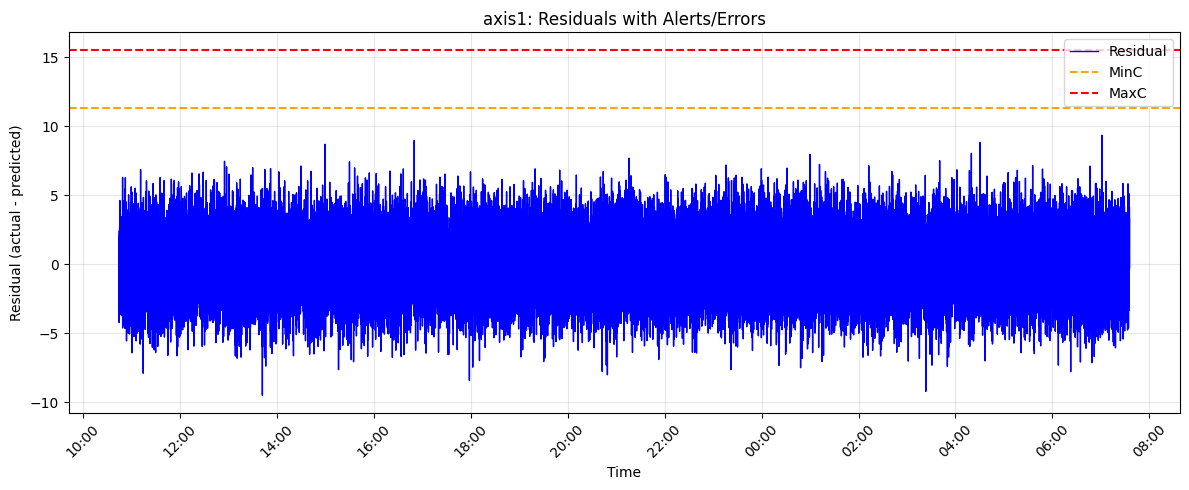

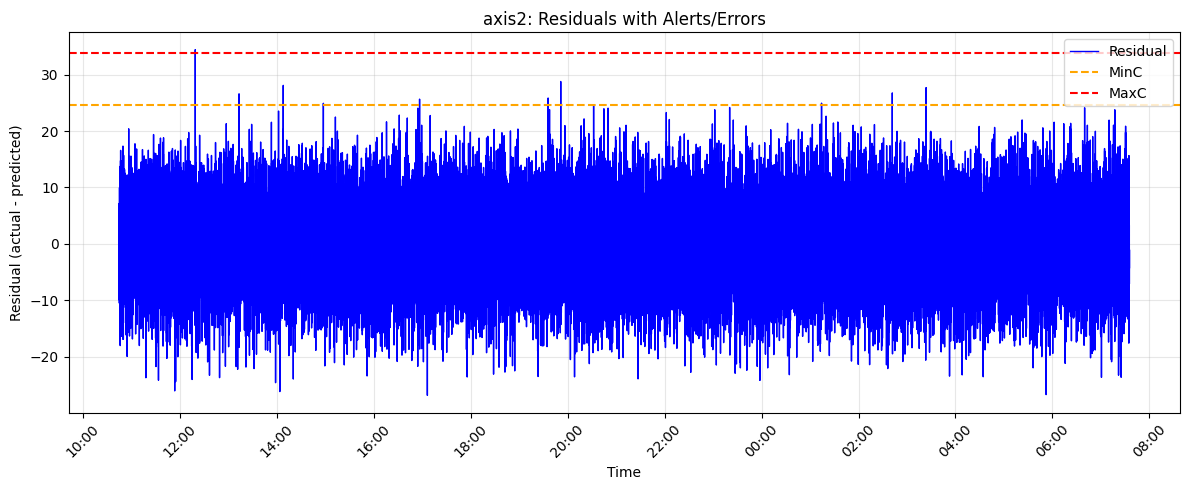

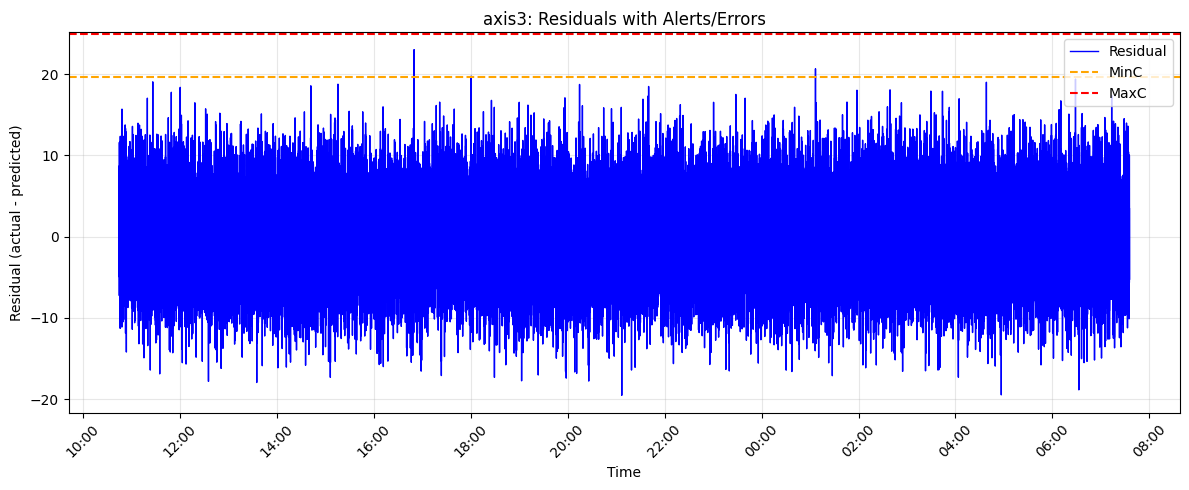

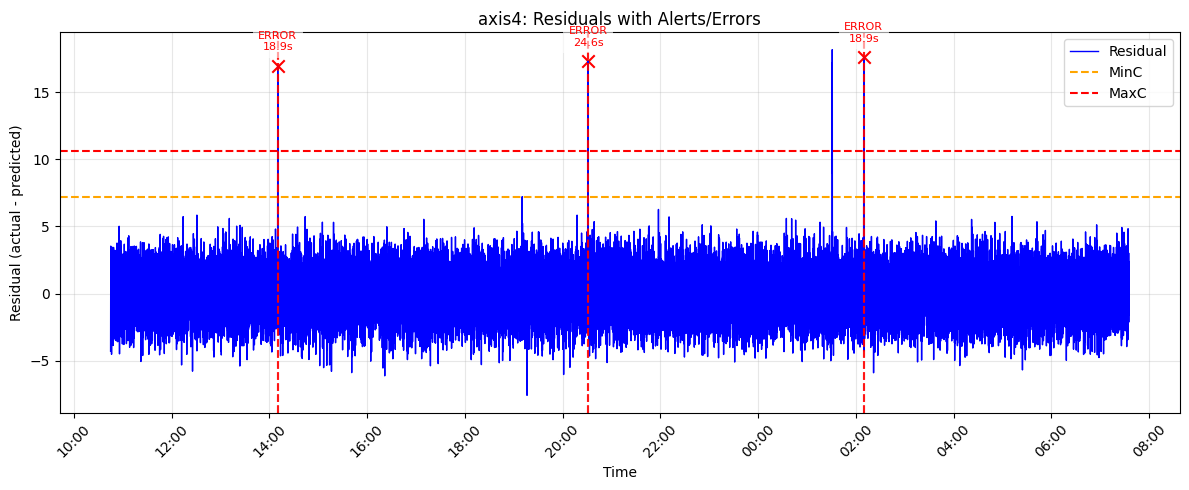

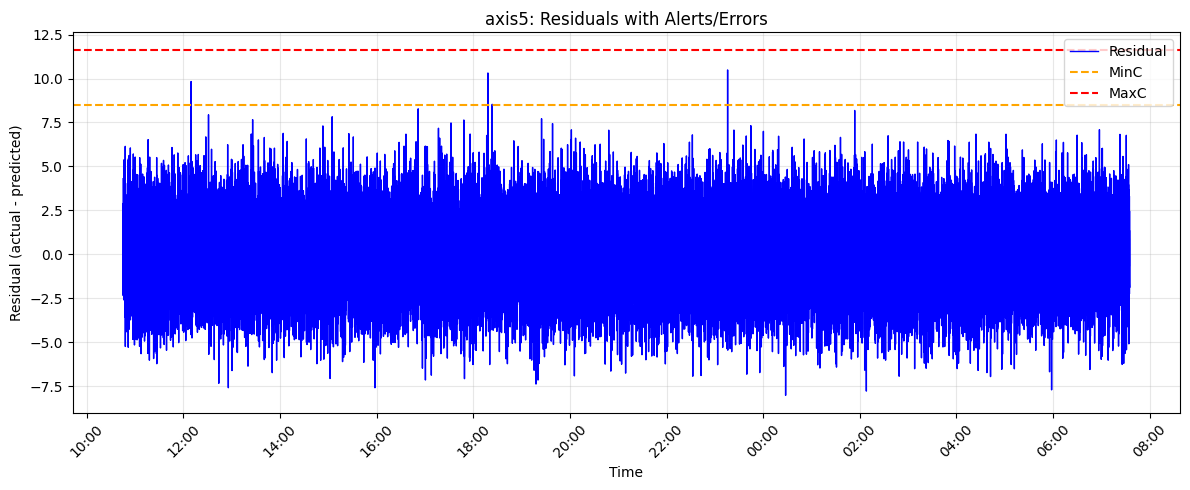

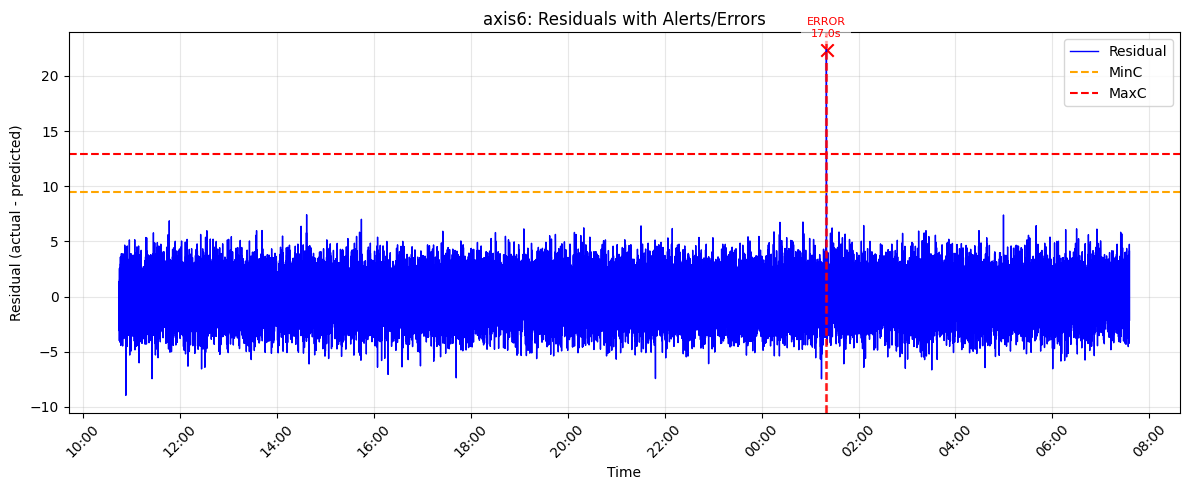

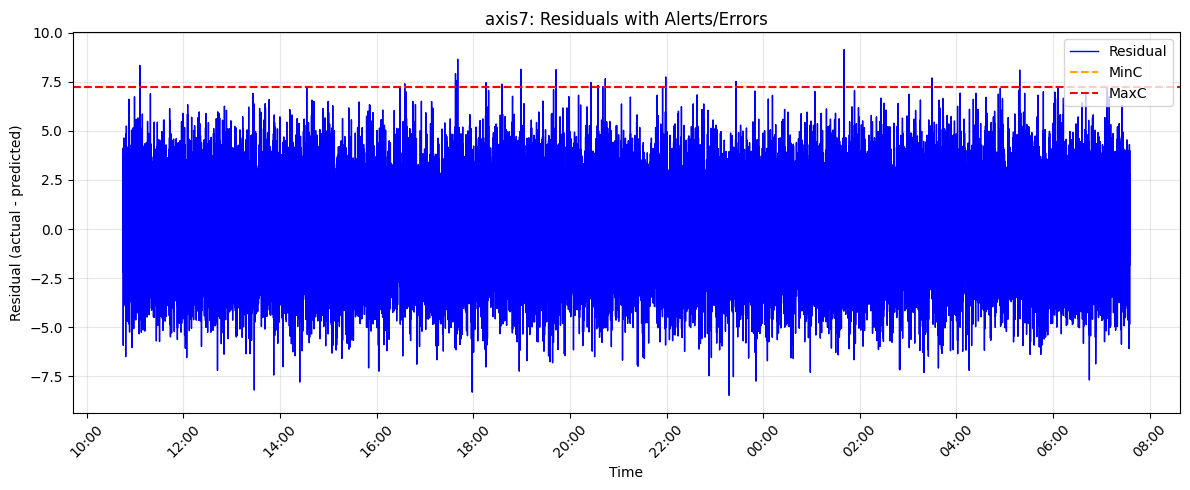

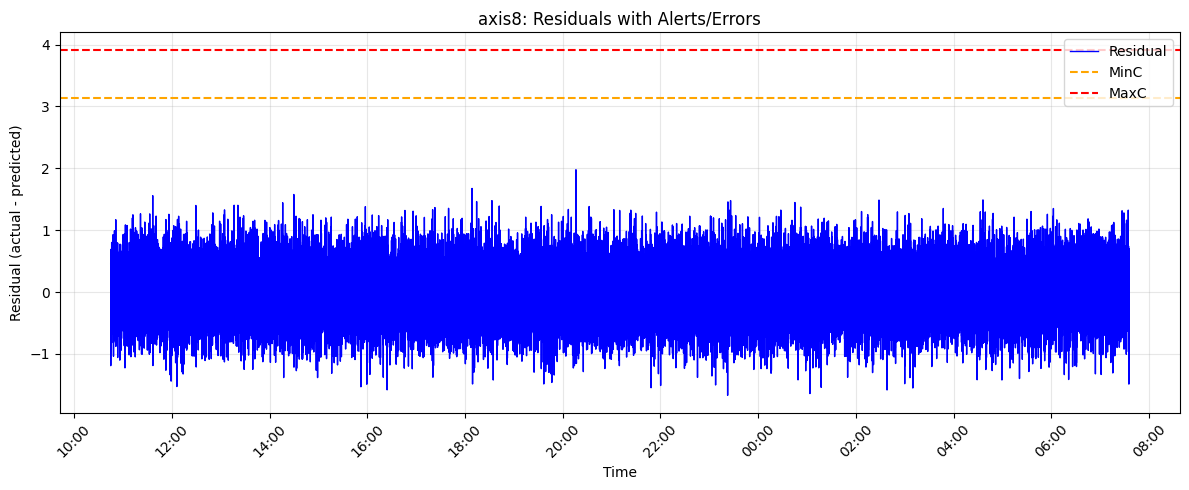

In [30]:
import matplotlib.dates as mdates

def plot_residuals_with_events(axis, df, residuals_test, MinC, MaxC, events):
    r = residuals_test[axis]
    t = df['time'].values

    plt.figure(figsize=(12,5))
    plt.plot(t, r, color="blue", linewidth=1, label="Residual")
    plt.axhline(MinC[axis], linestyle="--", color="orange", label="MinC")
    plt.axhline(MaxC[axis], linestyle="--", color="red", label="MaxC")

    for ev in events:
        if ev.axis != axis:
            continue

        # Vertical span for event
        plt.axvline(df.loc[ev.start_idx, 'time'], color="green" if ev.level=="ALERT" else "red",
                    linestyle="--", alpha=0.7)
        plt.axvline(df.loc[ev.end_idx, 'time'], color="green" if ev.level=="ALERT" else "red",
                    linestyle="--", alpha=0.7)

        # Mark peak point
        plt.scatter(df.loc[ev.end_idx,'time'], ev.peak_residual,
                    color="red" if ev.level=="ERROR" else "orange", marker="x", s=80)

        # Duration label in the middle of event
        mid_idx = ev.start_idx + (ev.end_idx - ev.start_idx)//2
        mid_time = df.loc[mid_idx, 'time']
        plt.text(mid_time, ev.peak_residual + 1,
                 f"{ev.level}\n{ev.duration_sec:.1f}s",
                 color="red" if ev.level=="ERROR" else "orange",
                 ha="center", va="bottom", fontsize=8,
                 bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    # Format time axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))   # every 2 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # show HH:MM
    plt.xticks(rotation=45)

    plt.title(f"{axis}: Residuals with Alerts/Errors")
    plt.xlabel("Time")
    plt.ylabel("Residual (actual - predicted)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- Run visualization for all axes ---
for axis in AXES:
    plot_residuals_with_events(axis, df_test, residuals_test, MinC, MaxC, events)
